In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, SpectralNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations, initializers
from keras.constraints import Constraint
import pickle

In [ ]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [ ]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [ ]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [ ]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if (i+1) % 5 == 0:
            C_A_list.append(C_A - C_As)  # in deviation form
            T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [ ]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [ ]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [ ]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
# RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input, -T_input, -CA_input, -Q_input, -CA0_input), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 4)


In [ ]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00]


In [ ]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [ ]:
# checking output
print(RNN_output[0, :5])

[[-75.72458929   1.4325163 ]
 [-76.84802004   1.4248451 ]
 [-77.97016868   1.41722366]
 [-79.09094468   1.40964998]
 [-80.21026299   1.40212216]]


In [ ]:
def check_non_negative_weights_ignore_bias(model):
    all_non_negative = True
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # tf the layer has weights
            # check only the weight matrices (ignoring biases if present)
            weight_only = weights[0]  # assume weights are the first element, bias (if any) is second
            if not np.all(weight_only >= 0):
                print(f"Non-negative check failed in layer: {layer.name}")
                all_non_negative = False
    if all_non_negative:
        print("All weights are non-negative (ignoring biases).")
    else:
        print("Some weights are negative (ignoring biases).")

In [ ]:
# this method will provide an overestimate of the Lipschitz constant
def evaluate_lip_const(model: Model, x, eps, seed=None):
    """
    Evaluate the Lipschitz constant of a model, with the naive method.
    Please note that the estimation of the lipschitz constant is done locally around
    input sample. This may not correctly estimate the behaviour in the whole domain.

    Args:
        model: built keras model used to make predictions
        x: inputs used to compute the lipschitz constant
        eps (float): magnitude of noise to add to input in order to compute the constant
        seed (int): seed used when generating the noise ( can be set to None )

    Returns:
        float: the empirically evaluated lipschitz constant. The computation might also
            be inaccurate in high dimensional space.

    """
    y_pred = model.predict(x)
    x_var = x + K.random_uniform(
        shape=x.shape, minval=eps * 0.25, maxval=eps, seed=seed
    )
#     x_var = x + K.random_normal(
#         shape=x.shape, mean=0, stddev=eps, seed=seed
#     )
    y_pred_var = model.predict(x_var)
    dx = x - x_var
    dfx = y_pred - y_pred_var
    ndx = K.sqrt(K.sum(K.square(dx), axis=range(1, len(x.shape))))
    ndfx = K.sqrt(K.sum(K.square(dfx), axis=range(1, len(y_pred.shape))))
    lip_cst = K.max(ndfx / ndx)
    print(f"lip cst: {lip_cst:.3f}")
    return lip_cst

In [ ]:
# set the seed for reproducibility
tf.random.set_seed(42)

training_loss = [0]*19
test_loss = [0]*19
lip = [0]*19
noise = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

for i in range(19):
    num_dims = 4

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

    # define scalers for both X and y base on training data only
    scaler_X = preprocessing.MinMaxScaler().fit(X_train.reshape(-1, num_dims))
    scaler_y = preprocessing.MinMaxScaler().fit(y_train.reshape(-1, 2))

    X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
    X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
    y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)
    y_test_normalized = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_step,2)

    # X is just the initial condition, so we introduce noise to the output trajectory y
    y_train = y_train + np.random.normal(0, noise[i], y_train.shape)

    # RNN
    nh = 64
    input = Input(shape=(X_train.shape[1],X_train.shape[2]))
    x = LSTM(nh,
          return_sequences=True,
          )(input)
    x = LSTM(nh,
          return_sequences=True,
          )(x)
    x = Dense(2,
            activation='linear',
            )(x)
    model = Model(input, x)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
    history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)

    training_loss[i] = history.history['val_loss'][-1]
    print(noise)
    print(training_loss)

    loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
    test_loss[i] = loss[0]
    print(test_loss)

    # check convexity by checking the weights
    check_non_negative_weights_ignore_bias(model)

    # compute the Lipschitz constant
    lipschitz_constant = evaluate_lip_const(model, X_train, 1e-04, 42)
    print(f"Estimated Lipschitz constant of the 2-layer RNN: {lipschitz_constant}")

    lip[i] = lipschitz_constant

model.summary()

Epoch 1/1000
26/26 - 5s - loss: 0.1382 - mean_squared_error: 0.1382 - val_loss: 0.0659 - val_mean_squared_error: 0.0659 - 5s/epoch - 207ms/step
Epoch 2/1000
26/26 - 1s - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - 596ms/epoch - 23ms/step
Epoch 3/1000
26/26 - 1s - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - 587ms/epoch - 23ms/step
Epoch 4/1000
26/26 - 1s - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - 575ms/epoch - 22ms/step
Epoch 5/1000
26/26 - 1s - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - 637ms/epoch - 24ms/step
Epoch 6/1000
26/26 - 1s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - 601ms/epoch - 23ms/step
Epoch 7/1000
26/26 - 1s - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - 624m

Epoch 53/1000
26/26 - 1s - loss: 5.9846e-05 - mean_squared_error: 5.9846e-05 - val_loss: 5.8832e-05 - val_mean_squared_error: 5.8832e-05 - 599ms/epoch - 23ms/step
Epoch 54/1000
26/26 - 1s - loss: 5.7522e-05 - mean_squared_error: 5.7522e-05 - val_loss: 5.5894e-05 - val_mean_squared_error: 5.5894e-05 - 585ms/epoch - 23ms/step
Epoch 55/1000
26/26 - 1s - loss: 5.5325e-05 - mean_squared_error: 5.5325e-05 - val_loss: 5.3774e-05 - val_mean_squared_error: 5.3774e-05 - 593ms/epoch - 23ms/step
Epoch 56/1000
26/26 - 1s - loss: 5.3259e-05 - mean_squared_error: 5.3259e-05 - val_loss: 5.1841e-05 - val_mean_squared_error: 5.1841e-05 - 578ms/epoch - 22ms/step
Epoch 57/1000
26/26 - 1s - loss: 5.1332e-05 - mean_squared_error: 5.1332e-05 - val_loss: 4.9871e-05 - val_mean_squared_error: 4.9871e-05 - 632ms/epoch - 24ms/step
Epoch 58/1000
26/26 - 1s - loss: 4.9268e-05 - mean_squared_error: 4.9268e-05 - val_loss: 4.8050e-05 - val_mean_squared_error: 4.8050e-05 - 613ms/epoch - 24ms/step
Epoch 59/1000
26/26 - 

Epoch 104/1000
26/26 - 1s - loss: 2.0339e-05 - mean_squared_error: 2.0339e-05 - val_loss: 1.2289e-05 - val_mean_squared_error: 1.2289e-05 - 693ms/epoch - 27ms/step
Epoch 105/1000
26/26 - 1s - loss: 1.3757e-05 - mean_squared_error: 1.3757e-05 - val_loss: 1.2873e-05 - val_mean_squared_error: 1.2873e-05 - 663ms/epoch - 26ms/step
Epoch 106/1000
26/26 - 1s - loss: 1.5293e-05 - mean_squared_error: 1.5293e-05 - val_loss: 1.3342e-05 - val_mean_squared_error: 1.3342e-05 - 699ms/epoch - 27ms/step
Epoch 107/1000
26/26 - 1s - loss: 1.3682e-05 - mean_squared_error: 1.3682e-05 - val_loss: 1.7577e-05 - val_mean_squared_error: 1.7577e-05 - 680ms/epoch - 26ms/step
Epoch 108/1000
26/26 - 1s - loss: 1.4229e-05 - mean_squared_error: 1.4229e-05 - val_loss: 1.2973e-05 - val_mean_squared_error: 1.2973e-05 - 694ms/epoch - 27ms/step
Epoch 109/1000
26/26 - 1s - loss: 1.2026e-05 - mean_squared_error: 1.2026e-05 - val_loss: 1.1346e-05 - val_mean_squared_error: 1.1346e-05 - 697ms/epoch - 27ms/step
Epoch 110/1000
2

Epoch 154/1000
26/26 - 1s - loss: 5.8400e-06 - mean_squared_error: 5.8400e-06 - val_loss: 1.1187e-05 - val_mean_squared_error: 1.1187e-05 - 696ms/epoch - 27ms/step
Epoch 155/1000
26/26 - 1s - loss: 7.6139e-06 - mean_squared_error: 7.6139e-06 - val_loss: 8.0274e-06 - val_mean_squared_error: 8.0274e-06 - 677ms/epoch - 26ms/step
Epoch 156/1000
26/26 - 1s - loss: 7.3871e-06 - mean_squared_error: 7.3871e-06 - val_loss: 7.6715e-06 - val_mean_squared_error: 7.6715e-06 - 713ms/epoch - 27ms/step
Epoch 157/1000
26/26 - 1s - loss: 9.1463e-06 - mean_squared_error: 9.1463e-06 - val_loss: 4.8309e-06 - val_mean_squared_error: 4.8309e-06 - 679ms/epoch - 26ms/step
Epoch 158/1000
26/26 - 1s - loss: 1.0305e-05 - mean_squared_error: 1.0305e-05 - val_loss: 9.7097e-06 - val_mean_squared_error: 9.7097e-06 - 711ms/epoch - 27ms/step
Epoch 159/1000
26/26 - 1s - loss: 7.0999e-06 - mean_squared_error: 7.0999e-06 - val_loss: 1.0304e-05 - val_mean_squared_error: 1.0304e-05 - 718ms/epoch - 28ms/step
Epoch 160/1000
2

Epoch 204/1000
26/26 - 1s - loss: 7.2200e-06 - mean_squared_error: 7.2200e-06 - val_loss: 5.8122e-06 - val_mean_squared_error: 5.8122e-06 - 677ms/epoch - 26ms/step
Epoch 205/1000
26/26 - 1s - loss: 4.3308e-06 - mean_squared_error: 4.3308e-06 - val_loss: 7.4435e-06 - val_mean_squared_error: 7.4435e-06 - 711ms/epoch - 27ms/step
Epoch 206/1000
26/26 - 1s - loss: 8.4741e-06 - mean_squared_error: 8.4741e-06 - val_loss: 8.3296e-06 - val_mean_squared_error: 8.3296e-06 - 693ms/epoch - 27ms/step
Epoch 207/1000
26/26 - 1s - loss: 4.8761e-06 - mean_squared_error: 4.8761e-06 - val_loss: 4.0124e-06 - val_mean_squared_error: 4.0124e-06 - 713ms/epoch - 27ms/step
Epoch 208/1000
26/26 - 1s - loss: 7.0016e-06 - mean_squared_error: 7.0016e-06 - val_loss: 2.7238e-05 - val_mean_squared_error: 2.7238e-05 - 695ms/epoch - 27ms/step
Epoch 209/1000
26/26 - 1s - loss: 1.3954e-05 - mean_squared_error: 1.3954e-05 - val_loss: 4.6795e-06 - val_mean_squared_error: 4.6795e-06 - 685ms/epoch - 26ms/step
Epoch 210/1000
2

Epoch 254/1000
26/26 - 1s - loss: 3.9741e-06 - mean_squared_error: 3.9741e-06 - val_loss: 2.8529e-06 - val_mean_squared_error: 2.8529e-06 - 727ms/epoch - 28ms/step
Epoch 255/1000
26/26 - 1s - loss: 1.3085e-05 - mean_squared_error: 1.3085e-05 - val_loss: 1.6812e-05 - val_mean_squared_error: 1.6812e-05 - 694ms/epoch - 27ms/step
Epoch 256/1000
26/26 - 1s - loss: 7.2488e-06 - mean_squared_error: 7.2488e-06 - val_loss: 3.4337e-06 - val_mean_squared_error: 3.4337e-06 - 700ms/epoch - 27ms/step
Epoch 257/1000
26/26 - 1s - loss: 2.6574e-06 - mean_squared_error: 2.6574e-06 - val_loss: 3.3205e-06 - val_mean_squared_error: 3.3205e-06 - 700ms/epoch - 27ms/step
Epoch 258/1000
26/26 - 1s - loss: 3.7055e-06 - mean_squared_error: 3.7055e-06 - val_loss: 2.8809e-06 - val_mean_squared_error: 2.8809e-06 - 692ms/epoch - 27ms/step
Epoch 259/1000
26/26 - 1s - loss: 3.2148e-06 - mean_squared_error: 3.2148e-06 - val_loss: 3.5527e-06 - val_mean_squared_error: 3.5527e-06 - 709ms/epoch - 27ms/step
Epoch 260/1000
2

Epoch 304/1000
26/26 - 1s - loss: 2.0288e-06 - mean_squared_error: 2.0288e-06 - val_loss: 3.0292e-06 - val_mean_squared_error: 3.0292e-06 - 694ms/epoch - 27ms/step
Epoch 305/1000
26/26 - 1s - loss: 4.0262e-06 - mean_squared_error: 4.0262e-06 - val_loss: 8.3075e-06 - val_mean_squared_error: 8.3075e-06 - 744ms/epoch - 29ms/step
Epoch 306/1000
26/26 - 1s - loss: 8.3992e-06 - mean_squared_error: 8.3992e-06 - val_loss: 2.0203e-06 - val_mean_squared_error: 2.0203e-06 - 693ms/epoch - 27ms/step
Epoch 307/1000
26/26 - 1s - loss: 3.8744e-06 - mean_squared_error: 3.8744e-06 - val_loss: 2.4035e-06 - val_mean_squared_error: 2.4035e-06 - 740ms/epoch - 28ms/step
Epoch 308/1000
26/26 - 1s - loss: 3.9092e-06 - mean_squared_error: 3.9092e-06 - val_loss: 1.7470e-06 - val_mean_squared_error: 1.7470e-06 - 677ms/epoch - 26ms/step
Epoch 309/1000
26/26 - 1s - loss: 3.8661e-06 - mean_squared_error: 3.8661e-06 - val_loss: 9.3660e-06 - val_mean_squared_error: 9.3660e-06 - 678ms/epoch - 26ms/step
Epoch 310/1000
2

Epoch 354/1000
26/26 - 1s - loss: 3.6733e-06 - mean_squared_error: 3.6733e-06 - val_loss: 3.2555e-06 - val_mean_squared_error: 3.2555e-06 - 709ms/epoch - 27ms/step
Epoch 355/1000
26/26 - 1s - loss: 8.1386e-06 - mean_squared_error: 8.1386e-06 - val_loss: 4.2255e-06 - val_mean_squared_error: 4.2255e-06 - 710ms/epoch - 27ms/step
Epoch 356/1000
26/26 - 1s - loss: 3.5955e-06 - mean_squared_error: 3.5955e-06 - val_loss: 1.7171e-06 - val_mean_squared_error: 1.7171e-06 - 708ms/epoch - 27ms/step
Epoch 357/1000
26/26 - 1s - loss: 3.5405e-06 - mean_squared_error: 3.5405e-06 - val_loss: 2.4749e-06 - val_mean_squared_error: 2.4749e-06 - 705ms/epoch - 27ms/step
Epoch 358/1000
26/26 - 1s - loss: 3.5547e-06 - mean_squared_error: 3.5547e-06 - val_loss: 4.0402e-06 - val_mean_squared_error: 4.0402e-06 - 680ms/epoch - 26ms/step
Epoch 359/1000
26/26 - 1s - loss: 8.6666e-06 - mean_squared_error: 8.6666e-06 - val_loss: 3.7194e-06 - val_mean_squared_error: 3.7194e-06 - 678ms/epoch - 26ms/step
Epoch 360/1000
2

Epoch 404/1000
26/26 - 1s - loss: 4.4001e-06 - mean_squared_error: 4.4001e-06 - val_loss: 3.8424e-06 - val_mean_squared_error: 3.8424e-06 - 686ms/epoch - 26ms/step
Epoch 405/1000
26/26 - 1s - loss: 3.0701e-06 - mean_squared_error: 3.0701e-06 - val_loss: 3.8767e-06 - val_mean_squared_error: 3.8767e-06 - 718ms/epoch - 28ms/step
Epoch 406/1000
26/26 - 1s - loss: 2.0470e-06 - mean_squared_error: 2.0470e-06 - val_loss: 2.1845e-06 - val_mean_squared_error: 2.1845e-06 - 702ms/epoch - 27ms/step
Epoch 407/1000
26/26 - 1s - loss: 1.4588e-06 - mean_squared_error: 1.4588e-06 - val_loss: 5.4895e-06 - val_mean_squared_error: 5.4895e-06 - 683ms/epoch - 26ms/step
Epoch 408/1000
26/26 - 1s - loss: 6.3665e-06 - mean_squared_error: 6.3665e-06 - val_loss: 3.0270e-06 - val_mean_squared_error: 3.0270e-06 - 718ms/epoch - 28ms/step
Epoch 409/1000
26/26 - 1s - loss: 1.6148e-06 - mean_squared_error: 1.6148e-06 - val_loss: 8.1336e-07 - val_mean_squared_error: 8.1336e-07 - 701ms/epoch - 27ms/step
Epoch 410/1000
2

Epoch 454/1000
26/26 - 1s - loss: 2.2143e-06 - mean_squared_error: 2.2143e-06 - val_loss: 5.2700e-06 - val_mean_squared_error: 5.2700e-06 - 702ms/epoch - 27ms/step
Epoch 455/1000
26/26 - 1s - loss: 3.3776e-06 - mean_squared_error: 3.3776e-06 - val_loss: 1.2278e-06 - val_mean_squared_error: 1.2278e-06 - 702ms/epoch - 27ms/step
Epoch 456/1000
26/26 - 1s - loss: 1.0934e-06 - mean_squared_error: 1.0934e-06 - val_loss: 1.0146e-06 - val_mean_squared_error: 1.0146e-06 - 716ms/epoch - 28ms/step
Epoch 457/1000
26/26 - 1s - loss: 5.9288e-06 - mean_squared_error: 5.9288e-06 - val_loss: 1.4840e-05 - val_mean_squared_error: 1.4840e-05 - 686ms/epoch - 26ms/step
Epoch 458/1000
26/26 - 1s - loss: 9.1152e-06 - mean_squared_error: 9.1152e-06 - val_loss: 3.2486e-06 - val_mean_squared_error: 3.2486e-06 - 686ms/epoch - 26ms/step
Epoch 459/1000
26/26 - 1s - loss: 1.4672e-06 - mean_squared_error: 1.4672e-06 - val_loss: 8.5412e-07 - val_mean_squared_error: 8.5412e-07 - 719ms/epoch - 28ms/step
Epoch 460/1000
2

Epoch 504/1000
26/26 - 1s - loss: 1.0054e-06 - mean_squared_error: 1.0054e-06 - val_loss: 7.0574e-07 - val_mean_squared_error: 7.0574e-07 - 704ms/epoch - 27ms/step
Epoch 505/1000
26/26 - 1s - loss: 3.2876e-06 - mean_squared_error: 3.2876e-06 - val_loss: 1.1356e-06 - val_mean_squared_error: 1.1356e-06 - 716ms/epoch - 28ms/step
Epoch 506/1000
26/26 - 1s - loss: 4.5926e-06 - mean_squared_error: 4.5926e-06 - val_loss: 5.8803e-06 - val_mean_squared_error: 5.8803e-06 - 717ms/epoch - 28ms/step
Epoch 507/1000
26/26 - 1s - loss: 6.4705e-06 - mean_squared_error: 6.4705e-06 - val_loss: 2.9009e-06 - val_mean_squared_error: 2.9009e-06 - 718ms/epoch - 28ms/step
Epoch 508/1000
26/26 - 1s - loss: 1.1635e-06 - mean_squared_error: 1.1635e-06 - val_loss: 9.8227e-07 - val_mean_squared_error: 9.8227e-07 - 718ms/epoch - 28ms/step
Epoch 509/1000
26/26 - 1s - loss: 9.0599e-07 - mean_squared_error: 9.0599e-07 - val_loss: 1.6175e-06 - val_mean_squared_error: 1.6175e-06 - 701ms/epoch - 27ms/step
Epoch 510/1000
2

Epoch 554/1000
26/26 - 1s - loss: 5.8596e-07 - mean_squared_error: 5.8596e-07 - val_loss: 2.6195e-06 - val_mean_squared_error: 2.6195e-06 - 719ms/epoch - 28ms/step
Epoch 555/1000
26/26 - 1s - loss: 1.0100e-05 - mean_squared_error: 1.0100e-05 - val_loss: 2.0202e-06 - val_mean_squared_error: 2.0202e-06 - 716ms/epoch - 28ms/step
Epoch 556/1000
26/26 - 1s - loss: 2.0819e-06 - mean_squared_error: 2.0819e-06 - val_loss: 9.2380e-07 - val_mean_squared_error: 9.2380e-07 - 703ms/epoch - 27ms/step
Epoch 557/1000
26/26 - 1s - loss: 6.2615e-07 - mean_squared_error: 6.2615e-07 - val_loss: 4.2295e-07 - val_mean_squared_error: 4.2295e-07 - 719ms/epoch - 28ms/step
Epoch 558/1000
26/26 - 1s - loss: 6.4815e-07 - mean_squared_error: 6.4815e-07 - val_loss: 1.0655e-06 - val_mean_squared_error: 1.0655e-06 - 713ms/epoch - 27ms/step
Epoch 559/1000
26/26 - 1s - loss: 3.5841e-06 - mean_squared_error: 3.5841e-06 - val_loss: 9.0661e-07 - val_mean_squared_error: 9.0661e-07 - 718ms/epoch - 28ms/step
Epoch 560/1000
2

Epoch 604/1000
26/26 - 1s - loss: 4.0837e-07 - mean_squared_error: 4.0837e-07 - val_loss: 2.5100e-07 - val_mean_squared_error: 2.5100e-07 - 707ms/epoch - 27ms/step
Epoch 605/1000
26/26 - 1s - loss: 6.5632e-07 - mean_squared_error: 6.5632e-07 - val_loss: 2.9862e-07 - val_mean_squared_error: 2.9862e-07 - 707ms/epoch - 27ms/step
Epoch 606/1000
26/26 - 1s - loss: 7.9189e-07 - mean_squared_error: 7.9189e-07 - val_loss: 1.4709e-06 - val_mean_squared_error: 1.4709e-06 - 704ms/epoch - 27ms/step
Epoch 607/1000
26/26 - 1s - loss: 4.3874e-06 - mean_squared_error: 4.3874e-06 - val_loss: 1.1420e-06 - val_mean_squared_error: 1.1420e-06 - 718ms/epoch - 28ms/step
Epoch 608/1000
26/26 - 1s - loss: 1.2792e-06 - mean_squared_error: 1.2792e-06 - val_loss: 6.4268e-07 - val_mean_squared_error: 6.4268e-07 - 715ms/epoch - 27ms/step
Epoch 609/1000
26/26 - 1s - loss: 4.4294e-07 - mean_squared_error: 4.4294e-07 - val_loss: 4.2187e-07 - val_mean_squared_error: 4.2187e-07 - 691ms/epoch - 27ms/step
Epoch 610/1000
2

Epoch 654/1000
26/26 - 1s - loss: 2.6367e-06 - mean_squared_error: 2.6367e-06 - val_loss: 1.5260e-06 - val_mean_squared_error: 1.5260e-06 - 687ms/epoch - 26ms/step
Epoch 655/1000
26/26 - 1s - loss: 6.0459e-07 - mean_squared_error: 6.0459e-07 - val_loss: 9.4008e-07 - val_mean_squared_error: 9.4008e-07 - 734ms/epoch - 28ms/step
Epoch 656/1000
26/26 - 1s - loss: 4.7032e-06 - mean_squared_error: 4.7032e-06 - val_loss: 1.0298e-05 - val_mean_squared_error: 1.0298e-05 - 718ms/epoch - 28ms/step
Epoch 657/1000
26/26 - 1s - loss: 2.1818e-06 - mean_squared_error: 2.1818e-06 - val_loss: 2.7993e-07 - val_mean_squared_error: 2.7993e-07 - 687ms/epoch - 26ms/step
Epoch 658/1000
26/26 - 1s - loss: 6.1629e-07 - mean_squared_error: 6.1629e-07 - val_loss: 1.0397e-06 - val_mean_squared_error: 1.0397e-06 - 716ms/epoch - 28ms/step
Epoch 659/1000
26/26 - 1s - loss: 1.1269e-06 - mean_squared_error: 1.1269e-06 - val_loss: 7.6207e-07 - val_mean_squared_error: 7.6207e-07 - 673ms/epoch - 26ms/step
Epoch 660/1000
2

Epoch 704/1000
26/26 - 1s - loss: 1.8239e-06 - mean_squared_error: 1.8239e-06 - val_loss: 7.2227e-06 - val_mean_squared_error: 7.2227e-06 - 691ms/epoch - 27ms/step
Epoch 705/1000
26/26 - 1s - loss: 3.8670e-06 - mean_squared_error: 3.8670e-06 - val_loss: 1.6106e-06 - val_mean_squared_error: 1.6106e-06 - 719ms/epoch - 28ms/step
Epoch 706/1000
26/26 - 1s - loss: 9.4186e-07 - mean_squared_error: 9.4186e-07 - val_loss: 4.0893e-07 - val_mean_squared_error: 4.0893e-07 - 718ms/epoch - 28ms/step
Epoch 707/1000
26/26 - 1s - loss: 1.1787e-06 - mean_squared_error: 1.1787e-06 - val_loss: 9.4692e-07 - val_mean_squared_error: 9.4692e-07 - 718ms/epoch - 28ms/step
Epoch 708/1000
26/26 - 1s - loss: 1.4647e-06 - mean_squared_error: 1.4647e-06 - val_loss: 3.1815e-06 - val_mean_squared_error: 3.1815e-06 - 703ms/epoch - 27ms/step
Epoch 709/1000
26/26 - 1s - loss: 1.1290e-06 - mean_squared_error: 1.1290e-06 - val_loss: 2.2745e-06 - val_mean_squared_error: 2.2745e-06 - 719ms/epoch - 28ms/step
Epoch 710/1000
2

Epoch 754/1000
26/26 - 1s - loss: 4.3601e-07 - mean_squared_error: 4.3601e-07 - val_loss: 3.0917e-07 - val_mean_squared_error: 3.0917e-07 - 721ms/epoch - 28ms/step
Epoch 755/1000
26/26 - 1s - loss: 2.7248e-06 - mean_squared_error: 2.7248e-06 - val_loss: 1.4657e-05 - val_mean_squared_error: 1.4657e-05 - 719ms/epoch - 28ms/step
Epoch 756/1000
26/26 - 1s - loss: 1.0384e-05 - mean_squared_error: 1.0384e-05 - val_loss: 7.6519e-06 - val_mean_squared_error: 7.6519e-06 - 746ms/epoch - 29ms/step
Epoch 757/1000
26/26 - 1s - loss: 4.9194e-06 - mean_squared_error: 4.9194e-06 - val_loss: 1.9232e-06 - val_mean_squared_error: 1.9232e-06 - 693ms/epoch - 27ms/step
Epoch 758/1000
26/26 - 1s - loss: 9.0278e-07 - mean_squared_error: 9.0278e-07 - val_loss: 5.0427e-07 - val_mean_squared_error: 5.0427e-07 - 719ms/epoch - 28ms/step
Epoch 759/1000
26/26 - 1s - loss: 3.4677e-07 - mean_squared_error: 3.4677e-07 - val_loss: 1.9214e-07 - val_mean_squared_error: 1.9214e-07 - 704ms/epoch - 27ms/step
Epoch 760/1000
2

Epoch 804/1000
26/26 - 1s - loss: 1.9302e-06 - mean_squared_error: 1.9302e-06 - val_loss: 1.1271e-06 - val_mean_squared_error: 1.1271e-06 - 718ms/epoch - 28ms/step
Epoch 805/1000
26/26 - 1s - loss: 2.0387e-06 - mean_squared_error: 2.0387e-06 - val_loss: 1.9725e-06 - val_mean_squared_error: 1.9725e-06 - 710ms/epoch - 27ms/step
Epoch 806/1000
26/26 - 1s - loss: 1.2349e-06 - mean_squared_error: 1.2349e-06 - val_loss: 5.5526e-07 - val_mean_squared_error: 5.5526e-07 - 733ms/epoch - 28ms/step
Epoch 807/1000
26/26 - 1s - loss: 8.2174e-07 - mean_squared_error: 8.2174e-07 - val_loss: 7.5255e-07 - val_mean_squared_error: 7.5255e-07 - 702ms/epoch - 27ms/step
Epoch 808/1000
26/26 - 1s - loss: 2.4694e-06 - mean_squared_error: 2.4694e-06 - val_loss: 6.2124e-06 - val_mean_squared_error: 6.2124e-06 - 750ms/epoch - 29ms/step
Epoch 809/1000
26/26 - 1s - loss: 5.0980e-06 - mean_squared_error: 5.0980e-06 - val_loss: 2.9313e-06 - val_mean_squared_error: 2.9313e-06 - 712ms/epoch - 27ms/step
Epoch 810/1000
2

Epoch 854/1000
26/26 - 1s - loss: 3.3971e-06 - mean_squared_error: 3.3971e-06 - val_loss: 4.7412e-06 - val_mean_squared_error: 4.7412e-06 - 704ms/epoch - 27ms/step
Epoch 855/1000
26/26 - 1s - loss: 2.4357e-06 - mean_squared_error: 2.4357e-06 - val_loss: 3.5791e-06 - val_mean_squared_error: 3.5791e-06 - 707ms/epoch - 27ms/step
Epoch 856/1000
26/26 - 1s - loss: 1.8447e-06 - mean_squared_error: 1.8447e-06 - val_loss: 3.9092e-07 - val_mean_squared_error: 3.9092e-07 - 698ms/epoch - 27ms/step
Epoch 857/1000
26/26 - 1s - loss: 4.3170e-07 - mean_squared_error: 4.3170e-07 - val_loss: 1.4261e-06 - val_mean_squared_error: 1.4261e-06 - 720ms/epoch - 28ms/step
Epoch 858/1000
26/26 - 1s - loss: 3.0428e-06 - mean_squared_error: 3.0428e-06 - val_loss: 1.0191e-05 - val_mean_squared_error: 1.0191e-05 - 720ms/epoch - 28ms/step
Epoch 859/1000
26/26 - 1s - loss: 5.4440e-06 - mean_squared_error: 5.4440e-06 - val_loss: 1.0551e-06 - val_mean_squared_error: 1.0551e-06 - 705ms/epoch - 27ms/step
Epoch 860/1000
2

Epoch 904/1000
26/26 - 1s - loss: 2.6619e-07 - mean_squared_error: 2.6619e-07 - val_loss: 6.9625e-07 - val_mean_squared_error: 6.9625e-07 - 711ms/epoch - 27ms/step
Epoch 905/1000
26/26 - 1s - loss: 2.5437e-06 - mean_squared_error: 2.5437e-06 - val_loss: 4.2618e-06 - val_mean_squared_error: 4.2618e-06 - 710ms/epoch - 27ms/step
Epoch 906/1000
26/26 - 1s - loss: 4.9699e-06 - mean_squared_error: 4.9699e-06 - val_loss: 1.4711e-06 - val_mean_squared_error: 1.4711e-06 - 703ms/epoch - 27ms/step
Epoch 907/1000
26/26 - 1s - loss: 1.4703e-06 - mean_squared_error: 1.4703e-06 - val_loss: 1.0254e-06 - val_mean_squared_error: 1.0254e-06 - 735ms/epoch - 28ms/step
Epoch 908/1000
26/26 - 1s - loss: 6.6308e-07 - mean_squared_error: 6.6308e-07 - val_loss: 3.0104e-07 - val_mean_squared_error: 3.0104e-07 - 706ms/epoch - 27ms/step
Epoch 909/1000
26/26 - 1s - loss: 4.7158e-07 - mean_squared_error: 4.7158e-07 - val_loss: 8.9577e-07 - val_mean_squared_error: 8.9577e-07 - 714ms/epoch - 27ms/step
Epoch 910/1000
2

Epoch 954/1000
26/26 - 1s - loss: 2.6172e-06 - mean_squared_error: 2.6172e-06 - val_loss: 1.1897e-06 - val_mean_squared_error: 1.1897e-06 - 736ms/epoch - 28ms/step
Epoch 955/1000
26/26 - 1s - loss: 1.6321e-06 - mean_squared_error: 1.6321e-06 - val_loss: 1.1316e-06 - val_mean_squared_error: 1.1316e-06 - 708ms/epoch - 27ms/step
Epoch 956/1000
26/26 - 1s - loss: 5.2755e-07 - mean_squared_error: 5.2755e-07 - val_loss: 4.7603e-07 - val_mean_squared_error: 4.7603e-07 - 713ms/epoch - 27ms/step
Epoch 957/1000
26/26 - 1s - loss: 7.7722e-07 - mean_squared_error: 7.7722e-07 - val_loss: 2.2744e-07 - val_mean_squared_error: 2.2744e-07 - 721ms/epoch - 28ms/step
Epoch 958/1000
26/26 - 1s - loss: 8.5972e-07 - mean_squared_error: 8.5972e-07 - val_loss: 6.2771e-06 - val_mean_squared_error: 6.2771e-06 - 720ms/epoch - 28ms/step
Epoch 959/1000
26/26 - 1s - loss: 5.8842e-06 - mean_squared_error: 5.8842e-06 - val_loss: 4.4077e-06 - val_mean_squared_error: 4.4077e-06 - 704ms/epoch - 27ms/step
Epoch 960/1000
2

271/271 [==============================] - 1s 3ms/step
lip cst: 0.763
Estimated Lipschitz constant of the 2-layer RNN: 0.7627303004264832
Epoch 1/1000
26/26 - 5s - loss: 0.1357 - mean_squared_error: 0.1357 - val_loss: 0.0642 - val_mean_squared_error: 0.0642 - 5s/epoch - 206ms/step
Epoch 2/1000
26/26 - 1s - loss: 0.0504 - mean_squared_error: 0.0504 - val_loss: 0.0387 - val_mean_squared_error: 0.0387 - 514ms/epoch - 20ms/step
Epoch 3/1000
26/26 - 1s - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - 573ms/epoch - 22ms/step
Epoch 4/1000
26/26 - 1s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - 581ms/epoch - 22ms/step
Epoch 5/1000
26/26 - 1s - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - 602ms/epoch - 23ms/step
Epoch 6/1000
26/26 - 1s - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - 602ms/epoch 

Epoch 56/1000
26/26 - 1s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 584ms/epoch - 22ms/step
Epoch 57/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 557ms/epoch - 21ms/step
Epoch 58/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 630ms/epoch - 24ms/step
Epoch 59/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 591ms/epoch - 23ms/step
Epoch 60/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 565ms/epoch - 22ms/step
Epoch 61/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 576ms/epoch - 22ms/step
Epoch 62/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.00

Epoch 112/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 563ms/epoch - 22ms/step
Epoch 113/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 576ms/epoch - 22ms/step
Epoch 114/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 582ms/epoch - 22ms/step
Epoch 115/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 574ms/epoch - 22ms/step
Epoch 116/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 592ms/epoch - 23ms/step
Epoch 117/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 576ms/epoch - 22ms/step
Epoch 118/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 168/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 572ms/epoch - 22ms/step
Epoch 169/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 545ms/epoch - 21ms/step
Epoch 170/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 545ms/epoch - 21ms/step
Epoch 171/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 561ms/epoch - 22ms/step
Epoch 172/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 576ms/epoch - 22ms/step
Epoch 173/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 578ms/epoch - 22ms/step
Epoch 174/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 224/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 597ms/epoch - 23ms/step
Epoch 225/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 561ms/epoch - 22ms/step
Epoch 226/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 575ms/epoch - 22ms/step
Epoch 227/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 568ms/epoch - 22ms/step
Epoch 228/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 595ms/epoch - 23ms/step
Epoch 229/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 583ms/epoch - 22ms/step
Epoch 230/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 280/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 567ms/epoch - 22ms/step
Epoch 281/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 566ms/epoch - 22ms/step
Epoch 282/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 583ms/epoch - 22ms/step
Epoch 283/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 536ms/epoch - 21ms/step
Epoch 284/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 567ms/epoch - 22ms/step
Epoch 285/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 566ms/epoch - 22ms/step
Epoch 286/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 336/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 563ms/epoch - 22ms/step
Epoch 337/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 577ms/epoch - 22ms/step
Epoch 338/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 546ms/epoch - 21ms/step
Epoch 339/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 577ms/epoch - 22ms/step
Epoch 340/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 574ms/epoch - 22ms/step
Epoch 341/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 561ms/epoch - 22ms/step
Epoch 342/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 392/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 582ms/epoch - 22ms/step
Epoch 393/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 573ms/epoch - 22ms/step
Epoch 394/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 561ms/epoch - 22ms/step
Epoch 395/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - 580ms/epoch - 22ms/step
Epoch 396/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 566ms/epoch - 22ms/step
Epoch 397/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 586ms/epoch - 23ms/step
Epoch 398/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 448/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 564ms/epoch - 22ms/step
Epoch 449/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 597ms/epoch - 23ms/step
Epoch 450/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 554ms/epoch - 21ms/step
Epoch 451/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 564ms/epoch - 22ms/step
Epoch 452/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 602ms/epoch - 23ms/step
Epoch 453/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 569ms/epoch - 22ms/step
Epoch 454/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 504/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 563ms/epoch - 22ms/step
Epoch 505/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 563ms/epoch - 22ms/step
Epoch 506/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 562ms/epoch - 22ms/step
Epoch 507/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 583ms/epoch - 22ms/step
Epoch 508/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 576ms/epoch - 22ms/step
Epoch 509/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 578ms/epoch - 22ms/step
Epoch 510/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 560/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 575ms/epoch - 22ms/step
Epoch 561/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 609ms/epoch - 23ms/step
Epoch 562/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 619ms/epoch - 24ms/step
Epoch 563/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 589ms/epoch - 23ms/step
Epoch 564/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 586ms/epoch - 23ms/step
Epoch 565/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 602ms/epoch - 23ms/step
Epoch 566/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 616/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 626ms/epoch - 24ms/step
Epoch 617/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 576ms/epoch - 22ms/step
Epoch 618/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 620ms/epoch - 24ms/step
Epoch 619/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 587ms/epoch - 23ms/step
Epoch 620/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 593ms/epoch - 23ms/step
Epoch 621/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 569ms/epoch - 22ms/step
Epoch 622/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 672/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 592ms/epoch - 23ms/step
Epoch 673/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 591ms/epoch - 23ms/step
Epoch 674/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 604ms/epoch - 23ms/step
Epoch 675/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 570ms/epoch - 22ms/step
Epoch 676/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 593ms/epoch - 23ms/step
Epoch 677/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 628ms/epoch - 24ms/step
Epoch 678/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 728/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 574ms/epoch - 22ms/step
Epoch 729/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 571ms/epoch - 22ms/step
Epoch 730/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 582ms/epoch - 22ms/step
Epoch 731/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 602ms/epoch - 23ms/step
Epoch 732/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 574ms/epoch - 22ms/step
Epoch 733/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 577ms/epoch - 22ms/step
Epoch 734/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 784/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 571ms/epoch - 22ms/step
Epoch 785/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 582ms/epoch - 22ms/step
Epoch 786/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 566ms/epoch - 22ms/step
Epoch 787/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 581ms/epoch - 22ms/step
Epoch 788/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 578ms/epoch - 22ms/step
Epoch 789/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 604ms/epoch - 23ms/step
Epoch 790/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 840/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 600ms/epoch - 23ms/step
Epoch 841/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 563ms/epoch - 22ms/step
Epoch 842/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 572ms/epoch - 22ms/step
Epoch 843/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 598ms/epoch - 23ms/step
Epoch 844/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 571ms/epoch - 22ms/step
Epoch 845/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 586ms/epoch - 23ms/step
Epoch 846/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 896/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 578ms/epoch - 22ms/step
Epoch 897/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 578ms/epoch - 22ms/step
Epoch 898/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 563ms/epoch - 22ms/step
Epoch 899/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 563ms/epoch - 22ms/step
Epoch 900/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 611ms/epoch - 23ms/step
Epoch 901/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 595ms/epoch - 23ms/step
Epoch 902/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 952/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 590ms/epoch - 23ms/step
Epoch 953/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 615ms/epoch - 24ms/step
Epoch 954/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 589ms/epoch - 23ms/step
Epoch 955/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 598ms/epoch - 23ms/step
Epoch 956/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 588ms/epoch - 23ms/step
Epoch 957/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - 590ms/epoch - 23ms/step
Epoch 958/1000
26/26 - 1s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_erro

Epoch 2/1000
26/26 - 1s - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - 559ms/epoch - 21ms/step
Epoch 3/1000
26/26 - 1s - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - 588ms/epoch - 23ms/step
Epoch 4/1000
26/26 - 1s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - 567ms/epoch - 22ms/step
Epoch 5/1000
26/26 - 1s - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - 572ms/epoch - 22ms/step
Epoch 6/1000
26/26 - 1s - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - 594ms/epoch - 23ms/step
Epoch 7/1000
26/26 - 1s - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - 591ms/epoch - 23ms/step
Epoch 8/1000
26/26 - 1s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - 58

Epoch 58/1000
26/26 - 1s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 574ms/epoch - 22ms/step
Epoch 59/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 589ms/epoch - 23ms/step
Epoch 60/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 570ms/epoch - 22ms/step
Epoch 61/1000
26/26 - 1s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 580ms/epoch - 22ms/step
Epoch 62/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 600ms/epoch - 23ms/step
Epoch 63/1000
26/26 - 1s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 581ms/epoch - 22ms/step
Epoch 64/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.01

Epoch 114/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 584ms/epoch - 22ms/step
Epoch 115/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 585ms/epoch - 22ms/step
Epoch 116/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 600ms/epoch - 23ms/step
Epoch 117/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 591ms/epoch - 23ms/step
Epoch 118/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 601ms/epoch - 23ms/step
Epoch 119/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 578ms/epoch - 22ms/step
Epoch 120/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_erro

Epoch 170/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 590ms/epoch - 23ms/step
Epoch 171/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - 595ms/epoch - 23ms/step
Epoch 172/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 597ms/epoch - 23ms/step
Epoch 173/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 571ms/epoch - 22ms/step
Epoch 174/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 601ms/epoch - 23ms/step
Epoch 175/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 606ms/epoch - 23ms/step
Epoch 176/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_erro

Epoch 226/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 613ms/epoch - 24ms/step
Epoch 227/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 629ms/epoch - 24ms/step
Epoch 228/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 647ms/epoch - 25ms/step
Epoch 229/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 621ms/epoch - 24ms/step
Epoch 230/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 630ms/epoch - 24ms/step
Epoch 231/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 637ms/epoch - 25ms/step
Epoch 232/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 282/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 595ms/epoch - 23ms/step
Epoch 283/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 592ms/epoch - 23ms/step
Epoch 284/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 593ms/epoch - 23ms/step
Epoch 285/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 582ms/epoch - 22ms/step
Epoch 286/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 591ms/epoch - 23ms/step
Epoch 287/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 596ms/epoch - 23ms/step
Epoch 288/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 338/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 580ms/epoch - 22ms/step
Epoch 339/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 583ms/epoch - 22ms/step
Epoch 340/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 581ms/epoch - 22ms/step
Epoch 341/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 588ms/epoch - 23ms/step
Epoch 342/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 576ms/epoch - 22ms/step
Epoch 343/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 577ms/epoch - 22ms/step
Epoch 344/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 394/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 590ms/epoch - 23ms/step
Epoch 395/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 592ms/epoch - 23ms/step
Epoch 396/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 608ms/epoch - 23ms/step
Epoch 397/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 589ms/epoch - 23ms/step
Epoch 398/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 598ms/epoch - 23ms/step
Epoch 399/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 607ms/epoch - 23ms/step
Epoch 400/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 450/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 569ms/epoch - 22ms/step
Epoch 451/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 584ms/epoch - 22ms/step
Epoch 452/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 607ms/epoch - 23ms/step
Epoch 453/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 573ms/epoch - 22ms/step
Epoch 454/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 598ms/epoch - 23ms/step
Epoch 455/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 576ms/epoch - 22ms/step
Epoch 456/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 506/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 572ms/epoch - 22ms/step
Epoch 507/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 609ms/epoch - 23ms/step
Epoch 508/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 584ms/epoch - 22ms/step
Epoch 509/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 589ms/epoch - 23ms/step
Epoch 510/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 605ms/epoch - 23ms/step
Epoch 511/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 599ms/epoch - 23ms/step
Epoch 512/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 562/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 624ms/epoch - 24ms/step
Epoch 563/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 613ms/epoch - 24ms/step
Epoch 564/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 608ms/epoch - 23ms/step
Epoch 565/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 606ms/epoch - 23ms/step
Epoch 566/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 610ms/epoch - 23ms/step
Epoch 567/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 616ms/epoch - 24ms/step
Epoch 568/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 618/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 600ms/epoch - 23ms/step
Epoch 619/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 599ms/epoch - 23ms/step
Epoch 620/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 588ms/epoch - 23ms/step
Epoch 621/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 626ms/epoch - 24ms/step
Epoch 622/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 606ms/epoch - 23ms/step
Epoch 623/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 619ms/epoch - 24ms/step
Epoch 624/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 674/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 595ms/epoch - 23ms/step
Epoch 675/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 613ms/epoch - 24ms/step
Epoch 676/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 607ms/epoch - 23ms/step
Epoch 677/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 612ms/epoch - 24ms/step
Epoch 678/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 574ms/epoch - 22ms/step
Epoch 679/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 609ms/epoch - 23ms/step
Epoch 680/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_erro

Epoch 730/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 600ms/epoch - 23ms/step
Epoch 731/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 601ms/epoch - 23ms/step
Epoch 732/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 617ms/epoch - 24ms/step
Epoch 733/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 616ms/epoch - 24ms/step
Epoch 734/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 601ms/epoch - 23ms/step
Epoch 735/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 605ms/epoch - 23ms/step
Epoch 736/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 786/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 578ms/epoch - 22ms/step
Epoch 787/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 606ms/epoch - 23ms/step
Epoch 788/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 618ms/epoch - 24ms/step
Epoch 789/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 595ms/epoch - 23ms/step
Epoch 790/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 619ms/epoch - 24ms/step
Epoch 791/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 598ms/epoch - 23ms/step
Epoch 792/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 842/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 617ms/epoch - 24ms/step
Epoch 843/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 640ms/epoch - 25ms/step
Epoch 844/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - 639ms/epoch - 25ms/step
Epoch 845/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 656ms/epoch - 25ms/step
Epoch 846/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 662ms/epoch - 25ms/step
Epoch 847/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 637ms/epoch - 24ms/step
Epoch 848/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 898/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 586ms/epoch - 23ms/step
Epoch 899/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 610ms/epoch - 23ms/step
Epoch 900/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 609ms/epoch - 23ms/step
Epoch 901/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 620ms/epoch - 24ms/step
Epoch 902/1000
26/26 - 1s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 615ms/epoch - 24ms/step
Epoch 903/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 595ms/epoch - 23ms/step
Epoch 904/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0100 - val_mean_squared_erro

Epoch 954/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 594ms/epoch - 23ms/step
Epoch 955/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 609ms/epoch - 23ms/step
Epoch 956/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 578ms/epoch - 22ms/step
Epoch 957/1000
26/26 - 1s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 609ms/epoch - 23ms/step
Epoch 958/1000
26/26 - 1s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 594ms/epoch - 23ms/step
Epoch 959/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - 625ms/epoch - 24ms/step
Epoch 960/1000
26/26 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0099 - val_mean_squared_erro

Epoch 4/1000
26/26 - 1s - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - 703ms/epoch - 27ms/step
Epoch 5/1000
26/26 - 1s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - 782ms/epoch - 30ms/step
Epoch 6/1000
26/26 - 1s - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - 766ms/epoch - 29ms/step
Epoch 7/1000
26/26 - 1s - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 766ms/epoch - 29ms/step
Epoch 8/1000
26/26 - 1s - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - 782ms/epoch - 30ms/step
Epoch 9/1000
26/26 - 1s - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - 750ms/epoch - 29ms/step
Epoch 10/1000
26/26 - 1s - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - 7

Epoch 60/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 766ms/epoch - 29ms/step
Epoch 61/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 766ms/epoch - 29ms/step
Epoch 62/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 766ms/epoch - 29ms/step
Epoch 63/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 781ms/epoch - 30ms/step
Epoch 64/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 766ms/epoch - 29ms/step
Epoch 65/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 781ms/epoch - 30ms/step
Epoch 66/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0229 - val_mean_squared_error: 0.02

Epoch 116/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 750ms/epoch - 29ms/step
Epoch 117/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 750ms/epoch - 29ms/step
Epoch 118/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 735ms/epoch - 28ms/step
Epoch 119/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 781ms/epoch - 30ms/step
Epoch 120/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 750ms/epoch - 29ms/step
Epoch 121/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 766ms/epoch - 29ms/step
Epoch 122/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 172/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 763ms/epoch - 29ms/step
Epoch 173/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 756ms/epoch - 29ms/step
Epoch 174/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 764ms/epoch - 29ms/step
Epoch 175/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 785ms/epoch - 30ms/step
Epoch 176/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 759ms/epoch - 29ms/step
Epoch 177/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 780ms/epoch - 30ms/step
Epoch 178/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 228/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 734ms/epoch - 28ms/step
Epoch 229/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 750ms/epoch - 29ms/step
Epoch 230/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 797ms/epoch - 31ms/step
Epoch 231/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 766ms/epoch - 29ms/step
Epoch 232/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 781ms/epoch - 30ms/step
Epoch 233/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 797ms/epoch - 31ms/step
Epoch 234/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_erro

Epoch 284/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 750ms/epoch - 29ms/step
Epoch 285/1000
26/26 - 1s - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 766ms/epoch - 29ms/step
Epoch 286/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 734ms/epoch - 28ms/step
Epoch 287/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 734ms/epoch - 28ms/step
Epoch 288/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 766ms/epoch - 29ms/step
Epoch 289/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 750ms/epoch - 29ms/step
Epoch 290/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_erro

Epoch 340/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 751ms/epoch - 29ms/step
Epoch 341/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 763ms/epoch - 29ms/step
Epoch 342/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 738ms/epoch - 28ms/step
Epoch 343/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 734ms/epoch - 28ms/step
Epoch 344/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 750ms/epoch - 29ms/step
Epoch 345/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 766ms/epoch - 29ms/step
Epoch 346/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 396/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 784ms/epoch - 30ms/step
Epoch 397/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 777ms/epoch - 30ms/step
Epoch 398/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 793ms/epoch - 31ms/step
Epoch 399/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 789ms/epoch - 30ms/step
Epoch 400/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 760ms/epoch - 29ms/step
Epoch 401/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 783ms/epoch - 30ms/step
Epoch 402/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 452/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 769ms/epoch - 30ms/step
Epoch 453/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 761ms/epoch - 29ms/step
Epoch 454/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 757ms/epoch - 29ms/step
Epoch 455/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 739ms/epoch - 28ms/step
Epoch 456/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 744ms/epoch - 29ms/step
Epoch 457/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 732ms/epoch - 28ms/step
Epoch 458/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 508/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 720ms/epoch - 28ms/step
Epoch 509/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 752ms/epoch - 29ms/step
Epoch 510/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 725ms/epoch - 28ms/step
Epoch 511/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 740ms/epoch - 28ms/step
Epoch 512/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 743ms/epoch - 29ms/step
Epoch 513/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 740ms/epoch - 28ms/step
Epoch 514/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 564/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 729ms/epoch - 28ms/step
Epoch 565/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 741ms/epoch - 28ms/step
Epoch 566/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 748ms/epoch - 29ms/step
Epoch 567/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 731ms/epoch - 28ms/step
Epoch 568/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 736ms/epoch - 28ms/step
Epoch 569/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 755ms/epoch - 29ms/step
Epoch 570/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 620/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 743ms/epoch - 29ms/step
Epoch 621/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 727ms/epoch - 28ms/step
Epoch 622/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 760ms/epoch - 29ms/step
Epoch 623/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 762ms/epoch - 29ms/step
Epoch 624/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 725ms/epoch - 28ms/step
Epoch 625/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 737ms/epoch - 28ms/step
Epoch 626/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 676/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 730ms/epoch - 28ms/step
Epoch 677/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 746ms/epoch - 29ms/step
Epoch 678/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 742ms/epoch - 29ms/step
Epoch 679/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 743ms/epoch - 29ms/step
Epoch 680/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 749ms/epoch - 29ms/step
Epoch 681/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 749ms/epoch - 29ms/step
Epoch 682/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 732/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 745ms/epoch - 29ms/step
Epoch 733/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 749ms/epoch - 29ms/step
Epoch 734/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 734ms/epoch - 28ms/step
Epoch 735/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 747ms/epoch - 29ms/step
Epoch 736/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 746ms/epoch - 29ms/step
Epoch 737/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 750ms/epoch - 29ms/step
Epoch 738/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 788/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 750ms/epoch - 29ms/step
Epoch 789/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 760ms/epoch - 29ms/step
Epoch 790/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 745ms/epoch - 29ms/step
Epoch 791/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 749ms/epoch - 29ms/step
Epoch 792/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 754ms/epoch - 29ms/step
Epoch 793/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 772ms/epoch - 30ms/step
Epoch 794/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 844/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 748ms/epoch - 29ms/step
Epoch 845/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 733ms/epoch - 28ms/step
Epoch 846/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 749ms/epoch - 29ms/step
Epoch 847/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 729ms/epoch - 28ms/step
Epoch 848/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - 730ms/epoch - 28ms/step
Epoch 849/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 734ms/epoch - 28ms/step
Epoch 850/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_erro

Epoch 900/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 735ms/epoch - 28ms/step
Epoch 901/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 753ms/epoch - 29ms/step
Epoch 902/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 733ms/epoch - 28ms/step
Epoch 903/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 744ms/epoch - 29ms/step
Epoch 904/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 736ms/epoch - 28ms/step
Epoch 905/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 721ms/epoch - 28ms/step
Epoch 906/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_erro

Epoch 956/1000
26/26 - 1s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 728ms/epoch - 28ms/step
Epoch 957/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - 740ms/epoch - 28ms/step
Epoch 958/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 728ms/epoch - 28ms/step
Epoch 959/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 749ms/epoch - 29ms/step
Epoch 960/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 743ms/epoch - 29ms/step
Epoch 961/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - 738ms/epoch - 28ms/step
Epoch 962/1000
26/26 - 1s - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0229 - val_mean_squared_erro

Epoch 6/1000
26/26 - 1s - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0477 - val_mean_squared_error: 0.0477 - 598ms/epoch - 23ms/step
Epoch 7/1000
26/26 - 1s - loss: 0.0472 - mean_squared_error: 0.0472 - val_loss: 0.0459 - val_mean_squared_error: 0.0459 - 600ms/epoch - 23ms/step
Epoch 8/1000
26/26 - 1s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - 599ms/epoch - 23ms/step
Epoch 9/1000
26/26 - 1s - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - 595ms/epoch - 23ms/step
Epoch 10/1000
26/26 - 1s - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - 596ms/epoch - 23ms/step
Epoch 11/1000
26/26 - 1s - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - 591ms/epoch - 23ms/step
Epoch 12/1000
26/26 - 1s - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0418 - val_mean_squared_error: 0.0418 -

Epoch 62/1000
26/26 - 1s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 588ms/epoch - 23ms/step
Epoch 63/1000
26/26 - 1s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 596ms/epoch - 23ms/step
Epoch 64/1000
26/26 - 1s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 596ms/epoch - 23ms/step
Epoch 65/1000
26/26 - 1s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 607ms/epoch - 23ms/step
Epoch 66/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 585ms/epoch - 22ms/step
Epoch 67/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 598ms/epoch - 23ms/step
Epoch 68/1000
26/26 - 1s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0401 - val_mean_squared_error: 0.04

Epoch 118/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 597ms/epoch - 23ms/step
Epoch 119/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 618ms/epoch - 24ms/step
Epoch 120/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 609ms/epoch - 23ms/step
Epoch 121/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 606ms/epoch - 23ms/step
Epoch 122/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 593ms/epoch - 23ms/step
Epoch 123/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 632ms/epoch - 24ms/step
Epoch 124/1000
26/26 - 1s - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0400 - val_mean_squared_erro

Epoch 174/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 584ms/epoch - 22ms/step
Epoch 175/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 611ms/epoch - 24ms/step
Epoch 176/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 582ms/epoch - 22ms/step
Epoch 177/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 613ms/epoch - 24ms/step
Epoch 178/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 588ms/epoch - 23ms/step
Epoch 179/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 594ms/epoch - 23ms/step
Epoch 180/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 230/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 595ms/epoch - 23ms/step
Epoch 231/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 608ms/epoch - 23ms/step
Epoch 232/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 604ms/epoch - 23ms/step
Epoch 233/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 609ms/epoch - 23ms/step
Epoch 234/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 592ms/epoch - 23ms/step
Epoch 235/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 622ms/epoch - 24ms/step
Epoch 236/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 286/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 613ms/epoch - 24ms/step
Epoch 287/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 595ms/epoch - 23ms/step
Epoch 288/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 618ms/epoch - 24ms/step
Epoch 289/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 603ms/epoch - 23ms/step
Epoch 290/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 604ms/epoch - 23ms/step
Epoch 291/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 603ms/epoch - 23ms/step
Epoch 292/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 342/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 602ms/epoch - 23ms/step
Epoch 343/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 611ms/epoch - 24ms/step
Epoch 344/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 600ms/epoch - 23ms/step
Epoch 345/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 610ms/epoch - 23ms/step
Epoch 346/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 587ms/epoch - 23ms/step
Epoch 347/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 618ms/epoch - 24ms/step
Epoch 348/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 398/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 644ms/epoch - 25ms/step
Epoch 399/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 612ms/epoch - 24ms/step
Epoch 400/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 640ms/epoch - 25ms/step
Epoch 401/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 618ms/epoch - 24ms/step
Epoch 402/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 627ms/epoch - 24ms/step
Epoch 403/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 623ms/epoch - 24ms/step
Epoch 404/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 454/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 638ms/epoch - 25ms/step
Epoch 455/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 630ms/epoch - 24ms/step
Epoch 456/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 640ms/epoch - 25ms/step
Epoch 457/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 626ms/epoch - 24ms/step
Epoch 458/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 624ms/epoch - 24ms/step
Epoch 459/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 621ms/epoch - 24ms/step
Epoch 460/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 510/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 598ms/epoch - 23ms/step
Epoch 511/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 625ms/epoch - 24ms/step
Epoch 512/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 614ms/epoch - 24ms/step
Epoch 513/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 612ms/epoch - 24ms/step
Epoch 514/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 597ms/epoch - 23ms/step
Epoch 515/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 632ms/epoch - 24ms/step
Epoch 516/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 566/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 626ms/epoch - 24ms/step
Epoch 567/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 613ms/epoch - 24ms/step
Epoch 568/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 605ms/epoch - 23ms/step
Epoch 569/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 610ms/epoch - 23ms/step
Epoch 570/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 623ms/epoch - 24ms/step
Epoch 571/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 612ms/epoch - 24ms/step
Epoch 572/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 622/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 622ms/epoch - 24ms/step
Epoch 623/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 615ms/epoch - 24ms/step
Epoch 624/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 620ms/epoch - 24ms/step
Epoch 625/1000
26/26 - 1s - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 618ms/epoch - 24ms/step
Epoch 626/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 616ms/epoch - 24ms/step
Epoch 627/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 612ms/epoch - 24ms/step
Epoch 628/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 678/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 612ms/epoch - 24ms/step
Epoch 679/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 624ms/epoch - 24ms/step
Epoch 680/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 617ms/epoch - 24ms/step
Epoch 681/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 618ms/epoch - 24ms/step
Epoch 682/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 633ms/epoch - 24ms/step
Epoch 683/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 630ms/epoch - 24ms/step
Epoch 684/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 734/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 605ms/epoch - 23ms/step
Epoch 735/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 624ms/epoch - 24ms/step
Epoch 736/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 619ms/epoch - 24ms/step
Epoch 737/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 617ms/epoch - 24ms/step
Epoch 738/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 618ms/epoch - 24ms/step
Epoch 739/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 624ms/epoch - 24ms/step
Epoch 740/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 790/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 608ms/epoch - 23ms/step
Epoch 791/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 621ms/epoch - 24ms/step
Epoch 792/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 613ms/epoch - 24ms/step
Epoch 793/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 624ms/epoch - 24ms/step
Epoch 794/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 628ms/epoch - 24ms/step
Epoch 795/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 633ms/epoch - 24ms/step
Epoch 796/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 846/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 606ms/epoch - 23ms/step
Epoch 847/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 618ms/epoch - 24ms/step
Epoch 848/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 618ms/epoch - 24ms/step
Epoch 849/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 612ms/epoch - 24ms/step
Epoch 850/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 604ms/epoch - 23ms/step
Epoch 851/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - 609ms/epoch - 23ms/step
Epoch 852/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0399 - val_mean_squared_erro

Epoch 902/1000
26/26 - 1s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 612ms/epoch - 24ms/step
Epoch 903/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 608ms/epoch - 23ms/step
Epoch 904/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 621ms/epoch - 24ms/step
Epoch 905/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 618ms/epoch - 24ms/step
Epoch 906/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 611ms/epoch - 24ms/step
Epoch 907/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - 608ms/epoch - 23ms/step
Epoch 908/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_erro

Epoch 958/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 642ms/epoch - 25ms/step
Epoch 959/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 629ms/epoch - 24ms/step
Epoch 960/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 636ms/epoch - 24ms/step
Epoch 961/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 621ms/epoch - 24ms/step
Epoch 962/1000
26/26 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 624ms/epoch - 24ms/step
Epoch 963/1000
26/26 - 1s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - 633ms/epoch - 24ms/step
Epoch 964/1000
26/26 - 1s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0400 - val_mean_squared_erro

Epoch 8/1000
26/26 - 1s - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 1s/epoch - 46ms/step
Epoch 9/1000
26/26 - 1s - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.0668 - val_mean_squared_error: 0.0668 - 1s/epoch - 47ms/step
Epoch 10/1000
26/26 - 1s - loss: 0.0662 - mean_squared_error: 0.0662 - val_loss: 0.0658 - val_mean_squared_error: 0.0658 - 1s/epoch - 48ms/step
Epoch 11/1000
26/26 - 1s - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.0651 - val_mean_squared_error: 0.0651 - 1s/epoch - 47ms/step
Epoch 12/1000
26/26 - 1s - loss: 0.0649 - mean_squared_error: 0.0649 - val_loss: 0.0647 - val_mean_squared_error: 0.0647 - 1s/epoch - 46ms/step
Epoch 13/1000
26/26 - 1s - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0643 - val_mean_squared_error: 0.0643 - 1s/epoch - 46ms/step
Epoch 14/1000
26/26 - 1s - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - 1s/epoch - 47ms

Epoch 65/1000
26/26 - 1s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epoch - 46ms/step
Epoch 66/1000
26/26 - 1s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epoch - 46ms/step
Epoch 67/1000
26/26 - 1s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 1s/epoch - 45ms/step
Epoch 68/1000
26/26 - 1s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 1s/epoch - 46ms/step
Epoch 69/1000
26/26 - 1s - loss: 0.0627 - mean_squared_error: 0.0627 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 1s/epoch - 45ms/step
Epoch 70/1000
26/26 - 1s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 1s/epoch - 46ms/step
Epoch 71/1000
26/26 - 1s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 1s/epoch - 46

Epoch 122/1000
26/26 - 1s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 1s/epoch - 46ms/step
Epoch 123/1000
26/26 - 1s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 1s/epoch - 47ms/step
Epoch 124/1000
26/26 - 1s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 1s/epoch - 46ms/step
Epoch 125/1000
26/26 - 1s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 1s/epoch - 46ms/step
Epoch 126/1000
26/26 - 1s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 1s/epoch - 45ms/step
Epoch 127/1000
26/26 - 1s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 1s/epoch - 46ms/step
Epoch 128/1000
26/26 - 1s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epo

Epoch 179/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 61ms/step
Epoch 180/1000
26/26 - 2s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 60ms/step
Epoch 181/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 62ms/step
Epoch 182/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 61ms/step
Epoch 183/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 63ms/step
Epoch 184/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 62ms/step
Epoch 185/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epo

Epoch 236/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 64ms/step
Epoch 237/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 63ms/step
Epoch 238/1000
26/26 - 2s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0630 - val_mean_squared_error: 0.0630 - 2s/epoch - 64ms/step
Epoch 239/1000
26/26 - 2s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 63ms/step
Epoch 240/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 63ms/step
Epoch 241/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 64ms/step
Epoch 242/1000
26/26 - 2s - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epo

Epoch 293/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 62ms/step
Epoch 294/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 62ms/step
Epoch 295/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 63ms/step
Epoch 296/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 63ms/step
Epoch 297/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 61ms/step
Epoch 298/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 59ms/step
Epoch 299/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epo

Epoch 350/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 64ms/step
Epoch 351/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 61ms/step
Epoch 352/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 59ms/step
Epoch 353/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 59ms/step
Epoch 354/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 63ms/step
Epoch 355/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 65ms/step
Epoch 356/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epo

Epoch 407/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 60ms/step
Epoch 408/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 65ms/step
Epoch 409/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 66ms/step
Epoch 410/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 65ms/step
Epoch 411/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 65ms/step
Epoch 412/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 65ms/step
Epoch 413/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epo

Epoch 464/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 62ms/step
Epoch 465/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 64ms/step
Epoch 466/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 62ms/step
Epoch 467/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 62ms/step
Epoch 468/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 61ms/step
Epoch 469/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 61ms/step
Epoch 470/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epo

Epoch 521/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 62ms/step
Epoch 522/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 62ms/step
Epoch 523/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 61ms/step
Epoch 524/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 61ms/step
Epoch 525/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 60ms/step
Epoch 526/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 61ms/step
Epoch 527/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epo

Epoch 578/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 64ms/step
Epoch 579/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 64ms/step
Epoch 580/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 65ms/step
Epoch 581/1000
26/26 - 2s - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 64ms/step
Epoch 582/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 59ms/step
Epoch 583/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0626 - val_mean_squared_error: 0.0626 - 2s/epoch - 58ms/step
Epoch 584/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epo

Epoch 635/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 62ms/step
Epoch 636/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 60ms/step
Epoch 637/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 59ms/step
Epoch 638/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 58ms/step
Epoch 639/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 63ms/step
Epoch 640/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 64ms/step
Epoch 641/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epo

Epoch 692/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 64ms/step
Epoch 693/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 65ms/step
Epoch 694/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 66ms/step
Epoch 695/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 64ms/step
Epoch 696/1000
26/26 - 2s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 63ms/step
Epoch 697/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 64ms/step
Epoch 698/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epo

Epoch 749/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 64ms/step
Epoch 750/1000
26/26 - 2s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 64ms/step
Epoch 751/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 65ms/step
Epoch 752/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - 2s/epoch - 65ms/step
Epoch 753/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 64ms/step
Epoch 754/1000
26/26 - 2s - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epoch - 64ms/step
Epoch 755/1000
26/26 - 2s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 2s/epo

Epoch 806/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epoch - 50ms/step
Epoch 807/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epoch - 48ms/step
Epoch 808/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epoch - 49ms/step
Epoch 809/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epoch - 49ms/step
Epoch 810/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epoch - 48ms/step
Epoch 811/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epoch - 49ms/step
Epoch 812/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epo

Epoch 863/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 1s/epoch - 48ms/step
Epoch 864/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epoch - 44ms/step
Epoch 865/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 1s/epoch - 45ms/step
Epoch 866/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0628 - val_mean_squared_error: 0.0628 - 1s/epoch - 44ms/step
Epoch 867/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 1s/epoch - 45ms/step
Epoch 868/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 1s/epoch - 48ms/step
Epoch 869/1000
26/26 - 1s - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 1s/epo

Epoch 920/1000
26/26 - 1s - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 1s/epoch - 47ms/step
Epoch 921/1000
26/26 - 1s - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0630 - val_mean_squared_error: 0.0630 - 1s/epoch - 50ms/step
Epoch 922/1000
26/26 - 1s - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 1s/epoch - 49ms/step
Epoch 923/1000
26/26 - 1s - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 1s/epoch - 50ms/step
Epoch 924/1000
26/26 - 1s - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0630 - val_mean_squared_error: 0.0630 - 1s/epoch - 51ms/step
Epoch 925/1000
26/26 - 1s - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0630 - val_mean_squared_error: 0.0630 - 1s/epoch - 50ms/step
Epoch 926/1000
26/26 - 1s - loss: 0.0622 - mean_squared_error: 0.0622 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 1s/epo

Epoch 977/1000
26/26 - 1s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 1s/epoch - 49ms/step
Epoch 978/1000
26/26 - 1s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0630 - val_mean_squared_error: 0.0630 - 1s/epoch - 49ms/step
Epoch 979/1000
26/26 - 1s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 1s/epoch - 50ms/step
Epoch 980/1000
26/26 - 1s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 1s/epoch - 49ms/step
Epoch 981/1000
26/26 - 1s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 1s/epoch - 50ms/step
Epoch 982/1000
26/26 - 1s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 1s/epoch - 49ms/step
Epoch 983/1000
26/26 - 1s - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - 1s/epo

Epoch 27/1000
26/26 - 1s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 1s/epoch - 42ms/step
Epoch 28/1000
26/26 - 1s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 42ms/step
Epoch 29/1000
26/26 - 1s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 1s/epoch - 42ms/step
Epoch 30/1000
26/26 - 1s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 41ms/step
Epoch 31/1000
26/26 - 1s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 1s/epoch - 40ms/step
Epoch 32/1000
26/26 - 1s - loss: 0.0903 - mean_squared_error: 0.0903 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 981ms/epoch - 38ms/step
Epoch 33/1000
26/26 - 1s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 988ms/epoc

Epoch 84/1000
26/26 - 1s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0898 - val_mean_squared_error: 0.0898 - 988ms/epoch - 38ms/step
Epoch 85/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 988ms/epoch - 38ms/step
Epoch 86/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 40ms/step
Epoch 87/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 40ms/step
Epoch 88/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 42ms/step
Epoch 89/1000
26/26 - 1s - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 1s/epoch - 40ms/step
Epoch 90/1000
26/26 - 1s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoc

Epoch 141/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 41ms/step
Epoch 142/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 41ms/step
Epoch 143/1000
26/26 - 1s - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 41ms/step
Epoch 144/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 40ms/step
Epoch 145/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0898 - val_mean_squared_error: 0.0898 - 996ms/epoch - 38ms/step
Epoch 146/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 39ms/step
Epoch 147/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/

26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1000ms/epoch - 38ms/step
Epoch 198/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 987ms/epoch - 38ms/step
Epoch 199/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 39ms/step
Epoch 200/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0898 - val_mean_squared_error: 0.0898 - 973ms/epoch - 37ms/step
Epoch 201/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 39ms/step
Epoch 202/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 41ms/step
Epoch 203/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 

Epoch 254/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 40ms/step
Epoch 255/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 1s/epoch - 40ms/step
Epoch 256/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 39ms/step
Epoch 257/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 988ms/epoch - 38ms/step
Epoch 258/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 38ms/step
Epoch 259/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 41ms/step
Epoch 260/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 932

Epoch 310/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 942ms/epoch - 36ms/step
Epoch 311/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 39ms/step
Epoch 312/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 958ms/epoch - 37ms/step
Epoch 313/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 950ms/epoch - 37ms/step
Epoch 314/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 958ms/epoch - 37ms/step
Epoch 315/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 973ms/epoch - 37ms/step
Epoch 316/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 

26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 39ms/step
Epoch 367/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 40ms/step
Epoch 368/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 39ms/step
Epoch 369/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 40ms/step
Epoch 370/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 41ms/step
Epoch 371/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 42ms/step
Epoch 372/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 39ms/step


Epoch 423/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 987ms/epoch - 38ms/step
Epoch 424/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 987ms/epoch - 38ms/step
Epoch 425/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 988ms/epoch - 38ms/step
Epoch 426/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 39ms/step
Epoch 427/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 39ms/step
Epoch 428/1000
26/26 - 1s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 41ms/step
Epoch 429/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0900 - val_mean_squared_error: 0.0900

Epoch 480/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 40ms/step
Epoch 481/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 39ms/step
Epoch 482/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 987ms/epoch - 38ms/step
Epoch 483/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 1s/epoch - 40ms/step
Epoch 484/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 973ms/epoch - 37ms/step
Epoch 485/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 40ms/step
Epoch 486/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 

Epoch 537/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 42ms/step
Epoch 538/1000
26/26 - 1s - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 40ms/step
Epoch 539/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 39ms/step
Epoch 540/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 976ms/epoch - 38ms/step
Epoch 541/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 40ms/step
Epoch 542/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0899 - val_mean_squared_error: 0.0899 - 972ms/epoch - 37ms/step
Epoch 543/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 

26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 39ms/step
Epoch 594/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 942ms/epoch - 36ms/step
Epoch 595/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 39ms/step
Epoch 596/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 39ms/step
Epoch 597/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 39ms/step
Epoch 598/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 972ms/epoch - 37ms/step
Epoch 599/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 955ms/epoch - 3

Epoch 650/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 972ms/epoch - 37ms/step
Epoch 651/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 972ms/epoch - 37ms/step
Epoch 652/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 1s/epoch - 40ms/step
Epoch 653/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 1s/epoch - 39ms/step
Epoch 654/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 991ms/epoch - 38ms/step
Epoch 655/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0900 - val_mean_squared_error: 0.0900 - 1s/epoch - 40ms/step
Epoch 656/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0901 - val_mean_squared_error: 0.0901

Epoch 707/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 1s/epoch - 43ms/step
Epoch 708/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 1s/epoch - 39ms/step
Epoch 709/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 1s/epoch - 42ms/step
Epoch 710/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 1s/epoch - 39ms/step
Epoch 711/1000
26/26 - 1s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 1s/epoch - 43ms/step
Epoch 712/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 1s/epoch - 42ms/step
Epoch 713/1000
26/26 - 1s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 1s/epo

Epoch 764/1000
26/26 - 1s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 997ms/epoch - 38ms/step
Epoch 765/1000
26/26 - 1s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 957ms/epoch - 37ms/step
Epoch 766/1000
26/26 - 1s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 1s/epoch - 40ms/step
Epoch 767/1000
26/26 - 1s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0901 - val_mean_squared_error: 0.0901 - 1s/epoch - 39ms/step
Epoch 768/1000
26/26 - 1s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 1s/epoch - 40ms/step
Epoch 769/1000
26/26 - 1s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0902 - val_mean_squared_error: 0.0902 - 988ms/epoch - 38ms/step
Epoch 770/1000
26/26 - 1s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.0904 - val_mean_squared_error: 0.0904

Epoch 821/1000
26/26 - 1s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 1s/epoch - 39ms/step
Epoch 822/1000
26/26 - 1s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 1s/epoch - 40ms/step
Epoch 823/1000
26/26 - 1s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 989ms/epoch - 38ms/step
Epoch 824/1000
26/26 - 1s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 1s/epoch - 40ms/step
Epoch 825/1000
26/26 - 1s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 986ms/epoch - 38ms/step
Epoch 826/1000
26/26 - 1s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0903 - val_mean_squared_error: 0.0903 - 1s/epoch - 42ms/step
Epoch 827/1000
26/26 - 1s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0904 - val_mean_squared_error: 0.0904 - 

Epoch 878/1000
26/26 - 1s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 1s/epoch - 41ms/step
Epoch 879/1000
26/26 - 1s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - 1s/epoch - 39ms/step
Epoch 880/1000
26/26 - 1s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 1s/epoch - 39ms/step
Epoch 881/1000
26/26 - 1s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 1s/epoch - 40ms/step
Epoch 882/1000
26/26 - 1s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0907 - val_mean_squared_error: 0.0907 - 1s/epoch - 39ms/step
Epoch 883/1000
26/26 - 1s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 1s/epoch - 42ms/step
Epoch 884/1000
26/26 - 1s - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0906 - val_mean_squared_error: 0.0906 - 1s/epo

Epoch 935/1000
26/26 - 1s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 994ms/epoch - 38ms/step
Epoch 936/1000
26/26 - 1s - loss: 0.0890 - mean_squared_error: 0.0890 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 1s/epoch - 41ms/step
Epoch 937/1000
26/26 - 1s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 1s/epoch - 41ms/step
Epoch 938/1000
26/26 - 1s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 1s/epoch - 40ms/step
Epoch 939/1000
26/26 - 1s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - 1s/epoch - 42ms/step
Epoch 940/1000
26/26 - 1s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0909 - val_mean_squared_error: 0.0909 - 1s/epoch - 41ms/step
Epoch 941/1000
26/26 - 1s - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0910 - val_mean_squared_error: 0.0910 - 1s/

Epoch 992/1000
26/26 - 1s - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0914 - val_mean_squared_error: 0.0914 - 1s/epoch - 42ms/step
Epoch 993/1000
26/26 - 1s - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0915 - val_mean_squared_error: 0.0915 - 1s/epoch - 40ms/step
Epoch 994/1000
26/26 - 1s - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 0.0915 - val_mean_squared_error: 0.0915 - 1s/epoch - 40ms/step
Epoch 995/1000
26/26 - 1s - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - 1s/epoch - 42ms/step
Epoch 996/1000
26/26 - 1s - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 0.0915 - val_mean_squared_error: 0.0915 - 1s/epoch - 39ms/step
Epoch 997/1000
26/26 - 1s - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - 1s/epoch - 43ms/step
Epoch 998/1000
26/26 - 1s - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.0916 - val_mean_squared_error: 0.0916 - 1s/epo

Epoch 42/1000
26/26 - 1s - loss: 0.1227 - mean_squared_error: 0.1227 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 1s/epoch - 52ms/step
Epoch 43/1000
26/26 - 1s - loss: 0.1226 - mean_squared_error: 0.1226 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 44/1000
26/26 - 1s - loss: 0.1226 - mean_squared_error: 0.1226 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 45/1000
26/26 - 1s - loss: 0.1226 - mean_squared_error: 0.1226 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 53ms/step
Epoch 46/1000
26/26 - 1s - loss: 0.1226 - mean_squared_error: 0.1226 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 54ms/step
Epoch 47/1000
26/26 - 1s - loss: 0.1226 - mean_squared_error: 0.1226 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 52ms/step
Epoch 48/1000
26/26 - 1s - loss: 0.1226 - mean_squared_error: 0.1226 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53

Epoch 99/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 100/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 101/1000
26/26 - 1s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 102/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 103/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 52ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 1s/epoch - 53ms/step
Epoch 105/1000
26/26 - 1s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoc

Epoch 156/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 52ms/step
Epoch 157/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 52ms/step
Epoch 158/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 159/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 52ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - 1s/epoch - 53ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 162/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epo

Epoch 213/1000
26/26 - 1s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 52ms/step
Epoch 214/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - 1s/epoch - 53ms/step
Epoch 215/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - 1s/epoch - 54ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 219/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epo

Epoch 270/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 271/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - 1s/epoch - 54ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 52ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 52ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 52ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 276/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epo

Epoch 327/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 55ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 54ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 52ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 52ms/step
Epoch 332/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1219 - val_mean_squared_error: 0.1219 - 1s/epoch - 53ms/step
Epoch 333/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epo

Epoch 384/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 1s/epoch - 52ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 52ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 53ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 53ms/step
Epoch 388/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 52ms/step
Epoch 389/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 52ms/step
Epoch 390/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epo

Epoch 441/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 52ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 52ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 444/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 52ms/step
Epoch 445/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 446/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1220 - val_mean_squared_error: 0.1220 - 1s/epoch - 53ms/step
Epoch 447/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epo

Epoch 498/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 52ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 52ms/step
Epoch 500/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 1s/epoch - 52ms/step
Epoch 501/1000
26/26 - 1s - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 502/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 52ms/step
Epoch 503/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 52ms/step
Epoch 504/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epo

Epoch 555/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 556/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 557/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 558/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 559/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 53ms/step
Epoch 560/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epoch - 52ms/step
Epoch 561/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1221 - val_mean_squared_error: 0.1221 - 1s/epo

Epoch 612/1000
26/26 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 53ms/step
Epoch 613/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 52ms/step
Epoch 614/1000
26/26 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 1s/epoch - 53ms/step
Epoch 615/1000
26/26 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 53ms/step
Epoch 616/1000
26/26 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 52ms/step
Epoch 617/1000
26/26 - 1s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 52ms/step
Epoch 618/1000
26/26 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epo

Epoch 669/1000
26/26 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 52ms/step
Epoch 670/1000
26/26 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 1s/epoch - 52ms/step
Epoch 671/1000
26/26 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 1s/epoch - 53ms/step
Epoch 672/1000
26/26 - 1s - loss: 0.1220 - mean_squared_error: 0.1220 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epoch - 52ms/step
Epoch 673/1000
26/26 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 1s/epoch - 52ms/step
Epoch 674/1000
26/26 - 1s - loss: 0.1220 - mean_squared_error: 0.1220 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 1s/epoch - 52ms/step
Epoch 675/1000
26/26 - 1s - loss: 0.1221 - mean_squared_error: 0.1221 - val_loss: 0.1222 - val_mean_squared_error: 0.1222 - 1s/epo

Epoch 726/1000
26/26 - 1s - loss: 0.1219 - mean_squared_error: 0.1219 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 1s/epoch - 52ms/step
Epoch 727/1000
26/26 - 1s - loss: 0.1219 - mean_squared_error: 0.1219 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 1s/epoch - 53ms/step
Epoch 728/1000
26/26 - 1s - loss: 0.1219 - mean_squared_error: 0.1219 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 1s/epoch - 52ms/step
Epoch 729/1000
26/26 - 1s - loss: 0.1219 - mean_squared_error: 0.1219 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 1s/epoch - 53ms/step
Epoch 730/1000
26/26 - 1s - loss: 0.1219 - mean_squared_error: 0.1219 - val_loss: 0.1225 - val_mean_squared_error: 0.1225 - 1s/epoch - 52ms/step
Epoch 731/1000
26/26 - 1s - loss: 0.1219 - mean_squared_error: 0.1219 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - 1s/epoch - 53ms/step
Epoch 732/1000
26/26 - 1s - loss: 0.1219 - mean_squared_error: 0.1219 - val_loss: 0.1223 - val_mean_squared_error: 0.1223 - 1s/epo

Epoch 783/1000
26/26 - 1s - loss: 0.1217 - mean_squared_error: 0.1217 - val_loss: 0.1227 - val_mean_squared_error: 0.1227 - 1s/epoch - 55ms/step
Epoch 784/1000
26/26 - 1s - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1227 - val_mean_squared_error: 0.1227 - 1s/epoch - 55ms/step
Epoch 785/1000
26/26 - 2s - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - 2s/epoch - 63ms/step
Epoch 786/1000
26/26 - 2s - loss: 0.1217 - mean_squared_error: 0.1217 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - 2s/epoch - 58ms/step
Epoch 787/1000
26/26 - 1s - loss: 0.1217 - mean_squared_error: 0.1217 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - 1s/epoch - 56ms/step
Epoch 788/1000
26/26 - 1s - loss: 0.1217 - mean_squared_error: 0.1217 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - 1s/epoch - 55ms/step
Epoch 789/1000
26/26 - 1s - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1226 - val_mean_squared_error: 0.1226 - 1s/epo

Epoch 840/1000
26/26 - 1s - loss: 0.1215 - mean_squared_error: 0.1215 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - 1s/epoch - 52ms/step
Epoch 841/1000
26/26 - 1s - loss: 0.1215 - mean_squared_error: 0.1215 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - 1s/epoch - 54ms/step
Epoch 842/1000
26/26 - 1s - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - 1s/epoch - 52ms/step
Epoch 843/1000
26/26 - 1s - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - 1s/epoch - 53ms/step
Epoch 844/1000
26/26 - 1s - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - 1s/epoch - 52ms/step
Epoch 845/1000
26/26 - 1s - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1228 - val_mean_squared_error: 0.1228 - 1s/epoch - 53ms/step
Epoch 846/1000
26/26 - 1s - loss: 0.1214 - mean_squared_error: 0.1214 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - 1s/epo

Epoch 897/1000
26/26 - 1s - loss: 0.1210 - mean_squared_error: 0.1210 - val_loss: 0.1233 - val_mean_squared_error: 0.1233 - 1s/epoch - 52ms/step
Epoch 898/1000
26/26 - 1s - loss: 0.1209 - mean_squared_error: 0.1209 - val_loss: 0.1233 - val_mean_squared_error: 0.1233 - 1s/epoch - 52ms/step
Epoch 899/1000
26/26 - 1s - loss: 0.1209 - mean_squared_error: 0.1209 - val_loss: 0.1233 - val_mean_squared_error: 0.1233 - 1s/epoch - 52ms/step
Epoch 900/1000
26/26 - 1s - loss: 0.1209 - mean_squared_error: 0.1209 - val_loss: 0.1232 - val_mean_squared_error: 0.1232 - 1s/epoch - 55ms/step
Epoch 901/1000
26/26 - 1s - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 1s/epoch - 52ms/step
Epoch 902/1000
26/26 - 1s - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.1234 - val_mean_squared_error: 0.1234 - 1s/epoch - 52ms/step
Epoch 903/1000
26/26 - 1s - loss: 0.1208 - mean_squared_error: 0.1208 - val_loss: 0.1234 - val_mean_squared_error: 0.1234 - 1s/epo

Epoch 954/1000
26/26 - 2s - loss: 0.1202 - mean_squared_error: 0.1202 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 2s/epoch - 58ms/step
Epoch 955/1000
26/26 - 1s - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 1s/epoch - 58ms/step
Epoch 956/1000
26/26 - 2s - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 2s/epoch - 58ms/step
Epoch 957/1000
26/26 - 2s - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 2s/epoch - 58ms/step
Epoch 958/1000
26/26 - 2s - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 2s/epoch - 58ms/step
Epoch 959/1000
26/26 - 2s - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1242 - val_mean_squared_error: 0.1242 - 2s/epoch - 58ms/step
Epoch 960/1000
26/26 - 2s - loss: 0.1201 - mean_squared_error: 0.1201 - val_loss: 0.1241 - val_mean_squared_error: 0.1241 - 2s/epo

Epoch 4/1000
26/26 - 1s - loss: 0.1792 - mean_squared_error: 0.1792 - val_loss: 0.1773 - val_mean_squared_error: 0.1773 - 1s/epoch - 47ms/step
Epoch 5/1000
26/26 - 1s - loss: 0.1742 - mean_squared_error: 0.1742 - val_loss: 0.1734 - val_mean_squared_error: 0.1734 - 1s/epoch - 54ms/step
Epoch 6/1000
26/26 - 1s - loss: 0.1704 - mean_squared_error: 0.1704 - val_loss: 0.1698 - val_mean_squared_error: 0.1698 - 1s/epoch - 47ms/step
Epoch 7/1000
26/26 - 1s - loss: 0.1679 - mean_squared_error: 0.1679 - val_loss: 0.1689 - val_mean_squared_error: 0.1689 - 1s/epoch - 48ms/step
Epoch 8/1000
26/26 - 1s - loss: 0.1663 - mean_squared_error: 0.1663 - val_loss: 0.1662 - val_mean_squared_error: 0.1662 - 1s/epoch - 47ms/step
Epoch 9/1000
26/26 - 1s - loss: 0.1647 - mean_squared_error: 0.1647 - val_loss: 0.1652 - val_mean_squared_error: 0.1652 - 1s/epoch - 47ms/step
Epoch 10/1000
26/26 - 1s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1645 - val_mean_squared_error: 0.1645 - 1s/epoch - 47ms/ste

Epoch 61/1000
26/26 - 1s - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 50ms/step
Epoch 62/1000
26/26 - 1s - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 63/1000
26/26 - 1s - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 64/1000
26/26 - 1s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 65/1000
26/26 - 1s - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 49ms/step
Epoch 66/1000
26/26 - 1s - loss: 0.1601 - mean_squared_error: 0.1601 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 50ms/step
Epoch 67/1000
26/26 - 1s - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49

Epoch 118/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epoch - 49ms/step
Epoch 119/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 120/1000
26/26 - 1s - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 121/1000
26/26 - 1s - loss: 0.1600 - mean_squared_error: 0.1600 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 49ms/step
Epoch 122/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 123/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 49ms/step
Epoch 124/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epo

Epoch 175/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 176/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 177/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epoch - 49ms/step
Epoch 178/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epoch - 48ms/step
Epoch 179/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epoch - 49ms/step
Epoch 180/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 181/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epo

Epoch 232/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epoch - 49ms/step
Epoch 233/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epoch - 50ms/step
Epoch 234/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 235/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epoch - 49ms/step
Epoch 236/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epoch - 50ms/step
Epoch 237/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 238/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epo

Epoch 289/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 49ms/step
Epoch 290/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 291/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 292/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epoch - 48ms/step
Epoch 293/1000
26/26 - 1s - loss: 0.1599 - mean_squared_error: 0.1599 - val_loss: 0.1610 - val_mean_squared_error: 0.1610 - 1s/epoch - 49ms/step
Epoch 294/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 49ms/step
Epoch 295/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1616 - val_mean_squared_error: 0.1616 - 1s/epo

Epoch 346/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 49ms/step
Epoch 347/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 348/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 50ms/step
Epoch 349/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 48ms/step
Epoch 350/1000
26/26 - 1s - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 50ms/step
Epoch 351/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 352/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epo

Epoch 403/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 404/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 405/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 49ms/step
Epoch 406/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 50ms/step
Epoch 407/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 49ms/step
Epoch 408/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 49ms/step
Epoch 409/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epo

Epoch 460/1000
26/26 - 1s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 55ms/step
Epoch 461/1000
26/26 - 1s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 50ms/step
Epoch 462/1000
26/26 - 1s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 51ms/step
Epoch 463/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1611 - val_mean_squared_error: 0.1611 - 1s/epoch - 56ms/step
Epoch 464/1000
26/26 - 1s - loss: 0.1597 - mean_squared_error: 0.1597 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - 1s/epoch - 54ms/step
Epoch 465/1000
26/26 - 1s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 55ms/step
Epoch 466/1000
26/26 - 1s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epo

Epoch 517/1000
26/26 - 1s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 518/1000
26/26 - 1s - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 519/1000
26/26 - 1s - loss: 0.1596 - mean_squared_error: 0.1596 - val_loss: 0.1612 - val_mean_squared_error: 0.1612 - 1s/epoch - 49ms/step
Epoch 520/1000
26/26 - 1s - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 521/1000
26/26 - 1s - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 522/1000
26/26 - 1s - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epoch - 49ms/step
Epoch 523/1000
26/26 - 1s - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epo

Epoch 574/1000
26/26 - 1s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - 1s/epoch - 49ms/step
Epoch 575/1000
26/26 - 1s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - 1s/epoch - 49ms/step
Epoch 576/1000
26/26 - 1s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - 1s/epoch - 49ms/step
Epoch 577/1000
26/26 - 1s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - 1s/epoch - 49ms/step
Epoch 578/1000
26/26 - 1s - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - 1s/epoch - 49ms/step
Epoch 579/1000
26/26 - 1s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - 1s/epoch - 49ms/step
Epoch 580/1000
26/26 - 1s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1613 - val_mean_squared_error: 0.1613 - 1s/epo

Epoch 631/1000
26/26 - 1s - loss: 0.1593 - mean_squared_error: 0.1593 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - 1s/epoch - 47ms/step
Epoch 632/1000
26/26 - 1s - loss: 0.1593 - mean_squared_error: 0.1593 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - 1s/epoch - 47ms/step
Epoch 633/1000
26/26 - 1s - loss: 0.1593 - mean_squared_error: 0.1593 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - 1s/epoch - 49ms/step
Epoch 634/1000
26/26 - 1s - loss: 0.1593 - mean_squared_error: 0.1593 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - 1s/epoch - 49ms/step
Epoch 635/1000
26/26 - 1s - loss: 0.1592 - mean_squared_error: 0.1592 - val_loss: 0.1616 - val_mean_squared_error: 0.1616 - 1s/epoch - 49ms/step
Epoch 636/1000
26/26 - 1s - loss: 0.1593 - mean_squared_error: 0.1593 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - 1s/epoch - 49ms/step
Epoch 637/1000
26/26 - 1s - loss: 0.1592 - mean_squared_error: 0.1592 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - 1s/epo

Epoch 688/1000
26/26 - 1s - loss: 0.1590 - mean_squared_error: 0.1590 - val_loss: 0.1620 - val_mean_squared_error: 0.1620 - 1s/epoch - 50ms/step
Epoch 689/1000
26/26 - 1s - loss: 0.1590 - mean_squared_error: 0.1590 - val_loss: 0.1618 - val_mean_squared_error: 0.1618 - 1s/epoch - 51ms/step
Epoch 690/1000
26/26 - 1s - loss: 0.1590 - mean_squared_error: 0.1590 - val_loss: 0.1621 - val_mean_squared_error: 0.1621 - 1s/epoch - 49ms/step
Epoch 691/1000
26/26 - 1s - loss: 0.1590 - mean_squared_error: 0.1590 - val_loss: 0.1620 - val_mean_squared_error: 0.1620 - 1s/epoch - 50ms/step
Epoch 692/1000
26/26 - 1s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1619 - val_mean_squared_error: 0.1619 - 1s/epoch - 50ms/step
Epoch 693/1000
26/26 - 1s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1618 - val_mean_squared_error: 0.1618 - 1s/epoch - 51ms/step
Epoch 694/1000
26/26 - 1s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1621 - val_mean_squared_error: 0.1621 - 1s/epo

Epoch 745/1000
26/26 - 1s - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1625 - val_mean_squared_error: 0.1625 - 1s/epoch - 49ms/step
Epoch 746/1000
26/26 - 1s - loss: 0.1584 - mean_squared_error: 0.1584 - val_loss: 0.1625 - val_mean_squared_error: 0.1625 - 1s/epoch - 49ms/step
Epoch 747/1000
26/26 - 1s - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1623 - val_mean_squared_error: 0.1623 - 1s/epoch - 49ms/step
Epoch 748/1000
26/26 - 1s - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1624 - val_mean_squared_error: 0.1624 - 1s/epoch - 49ms/step
Epoch 749/1000
26/26 - 1s - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1624 - val_mean_squared_error: 0.1624 - 1s/epoch - 50ms/step
Epoch 750/1000
26/26 - 1s - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1626 - val_mean_squared_error: 0.1626 - 1s/epoch - 49ms/step
Epoch 751/1000
26/26 - 1s - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1625 - val_mean_squared_error: 0.1625 - 1s/epo

Epoch 802/1000
26/26 - 1s - loss: 0.1579 - mean_squared_error: 0.1579 - val_loss: 0.1632 - val_mean_squared_error: 0.1632 - 1s/epoch - 49ms/step
Epoch 803/1000
26/26 - 1s - loss: 0.1577 - mean_squared_error: 0.1577 - val_loss: 0.1632 - val_mean_squared_error: 0.1632 - 1s/epoch - 49ms/step
Epoch 804/1000
26/26 - 1s - loss: 0.1578 - mean_squared_error: 0.1578 - val_loss: 0.1633 - val_mean_squared_error: 0.1633 - 1s/epoch - 49ms/step
Epoch 805/1000
26/26 - 1s - loss: 0.1577 - mean_squared_error: 0.1577 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 1s/epoch - 49ms/step
Epoch 806/1000
26/26 - 1s - loss: 0.1577 - mean_squared_error: 0.1577 - val_loss: 0.1633 - val_mean_squared_error: 0.1633 - 1s/epoch - 49ms/step
Epoch 807/1000
26/26 - 1s - loss: 0.1576 - mean_squared_error: 0.1576 - val_loss: 0.1634 - val_mean_squared_error: 0.1634 - 1s/epoch - 49ms/step
Epoch 808/1000
26/26 - 1s - loss: 0.1578 - mean_squared_error: 0.1578 - val_loss: 0.1631 - val_mean_squared_error: 0.1631 - 1s/epo

Epoch 859/1000
26/26 - 1s - loss: 0.1566 - mean_squared_error: 0.1566 - val_loss: 0.1645 - val_mean_squared_error: 0.1645 - 1s/epoch - 49ms/step
Epoch 860/1000
26/26 - 1s - loss: 0.1567 - mean_squared_error: 0.1567 - val_loss: 0.1641 - val_mean_squared_error: 0.1641 - 1s/epoch - 49ms/step
Epoch 861/1000
26/26 - 1s - loss: 0.1566 - mean_squared_error: 0.1566 - val_loss: 0.1643 - val_mean_squared_error: 0.1643 - 1s/epoch - 49ms/step
Epoch 862/1000
26/26 - 1s - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1642 - val_mean_squared_error: 0.1642 - 1s/epoch - 49ms/step
Epoch 863/1000
26/26 - 1s - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1643 - val_mean_squared_error: 0.1643 - 1s/epoch - 49ms/step
Epoch 864/1000
26/26 - 1s - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1643 - val_mean_squared_error: 0.1643 - 1s/epoch - 48ms/step
Epoch 865/1000
26/26 - 1s - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1645 - val_mean_squared_error: 0.1645 - 1s/epo

Epoch 916/1000
26/26 - 1s - loss: 0.1550 - mean_squared_error: 0.1550 - val_loss: 0.1659 - val_mean_squared_error: 0.1659 - 1s/epoch - 49ms/step
Epoch 917/1000
26/26 - 1s - loss: 0.1550 - mean_squared_error: 0.1550 - val_loss: 0.1659 - val_mean_squared_error: 0.1659 - 1s/epoch - 49ms/step
Epoch 918/1000
26/26 - 1s - loss: 0.1551 - mean_squared_error: 0.1551 - val_loss: 0.1657 - val_mean_squared_error: 0.1657 - 1s/epoch - 49ms/step
Epoch 919/1000
26/26 - 1s - loss: 0.1552 - mean_squared_error: 0.1552 - val_loss: 0.1661 - val_mean_squared_error: 0.1661 - 1s/epoch - 49ms/step
Epoch 920/1000
26/26 - 1s - loss: 0.1550 - mean_squared_error: 0.1550 - val_loss: 0.1661 - val_mean_squared_error: 0.1661 - 1s/epoch - 49ms/step
Epoch 921/1000
26/26 - 1s - loss: 0.1549 - mean_squared_error: 0.1549 - val_loss: 0.1661 - val_mean_squared_error: 0.1661 - 1s/epoch - 50ms/step
Epoch 922/1000
26/26 - 1s - loss: 0.1551 - mean_squared_error: 0.1551 - val_loss: 0.1660 - val_mean_squared_error: 0.1660 - 1s/epo

Epoch 973/1000
26/26 - 1s - loss: 0.1532 - mean_squared_error: 0.1532 - val_loss: 0.1678 - val_mean_squared_error: 0.1678 - 1s/epoch - 49ms/step
Epoch 974/1000
26/26 - 1s - loss: 0.1533 - mean_squared_error: 0.1533 - val_loss: 0.1677 - val_mean_squared_error: 0.1677 - 1s/epoch - 48ms/step
Epoch 975/1000
26/26 - 1s - loss: 0.1531 - mean_squared_error: 0.1531 - val_loss: 0.1678 - val_mean_squared_error: 0.1678 - 1s/epoch - 49ms/step
Epoch 976/1000
26/26 - 1s - loss: 0.1532 - mean_squared_error: 0.1532 - val_loss: 0.1679 - val_mean_squared_error: 0.1679 - 1s/epoch - 49ms/step
Epoch 977/1000
26/26 - 1s - loss: 0.1531 - mean_squared_error: 0.1531 - val_loss: 0.1680 - val_mean_squared_error: 0.1680 - 1s/epoch - 49ms/step
Epoch 978/1000
26/26 - 1s - loss: 0.1528 - mean_squared_error: 0.1528 - val_loss: 0.1682 - val_mean_squared_error: 0.1682 - 1s/epoch - 49ms/step
Epoch 979/1000
26/26 - 1s - loss: 0.1532 - mean_squared_error: 0.1532 - val_loss: 0.1680 - val_mean_squared_error: 0.1680 - 1s/epo

Epoch 23/1000
26/26 - 1s - loss: 0.2033 - mean_squared_error: 0.2033 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 52ms/step
Epoch 24/1000
26/26 - 1s - loss: 0.2032 - mean_squared_error: 0.2032 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epoch - 53ms/step
Epoch 25/1000
26/26 - 1s - loss: 0.2032 - mean_squared_error: 0.2032 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epoch - 52ms/step
Epoch 26/1000
26/26 - 1s - loss: 0.2030 - mean_squared_error: 0.2030 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 1s/epoch - 52ms/step
Epoch 27/1000
26/26 - 1s - loss: 0.2030 - mean_squared_error: 0.2030 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 1s/epoch - 52ms/step
Epoch 28/1000
26/26 - 1s - loss: 0.2030 - mean_squared_error: 0.2030 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 52ms/step
Epoch 29/1000
26/26 - 1s - loss: 0.2030 - mean_squared_error: 0.2030 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 52

Epoch 80/1000
26/26 - 1s - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - 1s/epoch - 52ms/step
Epoch 81/1000
26/26 - 1s - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 52ms/step
Epoch 82/1000
26/26 - 1s - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 52ms/step
Epoch 83/1000
26/26 - 1s - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 1s/epoch - 52ms/step
Epoch 84/1000
26/26 - 1s - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 52ms/step
Epoch 85/1000
26/26 - 1s - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 52ms/step
Epoch 86/1000
26/26 - 1s - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.2017 - val_mean_squared_error: 0.2017 - 1s/epoch - 52

Epoch 137/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 1s/epoch - 52ms/step
Epoch 138/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 52ms/step
Epoch 139/1000
26/26 - 1s - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 1s/epoch - 52ms/step
Epoch 140/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 52ms/step
Epoch 141/1000
26/26 - 1s - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 52ms/step
Epoch 142/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 52ms/step
Epoch 143/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epo

Epoch 194/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 52ms/step
Epoch 195/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2017 - val_mean_squared_error: 0.2017 - 1s/epoch - 52ms/step
Epoch 196/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - 1s/epoch - 51ms/step
Epoch 197/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 52ms/step
Epoch 198/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2017 - val_mean_squared_error: 0.2017 - 1s/epoch - 52ms/step
Epoch 199/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 52ms/step
Epoch 200/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epo

Epoch 251/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 54ms/step
Epoch 252/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 52ms/step
Epoch 253/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epoch - 53ms/step
Epoch 254/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 53ms/step
Epoch 255/1000
26/26 - 1s - loss: 0.2028 - mean_squared_error: 0.2028 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 54ms/step
Epoch 256/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epoch - 54ms/step
Epoch 257/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epo

Epoch 308/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 1s/epoch - 53ms/step
Epoch 309/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 54ms/step
Epoch 310/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 53ms/step
Epoch 311/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2019 - val_mean_squared_error: 0.2019 - 1s/epoch - 52ms/step
Epoch 312/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2018 - val_mean_squared_error: 0.2018 - 1s/epoch - 53ms/step
Epoch 313/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 53ms/step
Epoch 314/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epo

Epoch 365/1000
26/26 - 1s - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 1s/epoch - 53ms/step
Epoch 366/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 53ms/step
Epoch 367/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 52ms/step
Epoch 368/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epoch - 52ms/step
Epoch 369/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epoch - 53ms/step
Epoch 370/1000
26/26 - 1s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epoch - 52ms/step
Epoch 371/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 1s/epo

Epoch 422/1000
26/26 - 2s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 2s/epoch - 81ms/step
Epoch 423/1000
26/26 - 2s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 2s/epoch - 78ms/step
Epoch 424/1000
26/26 - 2s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 2s/epoch - 80ms/step
Epoch 425/1000
26/26 - 2s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 2s/epoch - 78ms/step
Epoch 426/1000
26/26 - 2s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 2s/epoch - 79ms/step
Epoch 427/1000
26/26 - 2s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 2s/epoch - 78ms/step
Epoch 428/1000
26/26 - 2s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - 2s/epo

Epoch 479/1000
26/26 - 1s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epoch - 52ms/step
Epoch 480/1000
26/26 - 1s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - 1s/epoch - 52ms/step
Epoch 481/1000
26/26 - 1s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epoch - 52ms/step
Epoch 482/1000
26/26 - 1s - loss: 0.2026 - mean_squared_error: 0.2026 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - 1s/epoch - 52ms/step
Epoch 483/1000
26/26 - 1s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 1s/epoch - 52ms/step
Epoch 484/1000
26/26 - 1s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epoch - 54ms/step
Epoch 485/1000
26/26 - 1s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epo

Epoch 536/1000
26/26 - 1s - loss: 0.2023 - mean_squared_error: 0.2023 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - 1s/epoch - 52ms/step
Epoch 537/1000
26/26 - 1s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2022 - val_mean_squared_error: 0.2022 - 1s/epoch - 51ms/step
Epoch 538/1000
26/26 - 1s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 1s/epoch - 53ms/step
Epoch 539/1000
26/26 - 1s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 1s/epoch - 52ms/step
Epoch 540/1000
26/26 - 1s - loss: 0.2023 - mean_squared_error: 0.2023 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 1s/epoch - 53ms/step
Epoch 541/1000
26/26 - 1s - loss: 0.2024 - mean_squared_error: 0.2024 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 1s/epoch - 52ms/step
Epoch 542/1000
26/26 - 1s - loss: 0.2025 - mean_squared_error: 0.2025 - val_loss: 0.2021 - val_mean_squared_error: 0.2021 - 1s/epo

Epoch 593/1000
26/26 - 1s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 1s/epoch - 54ms/step
Epoch 594/1000
26/26 - 1s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 1s/epoch - 53ms/step
Epoch 595/1000
26/26 - 1s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 1s/epoch - 52ms/step
Epoch 596/1000
26/26 - 1s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 1s/epoch - 52ms/step
Epoch 597/1000
26/26 - 1s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 1s/epoch - 52ms/step
Epoch 598/1000
26/26 - 1s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 1s/epoch - 51ms/step
Epoch 599/1000
26/26 - 1s - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2023 - val_mean_squared_error: 0.2023 - 1s/epo

Epoch 650/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 1s/epoch - 52ms/step
Epoch 651/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 1s/epoch - 53ms/step
Epoch 652/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2027 - val_mean_squared_error: 0.2027 - 1s/epoch - 52ms/step
Epoch 653/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2026 - val_mean_squared_error: 0.2026 - 1s/epoch - 53ms/step
Epoch 654/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2028 - val_mean_squared_error: 0.2028 - 1s/epoch - 52ms/step
Epoch 655/1000
26/26 - 1s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2024 - val_mean_squared_error: 0.2024 - 1s/epoch - 53ms/step
Epoch 656/1000
26/26 - 1s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2027 - val_mean_squared_error: 0.2027 - 1s/epo

Epoch 707/1000
26/26 - 1s - loss: 0.2017 - mean_squared_error: 0.2017 - val_loss: 0.2030 - val_mean_squared_error: 0.2030 - 1s/epoch - 51ms/step
Epoch 708/1000
26/26 - 1s - loss: 0.2015 - mean_squared_error: 0.2015 - val_loss: 0.2032 - val_mean_squared_error: 0.2032 - 1s/epoch - 53ms/step
Epoch 709/1000
26/26 - 1s - loss: 0.2016 - mean_squared_error: 0.2016 - val_loss: 0.2030 - val_mean_squared_error: 0.2030 - 1s/epoch - 52ms/step
Epoch 710/1000
26/26 - 1s - loss: 0.2016 - mean_squared_error: 0.2016 - val_loss: 0.2030 - val_mean_squared_error: 0.2030 - 1s/epoch - 51ms/step
Epoch 711/1000
26/26 - 1s - loss: 0.2016 - mean_squared_error: 0.2016 - val_loss: 0.2030 - val_mean_squared_error: 0.2030 - 1s/epoch - 52ms/step
Epoch 712/1000
26/26 - 1s - loss: 0.2015 - mean_squared_error: 0.2015 - val_loss: 0.2030 - val_mean_squared_error: 0.2030 - 1s/epoch - 52ms/step
Epoch 713/1000
26/26 - 1s - loss: 0.2015 - mean_squared_error: 0.2015 - val_loss: 0.2032 - val_mean_squared_error: 0.2032 - 1s/epo

Epoch 764/1000
26/26 - 1s - loss: 0.2008 - mean_squared_error: 0.2008 - val_loss: 0.2037 - val_mean_squared_error: 0.2037 - 1s/epoch - 53ms/step
Epoch 765/1000
26/26 - 1s - loss: 0.2008 - mean_squared_error: 0.2008 - val_loss: 0.2037 - val_mean_squared_error: 0.2037 - 1s/epoch - 54ms/step
Epoch 766/1000
26/26 - 1s - loss: 0.2008 - mean_squared_error: 0.2008 - val_loss: 0.2037 - val_mean_squared_error: 0.2037 - 1s/epoch - 52ms/step
Epoch 767/1000
26/26 - 1s - loss: 0.2007 - mean_squared_error: 0.2007 - val_loss: 0.2036 - val_mean_squared_error: 0.2036 - 1s/epoch - 52ms/step
Epoch 768/1000
26/26 - 1s - loss: 0.2007 - mean_squared_error: 0.2007 - val_loss: 0.2037 - val_mean_squared_error: 0.2037 - 1s/epoch - 53ms/step
Epoch 769/1000
26/26 - 1s - loss: 0.2007 - mean_squared_error: 0.2007 - val_loss: 0.2038 - val_mean_squared_error: 0.2038 - 1s/epoch - 53ms/step
Epoch 770/1000
26/26 - 1s - loss: 0.2007 - mean_squared_error: 0.2007 - val_loss: 0.2036 - val_mean_squared_error: 0.2036 - 1s/epo

Epoch 821/1000
26/26 - 1s - loss: 0.1996 - mean_squared_error: 0.1996 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 1s/epoch - 52ms/step
Epoch 822/1000
26/26 - 1s - loss: 0.1995 - mean_squared_error: 0.1995 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 1s/epoch - 53ms/step
Epoch 823/1000
26/26 - 1s - loss: 0.1994 - mean_squared_error: 0.1994 - val_loss: 0.2052 - val_mean_squared_error: 0.2052 - 1s/epoch - 52ms/step
Epoch 824/1000
26/26 - 1s - loss: 0.1994 - mean_squared_error: 0.1994 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 1s/epoch - 52ms/step
Epoch 825/1000
26/26 - 1s - loss: 0.1994 - mean_squared_error: 0.1994 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 1s/epoch - 52ms/step
Epoch 826/1000
26/26 - 1s - loss: 0.1994 - mean_squared_error: 0.1994 - val_loss: 0.2051 - val_mean_squared_error: 0.2051 - 1s/epoch - 52ms/step
Epoch 827/1000
26/26 - 1s - loss: 0.1995 - mean_squared_error: 0.1995 - val_loss: 0.2054 - val_mean_squared_error: 0.2054 - 1s/epo

Epoch 878/1000
26/26 - 1s - loss: 0.1976 - mean_squared_error: 0.1976 - val_loss: 0.2069 - val_mean_squared_error: 0.2069 - 1s/epoch - 52ms/step
Epoch 879/1000
26/26 - 1s - loss: 0.1976 - mean_squared_error: 0.1976 - val_loss: 0.2068 - val_mean_squared_error: 0.2068 - 1s/epoch - 51ms/step
Epoch 880/1000
26/26 - 1s - loss: 0.1976 - mean_squared_error: 0.1976 - val_loss: 0.2067 - val_mean_squared_error: 0.2067 - 1s/epoch - 52ms/step
Epoch 881/1000
26/26 - 1s - loss: 0.1976 - mean_squared_error: 0.1976 - val_loss: 0.2067 - val_mean_squared_error: 0.2067 - 1s/epoch - 52ms/step
Epoch 882/1000
26/26 - 1s - loss: 0.1976 - mean_squared_error: 0.1976 - val_loss: 0.2071 - val_mean_squared_error: 0.2071 - 1s/epoch - 51ms/step
Epoch 883/1000
26/26 - 1s - loss: 0.1974 - mean_squared_error: 0.1974 - val_loss: 0.2071 - val_mean_squared_error: 0.2071 - 1s/epoch - 52ms/step
Epoch 884/1000
26/26 - 1s - loss: 0.1974 - mean_squared_error: 0.1974 - val_loss: 0.2070 - val_mean_squared_error: 0.2070 - 1s/epo

Epoch 935/1000
26/26 - 1s - loss: 0.1953 - mean_squared_error: 0.1953 - val_loss: 0.2090 - val_mean_squared_error: 0.2090 - 1s/epoch - 52ms/step
Epoch 936/1000
26/26 - 1s - loss: 0.1950 - mean_squared_error: 0.1950 - val_loss: 0.2090 - val_mean_squared_error: 0.2090 - 1s/epoch - 51ms/step
Epoch 937/1000
26/26 - 1s - loss: 0.1950 - mean_squared_error: 0.1950 - val_loss: 0.2092 - val_mean_squared_error: 0.2092 - 1s/epoch - 52ms/step
Epoch 938/1000
26/26 - 1s - loss: 0.1950 - mean_squared_error: 0.1950 - val_loss: 0.2089 - val_mean_squared_error: 0.2089 - 1s/epoch - 52ms/step
Epoch 939/1000
26/26 - 1s - loss: 0.1951 - mean_squared_error: 0.1951 - val_loss: 0.2093 - val_mean_squared_error: 0.2093 - 1s/epoch - 52ms/step
Epoch 940/1000
26/26 - 1s - loss: 0.1952 - mean_squared_error: 0.1952 - val_loss: 0.2089 - val_mean_squared_error: 0.2089 - 1s/epoch - 52ms/step
Epoch 941/1000
26/26 - 1s - loss: 0.1950 - mean_squared_error: 0.1950 - val_loss: 0.2093 - val_mean_squared_error: 0.2093 - 1s/epo

Epoch 992/1000
26/26 - 1s - loss: 0.1923 - mean_squared_error: 0.1923 - val_loss: 0.2115 - val_mean_squared_error: 0.2115 - 1s/epoch - 53ms/step
Epoch 993/1000
26/26 - 1s - loss: 0.1928 - mean_squared_error: 0.1928 - val_loss: 0.2118 - val_mean_squared_error: 0.2118 - 1s/epoch - 52ms/step
Epoch 994/1000
26/26 - 1s - loss: 0.1924 - mean_squared_error: 0.1924 - val_loss: 0.2119 - val_mean_squared_error: 0.2119 - 1s/epoch - 53ms/step
Epoch 995/1000
26/26 - 1s - loss: 0.1923 - mean_squared_error: 0.1923 - val_loss: 0.2118 - val_mean_squared_error: 0.2118 - 1s/epoch - 52ms/step
Epoch 996/1000
26/26 - 1s - loss: 0.1922 - mean_squared_error: 0.1922 - val_loss: 0.2113 - val_mean_squared_error: 0.2113 - 1s/epoch - 52ms/step
Epoch 997/1000
26/26 - 1s - loss: 0.1921 - mean_squared_error: 0.1921 - val_loss: 0.2120 - val_mean_squared_error: 0.2120 - 1s/epoch - 52ms/step
Epoch 998/1000
26/26 - 1s - loss: 0.1920 - mean_squared_error: 0.1920 - val_loss: 0.2121 - val_mean_squared_error: 0.2121 - 1s/epo

26/26 - 1s - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.2496 - val_mean_squared_error: 0.2496 - 1s/epoch - 47ms/step
Epoch 42/1000
26/26 - 1s - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.2499 - val_mean_squared_error: 0.2499 - 1s/epoch - 47ms/step
Epoch 43/1000
26/26 - 1s - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 1s/epoch - 46ms/step
Epoch 44/1000
26/26 - 1s - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.2495 - val_mean_squared_error: 0.2495 - 1s/epoch - 47ms/step
Epoch 45/1000
26/26 - 1s - loss: 0.2490 - mean_squared_error: 0.2490 - val_loss: 0.2499 - val_mean_squared_error: 0.2499 - 1s/epoch - 46ms/step
Epoch 46/1000
26/26 - 1s - loss: 0.2490 - mean_squared_error: 0.2490 - val_loss: 0.2494 - val_mean_squared_error: 0.2494 - 1s/epoch - 46ms/step
Epoch 47/1000
26/26 - 1s - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.2494 - val_mean_squared_error: 0.2494 - 1s/epoch - 45ms/step
Epoch 

Epoch 98/1000
26/26 - 1s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2494 - val_mean_squared_error: 0.2494 - 1s/epoch - 50ms/step
Epoch 99/1000
26/26 - 1s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2495 - val_mean_squared_error: 0.2495 - 1s/epoch - 55ms/step
Epoch 100/1000
26/26 - 1s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 1s/epoch - 46ms/step
Epoch 101/1000
26/26 - 1s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2496 - val_mean_squared_error: 0.2496 - 1s/epoch - 48ms/step
Epoch 102/1000
26/26 - 1s - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.2503 - val_mean_squared_error: 0.2503 - 1s/epoch - 50ms/step
Epoch 103/1000
26/26 - 1s - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.2505 - val_mean_squared_error: 0.2505 - 1s/epoch - 49ms/step
Epoch 104/1000
26/26 - 1s - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.2495 - val_mean_squared_error: 0.2495 - 1s/epoch

Epoch 155/1000
26/26 - 1s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2496 - val_mean_squared_error: 0.2496 - 1s/epoch - 52ms/step
Epoch 156/1000
26/26 - 1s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 1s/epoch - 55ms/step
Epoch 157/1000
26/26 - 1s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2495 - val_mean_squared_error: 0.2495 - 1s/epoch - 47ms/step
Epoch 158/1000
26/26 - 1s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2499 - val_mean_squared_error: 0.2499 - 1s/epoch - 48ms/step
Epoch 159/1000
26/26 - 1s - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.2500 - val_mean_squared_error: 0.2500 - 1s/epoch - 52ms/step
Epoch 160/1000
26/26 - 1s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2495 - val_mean_squared_error: 0.2495 - 1s/epoch - 45ms/step
Epoch 161/1000
26/26 - 1s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2496 - val_mean_squared_error: 0.2496 - 1s/epo

Epoch 212/1000
26/26 - 1s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 1s/epoch - 48ms/step
Epoch 213/1000
26/26 - 1s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - 1s/epoch - 46ms/step
Epoch 214/1000
26/26 - 1s - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - 1s/epoch - 52ms/step
Epoch 215/1000
26/26 - 1s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2500 - val_mean_squared_error: 0.2500 - 1s/epoch - 50ms/step
Epoch 216/1000
26/26 - 1s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - 1s/epoch - 49ms/step
Epoch 217/1000
26/26 - 1s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 1s/epoch - 50ms/step
Epoch 218/1000
26/26 - 1s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2496 - val_mean_squared_error: 0.2496 - 1s/epo

Epoch 269/1000
26/26 - 1s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - 1s/epoch - 45ms/step
Epoch 270/1000
26/26 - 1s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - 1s/epoch - 52ms/step
Epoch 271/1000
26/26 - 1s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - 1s/epoch - 49ms/step
Epoch 272/1000
26/26 - 1s - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2496 - val_mean_squared_error: 0.2496 - 1s/epoch - 47ms/step
Epoch 273/1000
26/26 - 1s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - 1s/epoch - 46ms/step
Epoch 274/1000
26/26 - 1s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2495 - val_mean_squared_error: 0.2495 - 1s/epoch - 45ms/step
Epoch 275/1000
26/26 - 1s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 1s/epo

Epoch 326/1000
26/26 - 1s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2496 - val_mean_squared_error: 0.2496 - 1s/epoch - 47ms/step
Epoch 327/1000
26/26 - 1s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - 1s/epoch - 45ms/step
Epoch 328/1000
26/26 - 1s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2500 - val_mean_squared_error: 0.2500 - 1s/epoch - 45ms/step
Epoch 329/1000
26/26 - 1s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 1s/epoch - 44ms/step
Epoch 330/1000
26/26 - 1s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 1s/epoch - 50ms/step
Epoch 331/1000
26/26 - 1s - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2499 - val_mean_squared_error: 0.2499 - 1s/epoch - 45ms/step
Epoch 332/1000
26/26 - 1s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2501 - val_mean_squared_error: 0.2501 - 1s/epo

Epoch 383/1000
26/26 - 1s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2503 - val_mean_squared_error: 0.2503 - 1s/epoch - 45ms/step
Epoch 384/1000
26/26 - 1s - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.2499 - val_mean_squared_error: 0.2499 - 1s/epoch - 46ms/step
Epoch 385/1000
26/26 - 1s - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - 1s/epoch - 45ms/step
Epoch 386/1000
26/26 - 1s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2497 - val_mean_squared_error: 0.2497 - 1s/epoch - 45ms/step
Epoch 387/1000
26/26 - 1s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2502 - val_mean_squared_error: 0.2502 - 1s/epoch - 45ms/step
Epoch 388/1000
26/26 - 1s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 1s/epoch - 46ms/step
Epoch 389/1000
26/26 - 1s - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 1s/epo

Epoch 440/1000
26/26 - 1s - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.2501 - val_mean_squared_error: 0.2501 - 1s/epoch - 48ms/step
Epoch 441/1000
26/26 - 1s - loss: 0.2482 - mean_squared_error: 0.2482 - val_loss: 0.2501 - val_mean_squared_error: 0.2501 - 1s/epoch - 46ms/step
Epoch 442/1000
26/26 - 1s - loss: 0.2482 - mean_squared_error: 0.2482 - val_loss: 0.2499 - val_mean_squared_error: 0.2499 - 1s/epoch - 47ms/step
Epoch 443/1000
26/26 - 1s - loss: 0.2482 - mean_squared_error: 0.2482 - val_loss: 0.2501 - val_mean_squared_error: 0.2501 - 1s/epoch - 45ms/step
Epoch 444/1000
26/26 - 1s - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2505 - val_mean_squared_error: 0.2505 - 1s/epoch - 45ms/step
Epoch 445/1000
26/26 - 1s - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.2500 - val_mean_squared_error: 0.2500 - 1s/epoch - 47ms/step
Epoch 446/1000
26/26 - 1s - loss: 0.2482 - mean_squared_error: 0.2482 - val_loss: 0.2500 - val_mean_squared_error: 0.2500 - 1s/epo

Epoch 497/1000
26/26 - 1s - loss: 0.2480 - mean_squared_error: 0.2480 - val_loss: 0.2503 - val_mean_squared_error: 0.2503 - 1s/epoch - 49ms/step
Epoch 498/1000
26/26 - 1s - loss: 0.2480 - mean_squared_error: 0.2480 - val_loss: 0.2504 - val_mean_squared_error: 0.2504 - 1s/epoch - 46ms/step
Epoch 499/1000
26/26 - 1s - loss: 0.2481 - mean_squared_error: 0.2481 - val_loss: 0.2509 - val_mean_squared_error: 0.2509 - 1s/epoch - 46ms/step
Epoch 500/1000
26/26 - 1s - loss: 0.2481 - mean_squared_error: 0.2481 - val_loss: 0.2502 - val_mean_squared_error: 0.2502 - 1s/epoch - 48ms/step
Epoch 501/1000
26/26 - 1s - loss: 0.2481 - mean_squared_error: 0.2481 - val_loss: 0.2504 - val_mean_squared_error: 0.2504 - 1s/epoch - 46ms/step
Epoch 502/1000
26/26 - 1s - loss: 0.2480 - mean_squared_error: 0.2480 - val_loss: 0.2503 - val_mean_squared_error: 0.2503 - 1s/epoch - 45ms/step
Epoch 503/1000
26/26 - 1s - loss: 0.2480 - mean_squared_error: 0.2480 - val_loss: 0.2504 - val_mean_squared_error: 0.2504 - 1s/epo

Epoch 554/1000
26/26 - 1s - loss: 0.2476 - mean_squared_error: 0.2476 - val_loss: 0.2508 - val_mean_squared_error: 0.2508 - 1s/epoch - 51ms/step
Epoch 555/1000
26/26 - 1s - loss: 0.2476 - mean_squared_error: 0.2476 - val_loss: 0.2509 - val_mean_squared_error: 0.2509 - 1s/epoch - 50ms/step
Epoch 556/1000
26/26 - 1s - loss: 0.2476 - mean_squared_error: 0.2476 - val_loss: 0.2512 - val_mean_squared_error: 0.2512 - 1s/epoch - 49ms/step
Epoch 557/1000
26/26 - 1s - loss: 0.2476 - mean_squared_error: 0.2476 - val_loss: 0.2507 - val_mean_squared_error: 0.2507 - 1s/epoch - 46ms/step
Epoch 558/1000
26/26 - 1s - loss: 0.2476 - mean_squared_error: 0.2476 - val_loss: 0.2508 - val_mean_squared_error: 0.2508 - 1s/epoch - 50ms/step
Epoch 559/1000
26/26 - 1s - loss: 0.2476 - mean_squared_error: 0.2476 - val_loss: 0.2508 - val_mean_squared_error: 0.2508 - 1s/epoch - 49ms/step
Epoch 560/1000
26/26 - 1s - loss: 0.2475 - mean_squared_error: 0.2475 - val_loss: 0.2510 - val_mean_squared_error: 0.2510 - 1s/epo

Epoch 611/1000
26/26 - 1s - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.2513 - val_mean_squared_error: 0.2513 - 1s/epoch - 44ms/step
Epoch 612/1000
26/26 - 1s - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.2516 - val_mean_squared_error: 0.2516 - 1s/epoch - 47ms/step
Epoch 613/1000
26/26 - 1s - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.2516 - val_mean_squared_error: 0.2516 - 1s/epoch - 44ms/step
Epoch 614/1000
26/26 - 1s - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.2518 - val_mean_squared_error: 0.2518 - 1s/epoch - 47ms/step
Epoch 615/1000
26/26 - 1s - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - 1s/epoch - 45ms/step
Epoch 616/1000
26/26 - 1s - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.2516 - val_mean_squared_error: 0.2516 - 1s/epoch - 45ms/step
Epoch 617/1000
26/26 - 1s - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.2519 - val_mean_squared_error: 0.2519 - 1s/epo

Epoch 668/1000
26/26 - 1s - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2532 - val_mean_squared_error: 0.2532 - 1s/epoch - 47ms/step
Epoch 669/1000
26/26 - 1s - loss: 0.2454 - mean_squared_error: 0.2454 - val_loss: 0.2532 - val_mean_squared_error: 0.2532 - 1s/epoch - 52ms/step
Epoch 670/1000
26/26 - 1s - loss: 0.2454 - mean_squared_error: 0.2454 - val_loss: 0.2534 - val_mean_squared_error: 0.2534 - 1s/epoch - 57ms/step
Epoch 671/1000
26/26 - 1s - loss: 0.2453 - mean_squared_error: 0.2453 - val_loss: 0.2530 - val_mean_squared_error: 0.2530 - 1s/epoch - 56ms/step
Epoch 672/1000
26/26 - 1s - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2531 - val_mean_squared_error: 0.2531 - 1s/epoch - 45ms/step
Epoch 673/1000
26/26 - 1s - loss: 0.2454 - mean_squared_error: 0.2454 - val_loss: 0.2531 - val_mean_squared_error: 0.2531 - 1s/epoch - 56ms/step
Epoch 674/1000
26/26 - 1s - loss: 0.2453 - mean_squared_error: 0.2453 - val_loss: 0.2532 - val_mean_squared_error: 0.2532 - 1s/epo

Epoch 725/1000
26/26 - 1s - loss: 0.2435 - mean_squared_error: 0.2435 - val_loss: 0.2552 - val_mean_squared_error: 0.2552 - 1s/epoch - 54ms/step
Epoch 726/1000
26/26 - 1s - loss: 0.2434 - mean_squared_error: 0.2434 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 1s/epoch - 45ms/step
Epoch 727/1000
26/26 - 2s - loss: 0.2430 - mean_squared_error: 0.2430 - val_loss: 0.2555 - val_mean_squared_error: 0.2555 - 2s/epoch - 62ms/step
Epoch 728/1000
26/26 - 1s - loss: 0.2432 - mean_squared_error: 0.2432 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 1s/epoch - 45ms/step
Epoch 729/1000
26/26 - 1s - loss: 0.2430 - mean_squared_error: 0.2430 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 1s/epoch - 57ms/step
Epoch 730/1000
26/26 - 1s - loss: 0.2431 - mean_squared_error: 0.2431 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 1s/epoch - 46ms/step
Epoch 731/1000
26/26 - 1s - loss: 0.2431 - mean_squared_error: 0.2431 - val_loss: 0.2554 - val_mean_squared_error: 0.2554 - 1s/epo

Epoch 782/1000
26/26 - 1s - loss: 0.2402 - mean_squared_error: 0.2402 - val_loss: 0.2584 - val_mean_squared_error: 0.2584 - 1s/epoch - 50ms/step
Epoch 783/1000
26/26 - 1s - loss: 0.2402 - mean_squared_error: 0.2402 - val_loss: 0.2589 - val_mean_squared_error: 0.2589 - 1s/epoch - 45ms/step
Epoch 784/1000
26/26 - 1s - loss: 0.2400 - mean_squared_error: 0.2400 - val_loss: 0.2583 - val_mean_squared_error: 0.2583 - 1s/epoch - 48ms/step
Epoch 785/1000
26/26 - 1s - loss: 0.2398 - mean_squared_error: 0.2398 - val_loss: 0.2592 - val_mean_squared_error: 0.2592 - 1s/epoch - 47ms/step
Epoch 786/1000
26/26 - 1s - loss: 0.2400 - mean_squared_error: 0.2400 - val_loss: 0.2588 - val_mean_squared_error: 0.2588 - 1s/epoch - 47ms/step
Epoch 787/1000
26/26 - 1s - loss: 0.2398 - mean_squared_error: 0.2398 - val_loss: 0.2589 - val_mean_squared_error: 0.2589 - 1s/epoch - 45ms/step
Epoch 788/1000
26/26 - 1s - loss: 0.2400 - mean_squared_error: 0.2400 - val_loss: 0.2589 - val_mean_squared_error: 0.2589 - 1s/epo

Epoch 839/1000
26/26 - 1s - loss: 0.2364 - mean_squared_error: 0.2364 - val_loss: 0.2621 - val_mean_squared_error: 0.2621 - 1s/epoch - 46ms/step
Epoch 840/1000
26/26 - 1s - loss: 0.2368 - mean_squared_error: 0.2368 - val_loss: 0.2622 - val_mean_squared_error: 0.2622 - 1s/epoch - 48ms/step
Epoch 841/1000
26/26 - 1s - loss: 0.2361 - mean_squared_error: 0.2361 - val_loss: 0.2627 - val_mean_squared_error: 0.2627 - 1s/epoch - 44ms/step
Epoch 842/1000
26/26 - 1s - loss: 0.2360 - mean_squared_error: 0.2360 - val_loss: 0.2628 - val_mean_squared_error: 0.2628 - 1s/epoch - 45ms/step
Epoch 843/1000
26/26 - 2s - loss: 0.2358 - mean_squared_error: 0.2358 - val_loss: 0.2628 - val_mean_squared_error: 0.2628 - 2s/epoch - 59ms/step
Epoch 844/1000
26/26 - 1s - loss: 0.2356 - mean_squared_error: 0.2356 - val_loss: 0.2630 - val_mean_squared_error: 0.2630 - 1s/epoch - 54ms/step
Epoch 845/1000
26/26 - 1s - loss: 0.2356 - mean_squared_error: 0.2356 - val_loss: 0.2628 - val_mean_squared_error: 0.2628 - 1s/epo

Epoch 896/1000
26/26 - 1s - loss: 0.2320 - mean_squared_error: 0.2320 - val_loss: 0.2665 - val_mean_squared_error: 0.2665 - 1s/epoch - 47ms/step
Epoch 897/1000
26/26 - 1s - loss: 0.2317 - mean_squared_error: 0.2317 - val_loss: 0.2668 - val_mean_squared_error: 0.2668 - 1s/epoch - 44ms/step
Epoch 898/1000
26/26 - 1s - loss: 0.2317 - mean_squared_error: 0.2317 - val_loss: 0.2673 - val_mean_squared_error: 0.2673 - 1s/epoch - 51ms/step
Epoch 899/1000
26/26 - 1s - loss: 0.2319 - mean_squared_error: 0.2319 - val_loss: 0.2675 - val_mean_squared_error: 0.2675 - 1s/epoch - 44ms/step
Epoch 900/1000
26/26 - 1s - loss: 0.2319 - mean_squared_error: 0.2319 - val_loss: 0.2673 - val_mean_squared_error: 0.2673 - 1s/epoch - 45ms/step
Epoch 901/1000
26/26 - 1s - loss: 0.2318 - mean_squared_error: 0.2318 - val_loss: 0.2674 - val_mean_squared_error: 0.2674 - 1s/epoch - 52ms/step
Epoch 902/1000
26/26 - 1s - loss: 0.2318 - mean_squared_error: 0.2318 - val_loss: 0.2677 - val_mean_squared_error: 0.2677 - 1s/epo

Epoch 953/1000
26/26 - 1s - loss: 0.2278 - mean_squared_error: 0.2278 - val_loss: 0.2707 - val_mean_squared_error: 0.2707 - 1s/epoch - 50ms/step
Epoch 954/1000
26/26 - 1s - loss: 0.2277 - mean_squared_error: 0.2277 - val_loss: 0.2716 - val_mean_squared_error: 0.2716 - 1s/epoch - 46ms/step
Epoch 955/1000
26/26 - 1s - loss: 0.2280 - mean_squared_error: 0.2280 - val_loss: 0.2711 - val_mean_squared_error: 0.2711 - 1s/epoch - 44ms/step
Epoch 956/1000
26/26 - 1s - loss: 0.2280 - mean_squared_error: 0.2280 - val_loss: 0.2711 - val_mean_squared_error: 0.2711 - 1s/epoch - 48ms/step
Epoch 957/1000
26/26 - 1s - loss: 0.2279 - mean_squared_error: 0.2279 - val_loss: 0.2716 - val_mean_squared_error: 0.2716 - 1s/epoch - 44ms/step
Epoch 958/1000
26/26 - 1s - loss: 0.2279 - mean_squared_error: 0.2279 - val_loss: 0.2717 - val_mean_squared_error: 0.2717 - 1s/epoch - 48ms/step
Epoch 959/1000
26/26 - 1s - loss: 0.2277 - mean_squared_error: 0.2277 - val_loss: 0.2722 - val_mean_squared_error: 0.2722 - 1s/epo

Epoch 2/1000
26/26 - 1s - loss: 0.3489 - mean_squared_error: 0.3489 - val_loss: 0.3374 - val_mean_squared_error: 0.3374 - 1s/epoch - 53ms/step
Epoch 3/1000
26/26 - 1s - loss: 0.3302 - mean_squared_error: 0.3302 - val_loss: 0.3257 - val_mean_squared_error: 0.3257 - 1s/epoch - 53ms/step
Epoch 4/1000
26/26 - 1s - loss: 0.3221 - mean_squared_error: 0.3221 - val_loss: 0.3192 - val_mean_squared_error: 0.3192 - 1s/epoch - 53ms/step
Epoch 5/1000
26/26 - 1s - loss: 0.3171 - mean_squared_error: 0.3171 - val_loss: 0.3148 - val_mean_squared_error: 0.3148 - 1s/epoch - 53ms/step
Epoch 6/1000
26/26 - 1s - loss: 0.3133 - mean_squared_error: 0.3133 - val_loss: 0.3116 - val_mean_squared_error: 0.3116 - 1s/epoch - 53ms/step
Epoch 7/1000
26/26 - 1s - loss: 0.3106 - mean_squared_error: 0.3106 - val_loss: 0.3092 - val_mean_squared_error: 0.3092 - 1s/epoch - 52ms/step
Epoch 8/1000
26/26 - 1s - loss: 0.3090 - mean_squared_error: 0.3090 - val_loss: 0.3076 - val_mean_squared_error: 0.3076 - 1s/epoch - 52ms/step

Epoch 59/1000
26/26 - 1s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 1s/epoch - 54ms/step
Epoch 60/1000
26/26 - 1s - loss: 0.3033 - mean_squared_error: 0.3033 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 1s/epoch - 53ms/step
Epoch 61/1000
26/26 - 1s - loss: 0.3033 - mean_squared_error: 0.3033 - val_loss: 0.3030 - val_mean_squared_error: 0.3030 - 1s/epoch - 53ms/step
Epoch 62/1000
26/26 - 1s - loss: 0.3031 - mean_squared_error: 0.3031 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 1s/epoch - 53ms/step
Epoch 63/1000
26/26 - 1s - loss: 0.3031 - mean_squared_error: 0.3031 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 1s/epoch - 53ms/step
Epoch 64/1000
26/26 - 1s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epoch - 53ms/step
Epoch 65/1000
26/26 - 1s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53

Epoch 116/1000
26/26 - 1s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3020 - val_mean_squared_error: 0.3020 - 1s/epoch - 53ms/step
Epoch 117/1000
26/26 - 1s - loss: 0.3029 - mean_squared_error: 0.3029 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 1s/epoch - 54ms/step
Epoch 118/1000
26/26 - 1s - loss: 0.3029 - mean_squared_error: 0.3029 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 1s/epoch - 53ms/step
Epoch 119/1000
26/26 - 1s - loss: 0.3029 - mean_squared_error: 0.3029 - val_loss: 0.3030 - val_mean_squared_error: 0.3030 - 1s/epoch - 53ms/step
Epoch 120/1000
26/26 - 1s - loss: 0.3030 - mean_squared_error: 0.3030 - val_loss: 0.3020 - val_mean_squared_error: 0.3020 - 1s/epoch - 53ms/step
Epoch 121/1000
26/26 - 1s - loss: 0.3031 - mean_squared_error: 0.3031 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 1s/epoch - 53ms/step
Epoch 122/1000
26/26 - 1s - loss: 0.3029 - mean_squared_error: 0.3029 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 1s/epo

Epoch 173/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53ms/step
Epoch 174/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53ms/step
Epoch 175/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 1s/epoch - 53ms/step
Epoch 176/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53ms/step
Epoch 177/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 1s/epoch - 53ms/step
Epoch 178/1000
26/26 - 1s - loss: 0.3029 - mean_squared_error: 0.3029 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 1s/epoch - 53ms/step
Epoch 179/1000
26/26 - 1s - loss: 0.3029 - mean_squared_error: 0.3029 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epo

Epoch 230/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53ms/step
Epoch 231/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53ms/step
Epoch 232/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3021 - val_mean_squared_error: 0.3021 - 1s/epoch - 53ms/step
Epoch 233/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 1s/epoch - 53ms/step
Epoch 234/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3020 - val_mean_squared_error: 0.3020 - 1s/epoch - 53ms/step
Epoch 235/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53ms/step
Epoch 236/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epo

Epoch 287/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 1s/epoch - 53ms/step
Epoch 288/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 52ms/step
Epoch 289/1000
26/26 - 1s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53ms/step
Epoch 290/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 1s/epoch - 53ms/step
Epoch 291/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53ms/step
Epoch 292/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epoch - 53ms/step
Epoch 293/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epo

Epoch 344/1000
26/26 - 1s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 1s/epoch - 53ms/step
Epoch 345/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53ms/step
Epoch 346/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 1s/epoch - 53ms/step
Epoch 347/1000
26/26 - 1s - loss: 0.3028 - mean_squared_error: 0.3028 - val_loss: 0.3022 - val_mean_squared_error: 0.3022 - 1s/epoch - 53ms/step
Epoch 348/1000
26/26 - 1s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 1s/epoch - 53ms/step
Epoch 349/1000
26/26 - 1s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 1s/epoch - 53ms/step
Epoch 350/1000
26/26 - 1s - loss: 0.3027 - mean_squared_error: 0.3027 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 1s/epo

Epoch 401/1000
26/26 - 1s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epoch - 53ms/step
Epoch 402/1000
26/26 - 1s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3023 - val_mean_squared_error: 0.3023 - 1s/epoch - 53ms/step
Epoch 403/1000
26/26 - 1s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - 1s/epoch - 53ms/step
Epoch 404/1000
26/26 - 1s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epoch - 53ms/step
Epoch 405/1000
26/26 - 1s - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epoch - 52ms/step
Epoch 406/1000
26/26 - 1s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 1s/epoch - 53ms/step
Epoch 407/1000
26/26 - 1s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epo

Epoch 458/1000
26/26 - 1s - loss: 0.3025 - mean_squared_error: 0.3025 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 1s/epoch - 52ms/step
Epoch 459/1000
26/26 - 1s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 1s/epoch - 53ms/step
Epoch 460/1000
26/26 - 1s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epoch - 53ms/step
Epoch 461/1000
26/26 - 1s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epoch - 53ms/step
Epoch 462/1000
26/26 - 1s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3026 - val_mean_squared_error: 0.3026 - 1s/epoch - 53ms/step
Epoch 463/1000
26/26 - 1s - loss: 0.3023 - mean_squared_error: 0.3023 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 1s/epoch - 53ms/step
Epoch 464/1000
26/26 - 1s - loss: 0.3024 - mean_squared_error: 0.3024 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epo

Epoch 515/1000
26/26 - 1s - loss: 0.3023 - mean_squared_error: 0.3023 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epoch - 53ms/step
Epoch 516/1000
26/26 - 1s - loss: 0.3023 - mean_squared_error: 0.3023 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 1s/epoch - 55ms/step
Epoch 517/1000
26/26 - 1s - loss: 0.3023 - mean_squared_error: 0.3023 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epoch - 53ms/step
Epoch 518/1000
26/26 - 1s - loss: 0.3022 - mean_squared_error: 0.3022 - val_loss: 0.3025 - val_mean_squared_error: 0.3025 - 1s/epoch - 53ms/step
Epoch 519/1000
26/26 - 1s - loss: 0.3022 - mean_squared_error: 0.3022 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - 1s/epoch - 53ms/step
Epoch 520/1000
26/26 - 1s - loss: 0.3023 - mean_squared_error: 0.3023 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - 1s/epoch - 53ms/step
Epoch 521/1000
26/26 - 1s - loss: 0.3022 - mean_squared_error: 0.3022 - val_loss: 0.3028 - val_mean_squared_error: 0.3028 - 1s/epo

Epoch 572/1000
26/26 - 1s - loss: 0.3020 - mean_squared_error: 0.3020 - val_loss: 0.3030 - val_mean_squared_error: 0.3030 - 1s/epoch - 53ms/step
Epoch 573/1000
26/26 - 1s - loss: 0.3021 - mean_squared_error: 0.3021 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 1s/epoch - 53ms/step
Epoch 574/1000
26/26 - 1s - loss: 0.3021 - mean_squared_error: 0.3021 - val_loss: 0.3028 - val_mean_squared_error: 0.3028 - 1s/epoch - 54ms/step
Epoch 575/1000
26/26 - 1s - loss: 0.3021 - mean_squared_error: 0.3021 - val_loss: 0.3034 - val_mean_squared_error: 0.3034 - 1s/epoch - 53ms/step
Epoch 576/1000
26/26 - 1s - loss: 0.3021 - mean_squared_error: 0.3021 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 1s/epoch - 53ms/step
Epoch 577/1000
26/26 - 1s - loss: 0.3020 - mean_squared_error: 0.3020 - val_loss: 0.3027 - val_mean_squared_error: 0.3027 - 1s/epoch - 53ms/step
Epoch 578/1000
26/26 - 1s - loss: 0.3020 - mean_squared_error: 0.3020 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - 1s/epo

Epoch 629/1000
26/26 - 1s - loss: 0.3016 - mean_squared_error: 0.3016 - val_loss: 0.3032 - val_mean_squared_error: 0.3032 - 1s/epoch - 53ms/step
Epoch 630/1000
26/26 - 1s - loss: 0.3015 - mean_squared_error: 0.3015 - val_loss: 0.3032 - val_mean_squared_error: 0.3032 - 1s/epoch - 52ms/step
Epoch 631/1000
26/26 - 1s - loss: 0.3017 - mean_squared_error: 0.3017 - val_loss: 0.3035 - val_mean_squared_error: 0.3035 - 1s/epoch - 52ms/step
Epoch 632/1000
26/26 - 1s - loss: 0.3015 - mean_squared_error: 0.3015 - val_loss: 0.3032 - val_mean_squared_error: 0.3032 - 1s/epoch - 53ms/step
Epoch 633/1000
26/26 - 1s - loss: 0.3015 - mean_squared_error: 0.3015 - val_loss: 0.3033 - val_mean_squared_error: 0.3033 - 1s/epoch - 53ms/step
Epoch 634/1000
26/26 - 1s - loss: 0.3014 - mean_squared_error: 0.3014 - val_loss: 0.3031 - val_mean_squared_error: 0.3031 - 1s/epoch - 52ms/step
Epoch 635/1000
26/26 - 1s - loss: 0.3016 - mean_squared_error: 0.3016 - val_loss: 0.3030 - val_mean_squared_error: 0.3030 - 1s/epo

Epoch 686/1000
26/26 - 1s - loss: 0.3005 - mean_squared_error: 0.3005 - val_loss: 0.3041 - val_mean_squared_error: 0.3041 - 1s/epoch - 53ms/step
Epoch 687/1000
26/26 - 1s - loss: 0.3006 - mean_squared_error: 0.3006 - val_loss: 0.3045 - val_mean_squared_error: 0.3045 - 1s/epoch - 53ms/step
Epoch 688/1000
26/26 - 1s - loss: 0.3004 - mean_squared_error: 0.3004 - val_loss: 0.3040 - val_mean_squared_error: 0.3040 - 1s/epoch - 53ms/step
Epoch 689/1000
26/26 - 1s - loss: 0.3003 - mean_squared_error: 0.3003 - val_loss: 0.3041 - val_mean_squared_error: 0.3041 - 1s/epoch - 53ms/step
Epoch 690/1000
26/26 - 1s - loss: 0.3003 - mean_squared_error: 0.3003 - val_loss: 0.3042 - val_mean_squared_error: 0.3042 - 1s/epoch - 53ms/step
Epoch 691/1000
26/26 - 1s - loss: 0.3003 - mean_squared_error: 0.3003 - val_loss: 0.3041 - val_mean_squared_error: 0.3041 - 1s/epoch - 53ms/step
Epoch 692/1000
26/26 - 1s - loss: 0.3003 - mean_squared_error: 0.3003 - val_loss: 0.3045 - val_mean_squared_error: 0.3045 - 1s/epo

Epoch 743/1000
26/26 - 1s - loss: 0.2985 - mean_squared_error: 0.2985 - val_loss: 0.3062 - val_mean_squared_error: 0.3062 - 1s/epoch - 53ms/step
Epoch 744/1000
26/26 - 1s - loss: 0.2983 - mean_squared_error: 0.2983 - val_loss: 0.3062 - val_mean_squared_error: 0.3062 - 1s/epoch - 53ms/step
Epoch 745/1000
26/26 - 1s - loss: 0.2987 - mean_squared_error: 0.2987 - val_loss: 0.3060 - val_mean_squared_error: 0.3060 - 1s/epoch - 53ms/step
Epoch 746/1000
26/26 - 1s - loss: 0.2985 - mean_squared_error: 0.2985 - val_loss: 0.3066 - val_mean_squared_error: 0.3066 - 1s/epoch - 53ms/step
Epoch 747/1000
26/26 - 1s - loss: 0.2982 - mean_squared_error: 0.2982 - val_loss: 0.3062 - val_mean_squared_error: 0.3062 - 1s/epoch - 53ms/step
Epoch 748/1000
26/26 - 1s - loss: 0.2986 - mean_squared_error: 0.2986 - val_loss: 0.3063 - val_mean_squared_error: 0.3063 - 1s/epoch - 53ms/step
Epoch 749/1000
26/26 - 1s - loss: 0.2982 - mean_squared_error: 0.2982 - val_loss: 0.3065 - val_mean_squared_error: 0.3065 - 1s/epo

Epoch 800/1000
26/26 - 1s - loss: 0.2952 - mean_squared_error: 0.2952 - val_loss: 0.3095 - val_mean_squared_error: 0.3095 - 1s/epoch - 52ms/step
Epoch 801/1000
26/26 - 1s - loss: 0.2954 - mean_squared_error: 0.2954 - val_loss: 0.3094 - val_mean_squared_error: 0.3094 - 1s/epoch - 53ms/step
Epoch 802/1000
26/26 - 1s - loss: 0.2955 - mean_squared_error: 0.2955 - val_loss: 0.3095 - val_mean_squared_error: 0.3095 - 1s/epoch - 53ms/step
Epoch 803/1000
26/26 - 1s - loss: 0.2948 - mean_squared_error: 0.2948 - val_loss: 0.3096 - val_mean_squared_error: 0.3096 - 1s/epoch - 53ms/step
Epoch 804/1000
26/26 - 1s - loss: 0.2950 - mean_squared_error: 0.2950 - val_loss: 0.3098 - val_mean_squared_error: 0.3098 - 1s/epoch - 53ms/step
Epoch 805/1000
26/26 - 1s - loss: 0.2948 - mean_squared_error: 0.2948 - val_loss: 0.3093 - val_mean_squared_error: 0.3093 - 1s/epoch - 53ms/step
Epoch 806/1000
26/26 - 1s - loss: 0.2950 - mean_squared_error: 0.2950 - val_loss: 0.3097 - val_mean_squared_error: 0.3097 - 1s/epo

Epoch 857/1000
26/26 - 1s - loss: 0.2916 - mean_squared_error: 0.2916 - val_loss: 0.3124 - val_mean_squared_error: 0.3124 - 1s/epoch - 53ms/step
Epoch 858/1000
26/26 - 1s - loss: 0.2913 - mean_squared_error: 0.2913 - val_loss: 0.3129 - val_mean_squared_error: 0.3129 - 1s/epoch - 52ms/step
Epoch 859/1000
26/26 - 1s - loss: 0.2913 - mean_squared_error: 0.2913 - val_loss: 0.3132 - val_mean_squared_error: 0.3132 - 1s/epoch - 53ms/step
Epoch 860/1000
26/26 - 1s - loss: 0.2912 - mean_squared_error: 0.2912 - val_loss: 0.3135 - val_mean_squared_error: 0.3135 - 1s/epoch - 53ms/step
Epoch 861/1000
26/26 - 1s - loss: 0.2911 - mean_squared_error: 0.2911 - val_loss: 0.3130 - val_mean_squared_error: 0.3130 - 1s/epoch - 53ms/step
Epoch 862/1000
26/26 - 1s - loss: 0.2912 - mean_squared_error: 0.2912 - val_loss: 0.3134 - val_mean_squared_error: 0.3134 - 1s/epoch - 53ms/step
Epoch 863/1000
26/26 - 1s - loss: 0.2912 - mean_squared_error: 0.2912 - val_loss: 0.3136 - val_mean_squared_error: 0.3136 - 1s/epo

Epoch 914/1000
26/26 - 1s - loss: 0.2869 - mean_squared_error: 0.2869 - val_loss: 0.3170 - val_mean_squared_error: 0.3170 - 1s/epoch - 52ms/step
Epoch 915/1000
26/26 - 1s - loss: 0.2870 - mean_squared_error: 0.2870 - val_loss: 0.3176 - val_mean_squared_error: 0.3176 - 1s/epoch - 53ms/step
Epoch 916/1000
26/26 - 1s - loss: 0.2870 - mean_squared_error: 0.2870 - val_loss: 0.3176 - val_mean_squared_error: 0.3176 - 1s/epoch - 54ms/step
Epoch 917/1000
26/26 - 1s - loss: 0.2874 - mean_squared_error: 0.2874 - val_loss: 0.3176 - val_mean_squared_error: 0.3176 - 1s/epoch - 53ms/step
Epoch 918/1000
26/26 - 1s - loss: 0.2870 - mean_squared_error: 0.2870 - val_loss: 0.3174 - val_mean_squared_error: 0.3174 - 1s/epoch - 53ms/step
Epoch 919/1000
26/26 - 1s - loss: 0.2864 - mean_squared_error: 0.2864 - val_loss: 0.3174 - val_mean_squared_error: 0.3174 - 1s/epoch - 53ms/step
Epoch 920/1000
26/26 - 1s - loss: 0.2863 - mean_squared_error: 0.2863 - val_loss: 0.3178 - val_mean_squared_error: 0.3178 - 1s/epo

Epoch 971/1000
26/26 - 1s - loss: 0.2821 - mean_squared_error: 0.2821 - val_loss: 0.3217 - val_mean_squared_error: 0.3217 - 1s/epoch - 52ms/step
Epoch 972/1000
26/26 - 1s - loss: 0.2820 - mean_squared_error: 0.2820 - val_loss: 0.3220 - val_mean_squared_error: 0.3220 - 1s/epoch - 53ms/step
Epoch 973/1000
26/26 - 1s - loss: 0.2822 - mean_squared_error: 0.2822 - val_loss: 0.3218 - val_mean_squared_error: 0.3218 - 1s/epoch - 53ms/step
Epoch 974/1000
26/26 - 1s - loss: 0.2820 - mean_squared_error: 0.2820 - val_loss: 0.3218 - val_mean_squared_error: 0.3218 - 1s/epoch - 52ms/step
Epoch 975/1000
26/26 - 1s - loss: 0.2821 - mean_squared_error: 0.2821 - val_loss: 0.3219 - val_mean_squared_error: 0.3219 - 1s/epoch - 53ms/step
Epoch 976/1000
26/26 - 1s - loss: 0.2821 - mean_squared_error: 0.2821 - val_loss: 0.3221 - val_mean_squared_error: 0.3221 - 1s/epoch - 52ms/step
Epoch 977/1000
26/26 - 1s - loss: 0.2818 - mean_squared_error: 0.2818 - val_loss: 0.3221 - val_mean_squared_error: 0.3221 - 1s/epo

Epoch 20/1000
26/26 - 1s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 1s/epoch - 50ms/step
Epoch 21/1000
26/26 - 1s - loss: 0.3610 - mean_squared_error: 0.3610 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - 1s/epoch - 50ms/step
Epoch 22/1000
26/26 - 1s - loss: 0.3611 - mean_squared_error: 0.3611 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 1s/epoch - 49ms/step
Epoch 23/1000
26/26 - 1s - loss: 0.3608 - mean_squared_error: 0.3608 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 1s/epoch - 51ms/step
Epoch 24/1000
26/26 - 1s - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 1s/epoch - 50ms/step
Epoch 25/1000
26/26 - 1s - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 1s/epoch - 49ms/step
Epoch 26/1000
26/26 - 1s - loss: 0.3607 - mean_squared_error: 0.3607 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 1s/epoch - 51

Epoch 77/1000
26/26 - 1s - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3586 - val_mean_squared_error: 0.3586 - 1s/epoch - 52ms/step
Epoch 78/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3586 - val_mean_squared_error: 0.3586 - 1s/epoch - 50ms/step
Epoch 79/1000
26/26 - 1s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 1s/epoch - 49ms/step
Epoch 80/1000
26/26 - 1s - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 1s/epoch - 50ms/step
Epoch 81/1000
26/26 - 1s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 1s/epoch - 49ms/step
Epoch 82/1000
26/26 - 1s - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 1s/epoch - 49ms/step
Epoch 83/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 1s/epoch - 49

Epoch 134/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 1s/epoch - 52ms/step
Epoch 135/1000
26/26 - 1s - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 1s/epoch - 49ms/step
Epoch 136/1000
26/26 - 1s - loss: 0.3599 - mean_squared_error: 0.3599 - val_loss: 0.3586 - val_mean_squared_error: 0.3586 - 1s/epoch - 49ms/step
Epoch 137/1000
26/26 - 1s - loss: 0.3600 - mean_squared_error: 0.3600 - val_loss: 0.3586 - val_mean_squared_error: 0.3586 - 1s/epoch - 50ms/step
Epoch 138/1000
26/26 - 1s - loss: 0.3599 - mean_squared_error: 0.3599 - val_loss: 0.3586 - val_mean_squared_error: 0.3586 - 1s/epoch - 49ms/step
Epoch 139/1000
26/26 - 1s - loss: 0.3600 - mean_squared_error: 0.3600 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 1s/epoch - 49ms/step
Epoch 140/1000
26/26 - 1s - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 1s/epo

Epoch 191/1000
26/26 - 1s - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 1s/epoch - 49ms/step
Epoch 192/1000
26/26 - 1s - loss: 0.3600 - mean_squared_error: 0.3600 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 1s/epoch - 49ms/step
Epoch 193/1000
26/26 - 1s - loss: 0.3598 - mean_squared_error: 0.3598 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 1s/epoch - 49ms/step
Epoch 194/1000
26/26 - 1s - loss: 0.3599 - mean_squared_error: 0.3599 - val_loss: 0.3586 - val_mean_squared_error: 0.3586 - 1s/epoch - 49ms/step
Epoch 195/1000
26/26 - 1s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 1s/epoch - 50ms/step
Epoch 196/1000
26/26 - 1s - loss: 0.3600 - mean_squared_error: 0.3600 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - 1s/epoch - 49ms/step
Epoch 197/1000
26/26 - 1s - loss: 0.3598 - mean_squared_error: 0.3598 - val_loss: 0.3586 - val_mean_squared_error: 0.3586 - 1s/epo

Epoch 248/1000
26/26 - 1s - loss: 0.3598 - mean_squared_error: 0.3598 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 1s/epoch - 49ms/step
Epoch 249/1000
26/26 - 1s - loss: 0.3597 - mean_squared_error: 0.3597 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 1s/epoch - 49ms/step
Epoch 250/1000
26/26 - 1s - loss: 0.3597 - mean_squared_error: 0.3597 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 1s/epoch - 50ms/step
Epoch 251/1000
26/26 - 1s - loss: 0.3599 - mean_squared_error: 0.3599 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 1s/epoch - 50ms/step
Epoch 252/1000
26/26 - 1s - loss: 0.3598 - mean_squared_error: 0.3598 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 1s/epoch - 49ms/step
Epoch 253/1000
26/26 - 1s - loss: 0.3598 - mean_squared_error: 0.3598 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 1s/epoch - 54ms/step
Epoch 254/1000
26/26 - 1s - loss: 0.3598 - mean_squared_error: 0.3598 - val_loss: 0.3588 - val_mean_squared_error: 0.3588 - 1s/epo

Epoch 305/1000
26/26 - 1s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3592 - val_mean_squared_error: 0.3592 - 1s/epoch - 49ms/step
Epoch 306/1000
26/26 - 1s - loss: 0.3597 - mean_squared_error: 0.3597 - val_loss: 0.3589 - val_mean_squared_error: 0.3589 - 1s/epoch - 49ms/step
Epoch 307/1000
26/26 - 1s - loss: 0.3597 - mean_squared_error: 0.3597 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 1s/epoch - 49ms/step
Epoch 308/1000
26/26 - 1s - loss: 0.3597 - mean_squared_error: 0.3597 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 1s/epoch - 51ms/step
Epoch 309/1000
26/26 - 1s - loss: 0.3597 - mean_squared_error: 0.3597 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 1s/epoch - 50ms/step
Epoch 310/1000
26/26 - 1s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 1s/epoch - 49ms/step
Epoch 311/1000
26/26 - 1s - loss: 0.3597 - mean_squared_error: 0.3597 - val_loss: 0.3590 - val_mean_squared_error: 0.3590 - 1s/epo

Epoch 362/1000
26/26 - 1s - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 1s/epoch - 49ms/step
Epoch 363/1000
26/26 - 1s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3593 - val_mean_squared_error: 0.3593 - 1s/epoch - 49ms/step
Epoch 364/1000
26/26 - 1s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3591 - val_mean_squared_error: 0.3591 - 1s/epoch - 49ms/step
Epoch 365/1000
26/26 - 1s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3594 - val_mean_squared_error: 0.3594 - 1s/epoch - 49ms/step
Epoch 366/1000
26/26 - 1s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3593 - val_mean_squared_error: 0.3593 - 1s/epoch - 49ms/step
Epoch 367/1000
26/26 - 1s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3592 - val_mean_squared_error: 0.3592 - 1s/epoch - 49ms/step
Epoch 368/1000
26/26 - 1s - loss: 0.3596 - mean_squared_error: 0.3596 - val_loss: 0.3592 - val_mean_squared_error: 0.3592 - 1s/epo

Epoch 419/1000
26/26 - 1s - loss: 0.3594 - mean_squared_error: 0.3594 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 1s/epoch - 49ms/step
Epoch 420/1000
26/26 - 1s - loss: 0.3593 - mean_squared_error: 0.3593 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 1s/epoch - 49ms/step
Epoch 421/1000
26/26 - 1s - loss: 0.3595 - mean_squared_error: 0.3595 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 1s/epoch - 49ms/step
Epoch 422/1000
26/26 - 1s - loss: 0.3594 - mean_squared_error: 0.3594 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 1s/epoch - 49ms/step
Epoch 423/1000
26/26 - 1s - loss: 0.3592 - mean_squared_error: 0.3592 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 1s/epoch - 49ms/step
Epoch 424/1000
26/26 - 1s - loss: 0.3593 - mean_squared_error: 0.3593 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 1s/epoch - 49ms/step
Epoch 425/1000
26/26 - 1s - loss: 0.3593 - mean_squared_error: 0.3593 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 1s/epo

Epoch 476/1000
26/26 - 1s - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 1s/epoch - 52ms/step
Epoch 477/1000
26/26 - 1s - loss: 0.3591 - mean_squared_error: 0.3591 - val_loss: 0.3597 - val_mean_squared_error: 0.3597 - 1s/epoch - 52ms/step
Epoch 478/1000
26/26 - 1s - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - 1s/epoch - 53ms/step
Epoch 479/1000
26/26 - 1s - loss: 0.3591 - mean_squared_error: 0.3591 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 1s/epoch - 51ms/step
Epoch 480/1000
26/26 - 1s - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - 1s/epoch - 52ms/step
Epoch 481/1000
26/26 - 1s - loss: 0.3589 - mean_squared_error: 0.3589 - val_loss: 0.3596 - val_mean_squared_error: 0.3596 - 1s/epoch - 52ms/step
Epoch 482/1000
26/26 - 1s - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.3598 - val_mean_squared_error: 0.3598 - 1s/epo

Epoch 533/1000
26/26 - 1s - loss: 0.3584 - mean_squared_error: 0.3584 - val_loss: 0.3599 - val_mean_squared_error: 0.3599 - 1s/epoch - 54ms/step
Epoch 534/1000
26/26 - 1s - loss: 0.3584 - mean_squared_error: 0.3584 - val_loss: 0.3602 - val_mean_squared_error: 0.3602 - 1s/epoch - 52ms/step
Epoch 535/1000
26/26 - 1s - loss: 0.3584 - mean_squared_error: 0.3584 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 1s/epoch - 52ms/step
Epoch 536/1000
26/26 - 1s - loss: 0.3584 - mean_squared_error: 0.3584 - val_loss: 0.3604 - val_mean_squared_error: 0.3604 - 1s/epoch - 53ms/step
Epoch 537/1000
26/26 - 1s - loss: 0.3582 - mean_squared_error: 0.3582 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - 1s/epoch - 53ms/step
Epoch 538/1000
26/26 - 1s - loss: 0.3584 - mean_squared_error: 0.3584 - val_loss: 0.3602 - val_mean_squared_error: 0.3602 - 1s/epoch - 55ms/step
Epoch 539/1000
26/26 - 1s - loss: 0.3583 - mean_squared_error: 0.3583 - val_loss: 0.3601 - val_mean_squared_error: 0.3601 - 1s/epo

Epoch 590/1000
26/26 - 1s - loss: 0.3570 - mean_squared_error: 0.3570 - val_loss: 0.3614 - val_mean_squared_error: 0.3614 - 1s/epoch - 52ms/step
Epoch 591/1000
26/26 - 1s - loss: 0.3570 - mean_squared_error: 0.3570 - val_loss: 0.3615 - val_mean_squared_error: 0.3615 - 1s/epoch - 50ms/step
Epoch 592/1000
26/26 - 1s - loss: 0.3571 - mean_squared_error: 0.3571 - val_loss: 0.3612 - val_mean_squared_error: 0.3612 - 1s/epoch - 49ms/step
Epoch 593/1000
26/26 - 1s - loss: 0.3571 - mean_squared_error: 0.3571 - val_loss: 0.3611 - val_mean_squared_error: 0.3611 - 1s/epoch - 49ms/step
Epoch 594/1000
26/26 - 1s - loss: 0.3572 - mean_squared_error: 0.3572 - val_loss: 0.3612 - val_mean_squared_error: 0.3612 - 1s/epoch - 49ms/step
Epoch 595/1000
26/26 - 1s - loss: 0.3569 - mean_squared_error: 0.3569 - val_loss: 0.3614 - val_mean_squared_error: 0.3614 - 1s/epoch - 49ms/step
Epoch 596/1000
26/26 - 1s - loss: 0.3567 - mean_squared_error: 0.3567 - val_loss: 0.3616 - val_mean_squared_error: 0.3616 - 1s/epo

Epoch 647/1000
26/26 - 1s - loss: 0.3546 - mean_squared_error: 0.3546 - val_loss: 0.3632 - val_mean_squared_error: 0.3632 - 1s/epoch - 49ms/step
Epoch 648/1000
26/26 - 1s - loss: 0.3548 - mean_squared_error: 0.3548 - val_loss: 0.3635 - val_mean_squared_error: 0.3635 - 1s/epoch - 48ms/step
Epoch 649/1000
26/26 - 1s - loss: 0.3546 - mean_squared_error: 0.3546 - val_loss: 0.3636 - val_mean_squared_error: 0.3636 - 1s/epoch - 49ms/step
Epoch 650/1000
26/26 - 1s - loss: 0.3547 - mean_squared_error: 0.3547 - val_loss: 0.3640 - val_mean_squared_error: 0.3640 - 1s/epoch - 49ms/step
Epoch 651/1000
26/26 - 1s - loss: 0.3545 - mean_squared_error: 0.3545 - val_loss: 0.3632 - val_mean_squared_error: 0.3632 - 1s/epoch - 49ms/step
Epoch 652/1000
26/26 - 1s - loss: 0.3543 - mean_squared_error: 0.3543 - val_loss: 0.3638 - val_mean_squared_error: 0.3638 - 1s/epoch - 48ms/step
Epoch 653/1000
26/26 - 1s - loss: 0.3541 - mean_squared_error: 0.3541 - val_loss: 0.3641 - val_mean_squared_error: 0.3641 - 1s/epo

Epoch 704/1000
26/26 - 1s - loss: 0.3504 - mean_squared_error: 0.3504 - val_loss: 0.3673 - val_mean_squared_error: 0.3673 - 1s/epoch - 50ms/step
Epoch 705/1000
26/26 - 1s - loss: 0.3506 - mean_squared_error: 0.3506 - val_loss: 0.3670 - val_mean_squared_error: 0.3670 - 1s/epoch - 49ms/step
Epoch 706/1000
26/26 - 1s - loss: 0.3506 - mean_squared_error: 0.3506 - val_loss: 0.3669 - val_mean_squared_error: 0.3669 - 1s/epoch - 50ms/step
Epoch 707/1000
26/26 - 1s - loss: 0.3505 - mean_squared_error: 0.3505 - val_loss: 0.3672 - val_mean_squared_error: 0.3672 - 1s/epoch - 49ms/step
Epoch 708/1000
26/26 - 1s - loss: 0.3501 - mean_squared_error: 0.3501 - val_loss: 0.3672 - val_mean_squared_error: 0.3672 - 1s/epoch - 49ms/step
Epoch 709/1000
26/26 - 1s - loss: 0.3499 - mean_squared_error: 0.3499 - val_loss: 0.3674 - val_mean_squared_error: 0.3674 - 1s/epoch - 49ms/step
Epoch 710/1000
26/26 - 1s - loss: 0.3499 - mean_squared_error: 0.3499 - val_loss: 0.3676 - val_mean_squared_error: 0.3676 - 1s/epo

Epoch 761/1000
26/26 - 1s - loss: 0.3451 - mean_squared_error: 0.3451 - val_loss: 0.3717 - val_mean_squared_error: 0.3717 - 1s/epoch - 49ms/step
Epoch 762/1000
26/26 - 1s - loss: 0.3451 - mean_squared_error: 0.3451 - val_loss: 0.3718 - val_mean_squared_error: 0.3718 - 1s/epoch - 50ms/step
Epoch 763/1000
26/26 - 1s - loss: 0.3448 - mean_squared_error: 0.3448 - val_loss: 0.3721 - val_mean_squared_error: 0.3721 - 1s/epoch - 49ms/step
Epoch 764/1000
26/26 - 1s - loss: 0.3448 - mean_squared_error: 0.3448 - val_loss: 0.3722 - val_mean_squared_error: 0.3722 - 1s/epoch - 49ms/step
Epoch 765/1000
26/26 - 1s - loss: 0.3449 - mean_squared_error: 0.3449 - val_loss: 0.3719 - val_mean_squared_error: 0.3719 - 1s/epoch - 49ms/step
Epoch 766/1000
26/26 - 1s - loss: 0.3452 - mean_squared_error: 0.3452 - val_loss: 0.3724 - val_mean_squared_error: 0.3724 - 1s/epoch - 49ms/step
Epoch 767/1000
26/26 - 1s - loss: 0.3447 - mean_squared_error: 0.3447 - val_loss: 0.3721 - val_mean_squared_error: 0.3721 - 1s/epo

Epoch 818/1000
26/26 - 1s - loss: 0.3399 - mean_squared_error: 0.3399 - val_loss: 0.3776 - val_mean_squared_error: 0.3776 - 1s/epoch - 49ms/step
Epoch 819/1000
26/26 - 1s - loss: 0.3395 - mean_squared_error: 0.3395 - val_loss: 0.3778 - val_mean_squared_error: 0.3778 - 1s/epoch - 50ms/step
Epoch 820/1000
26/26 - 1s - loss: 0.3397 - mean_squared_error: 0.3397 - val_loss: 0.3779 - val_mean_squared_error: 0.3779 - 1s/epoch - 49ms/step
Epoch 821/1000
26/26 - 1s - loss: 0.3396 - mean_squared_error: 0.3396 - val_loss: 0.3784 - val_mean_squared_error: 0.3784 - 1s/epoch - 49ms/step
Epoch 822/1000
26/26 - 1s - loss: 0.3398 - mean_squared_error: 0.3398 - val_loss: 0.3777 - val_mean_squared_error: 0.3777 - 1s/epoch - 50ms/step
Epoch 823/1000
26/26 - 1s - loss: 0.3389 - mean_squared_error: 0.3389 - val_loss: 0.3778 - val_mean_squared_error: 0.3778 - 1s/epoch - 49ms/step
Epoch 824/1000
26/26 - 1s - loss: 0.3394 - mean_squared_error: 0.3394 - val_loss: 0.3775 - val_mean_squared_error: 0.3775 - 1s/epo

Epoch 875/1000
26/26 - 1s - loss: 0.3330 - mean_squared_error: 0.3330 - val_loss: 0.3836 - val_mean_squared_error: 0.3836 - 1s/epoch - 49ms/step
Epoch 876/1000
26/26 - 1s - loss: 0.3329 - mean_squared_error: 0.3329 - val_loss: 0.3839 - val_mean_squared_error: 0.3839 - 1s/epoch - 49ms/step
Epoch 877/1000
26/26 - 1s - loss: 0.3332 - mean_squared_error: 0.3332 - val_loss: 0.3847 - val_mean_squared_error: 0.3847 - 1s/epoch - 49ms/step
Epoch 878/1000
26/26 - 1s - loss: 0.3329 - mean_squared_error: 0.3329 - val_loss: 0.3843 - val_mean_squared_error: 0.3843 - 1s/epoch - 49ms/step
Epoch 879/1000
26/26 - 1s - loss: 0.3323 - mean_squared_error: 0.3323 - val_loss: 0.3842 - val_mean_squared_error: 0.3842 - 1s/epoch - 49ms/step
Epoch 880/1000
26/26 - 1s - loss: 0.3324 - mean_squared_error: 0.3324 - val_loss: 0.3841 - val_mean_squared_error: 0.3841 - 1s/epoch - 49ms/step
Epoch 881/1000
26/26 - 1s - loss: 0.3323 - mean_squared_error: 0.3323 - val_loss: 0.3847 - val_mean_squared_error: 0.3847 - 1s/epo

Epoch 932/1000
26/26 - 1s - loss: 0.3268 - mean_squared_error: 0.3268 - val_loss: 0.3910 - val_mean_squared_error: 0.3910 - 1s/epoch - 50ms/step
Epoch 933/1000
26/26 - 1s - loss: 0.3263 - mean_squared_error: 0.3263 - val_loss: 0.3917 - val_mean_squared_error: 0.3917 - 1s/epoch - 52ms/step
Epoch 934/1000
26/26 - 1s - loss: 0.3269 - mean_squared_error: 0.3269 - val_loss: 0.3909 - val_mean_squared_error: 0.3909 - 1s/epoch - 50ms/step
Epoch 935/1000
26/26 - 1s - loss: 0.3266 - mean_squared_error: 0.3266 - val_loss: 0.3914 - val_mean_squared_error: 0.3914 - 1s/epoch - 50ms/step
Epoch 936/1000
26/26 - 1s - loss: 0.3262 - mean_squared_error: 0.3262 - val_loss: 0.3918 - val_mean_squared_error: 0.3918 - 1s/epoch - 49ms/step
Epoch 937/1000
26/26 - 1s - loss: 0.3269 - mean_squared_error: 0.3269 - val_loss: 0.3914 - val_mean_squared_error: 0.3914 - 1s/epoch - 50ms/step
Epoch 938/1000
26/26 - 1s - loss: 0.3278 - mean_squared_error: 0.3278 - val_loss: 0.3916 - val_mean_squared_error: 0.3916 - 1s/epo

Epoch 989/1000
26/26 - 1s - loss: 0.3207 - mean_squared_error: 0.3207 - val_loss: 0.3985 - val_mean_squared_error: 0.3985 - 1s/epoch - 49ms/step
Epoch 990/1000
26/26 - 1s - loss: 0.3204 - mean_squared_error: 0.3204 - val_loss: 0.3980 - val_mean_squared_error: 0.3980 - 1s/epoch - 51ms/step
Epoch 991/1000
26/26 - 1s - loss: 0.3209 - mean_squared_error: 0.3209 - val_loss: 0.3993 - val_mean_squared_error: 0.3993 - 1s/epoch - 49ms/step
Epoch 992/1000
26/26 - 1s - loss: 0.3204 - mean_squared_error: 0.3204 - val_loss: 0.3988 - val_mean_squared_error: 0.3988 - 1s/epoch - 49ms/step
Epoch 993/1000
26/26 - 1s - loss: 0.3202 - mean_squared_error: 0.3202 - val_loss: 0.3981 - val_mean_squared_error: 0.3981 - 1s/epoch - 50ms/step
Epoch 994/1000
26/26 - 1s - loss: 0.3210 - mean_squared_error: 0.3210 - val_loss: 0.3991 - val_mean_squared_error: 0.3991 - 1s/epoch - 50ms/step
Epoch 995/1000
26/26 - 1s - loss: 0.3210 - mean_squared_error: 0.3210 - val_loss: 0.3985 - val_mean_squared_error: 0.3985 - 1s/epo

Epoch 38/1000
26/26 - 2s - loss: 0.4232 - mean_squared_error: 0.4232 - val_loss: 0.4237 - val_mean_squared_error: 0.4237 - 2s/epoch - 64ms/step
Epoch 39/1000
26/26 - 2s - loss: 0.4230 - mean_squared_error: 0.4230 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - 2s/epoch - 62ms/step
Epoch 40/1000
26/26 - 2s - loss: 0.4232 - mean_squared_error: 0.4232 - val_loss: 0.4237 - val_mean_squared_error: 0.4237 - 2s/epoch - 61ms/step
Epoch 41/1000
26/26 - 2s - loss: 0.4231 - mean_squared_error: 0.4231 - val_loss: 0.4235 - val_mean_squared_error: 0.4235 - 2s/epoch - 65ms/step
Epoch 42/1000
26/26 - 2s - loss: 0.4228 - mean_squared_error: 0.4228 - val_loss: 0.4232 - val_mean_squared_error: 0.4232 - 2s/epoch - 63ms/step
Epoch 43/1000
26/26 - 2s - loss: 0.4230 - mean_squared_error: 0.4230 - val_loss: 0.4231 - val_mean_squared_error: 0.4231 - 2s/epoch - 64ms/step
Epoch 44/1000
26/26 - 2s - loss: 0.4228 - mean_squared_error: 0.4228 - val_loss: 0.4233 - val_mean_squared_error: 0.4233 - 2s/epoch - 60

Epoch 95/1000
26/26 - 2s - loss: 0.4227 - mean_squared_error: 0.4227 - val_loss: 0.4234 - val_mean_squared_error: 0.4234 - 2s/epoch - 62ms/step
Epoch 96/1000
26/26 - 2s - loss: 0.4228 - mean_squared_error: 0.4228 - val_loss: 0.4230 - val_mean_squared_error: 0.4230 - 2s/epoch - 67ms/step
Epoch 97/1000
26/26 - 2s - loss: 0.4227 - mean_squared_error: 0.4227 - val_loss: 0.4235 - val_mean_squared_error: 0.4235 - 2s/epoch - 63ms/step
Epoch 98/1000
26/26 - 2s - loss: 0.4228 - mean_squared_error: 0.4228 - val_loss: 0.4230 - val_mean_squared_error: 0.4230 - 2s/epoch - 64ms/step
Epoch 99/1000
26/26 - 2s - loss: 0.4228 - mean_squared_error: 0.4228 - val_loss: 0.4232 - val_mean_squared_error: 0.4232 - 2s/epoch - 64ms/step
Epoch 100/1000
26/26 - 2s - loss: 0.4229 - mean_squared_error: 0.4229 - val_loss: 0.4232 - val_mean_squared_error: 0.4232 - 2s/epoch - 67ms/step
Epoch 101/1000
26/26 - 2s - loss: 0.4230 - mean_squared_error: 0.4230 - val_loss: 0.4231 - val_mean_squared_error: 0.4231 - 2s/epoch - 

Epoch 152/1000
26/26 - 2s - loss: 0.4226 - mean_squared_error: 0.4226 - val_loss: 0.4233 - val_mean_squared_error: 0.4233 - 2s/epoch - 67ms/step
Epoch 153/1000
26/26 - 2s - loss: 0.4227 - mean_squared_error: 0.4227 - val_loss: 0.4235 - val_mean_squared_error: 0.4235 - 2s/epoch - 64ms/step
Epoch 154/1000
26/26 - 2s - loss: 0.4227 - mean_squared_error: 0.4227 - val_loss: 0.4231 - val_mean_squared_error: 0.4231 - 2s/epoch - 71ms/step
Epoch 155/1000
26/26 - 2s - loss: 0.4226 - mean_squared_error: 0.4226 - val_loss: 0.4232 - val_mean_squared_error: 0.4232 - 2s/epoch - 65ms/step
Epoch 156/1000
26/26 - 2s - loss: 0.4226 - mean_squared_error: 0.4226 - val_loss: 0.4232 - val_mean_squared_error: 0.4232 - 2s/epoch - 72ms/step
Epoch 157/1000
26/26 - 2s - loss: 0.4226 - mean_squared_error: 0.4226 - val_loss: 0.4232 - val_mean_squared_error: 0.4232 - 2s/epoch - 68ms/step
Epoch 158/1000
26/26 - 2s - loss: 0.4226 - mean_squared_error: 0.4226 - val_loss: 0.4234 - val_mean_squared_error: 0.4234 - 2s/epo

Epoch 209/1000
26/26 - 2s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4235 - val_mean_squared_error: 0.4235 - 2s/epoch - 59ms/step
Epoch 210/1000
26/26 - 2s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4238 - val_mean_squared_error: 0.4238 - 2s/epoch - 61ms/step
Epoch 211/1000
26/26 - 2s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4236 - val_mean_squared_error: 0.4236 - 2s/epoch - 62ms/step
Epoch 212/1000
26/26 - 2s - loss: 0.4227 - mean_squared_error: 0.4227 - val_loss: 0.4236 - val_mean_squared_error: 0.4236 - 2s/epoch - 65ms/step
Epoch 213/1000
26/26 - 2s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4235 - val_mean_squared_error: 0.4235 - 2s/epoch - 61ms/step
Epoch 214/1000
26/26 - 2s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4234 - val_mean_squared_error: 0.4234 - 2s/epoch - 62ms/step
Epoch 215/1000
26/26 - 2s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4237 - val_mean_squared_error: 0.4237 - 2s/epo

Epoch 266/1000
26/26 - 2s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.4238 - val_mean_squared_error: 0.4238 - 2s/epoch - 62ms/step
Epoch 267/1000
26/26 - 2s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.4237 - val_mean_squared_error: 0.4237 - 2s/epoch - 61ms/step
Epoch 268/1000
26/26 - 2s - loss: 0.4222 - mean_squared_error: 0.4222 - val_loss: 0.4238 - val_mean_squared_error: 0.4238 - 2s/epoch - 61ms/step
Epoch 269/1000
26/26 - 2s - loss: 0.4224 - mean_squared_error: 0.4224 - val_loss: 0.4240 - val_mean_squared_error: 0.4240 - 2s/epoch - 60ms/step
Epoch 270/1000
26/26 - 2s - loss: 0.4224 - mean_squared_error: 0.4224 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - 2s/epoch - 62ms/step
Epoch 271/1000
26/26 - 2s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.4238 - val_mean_squared_error: 0.4238 - 2s/epoch - 61ms/step
Epoch 272/1000
26/26 - 2s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.4241 - val_mean_squared_error: 0.4241 - 2s/epo

Epoch 323/1000
26/26 - 2s - loss: 0.4221 - mean_squared_error: 0.4221 - val_loss: 0.4240 - val_mean_squared_error: 0.4240 - 2s/epoch - 73ms/step
Epoch 324/1000
26/26 - 2s - loss: 0.4221 - mean_squared_error: 0.4221 - val_loss: 0.4239 - val_mean_squared_error: 0.4239 - 2s/epoch - 77ms/step
Epoch 325/1000
26/26 - 2s - loss: 0.4222 - mean_squared_error: 0.4222 - val_loss: 0.4241 - val_mean_squared_error: 0.4241 - 2s/epoch - 70ms/step
Epoch 326/1000
26/26 - 2s - loss: 0.4220 - mean_squared_error: 0.4220 - val_loss: 0.4241 - val_mean_squared_error: 0.4241 - 2s/epoch - 67ms/step
Epoch 327/1000
26/26 - 2s - loss: 0.4220 - mean_squared_error: 0.4220 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - 2s/epoch - 63ms/step
Epoch 328/1000
26/26 - 2s - loss: 0.4221 - mean_squared_error: 0.4221 - val_loss: 0.4240 - val_mean_squared_error: 0.4240 - 2s/epoch - 63ms/step
Epoch 329/1000
26/26 - 2s - loss: 0.4222 - mean_squared_error: 0.4222 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - 2s/epo

Epoch 380/1000
26/26 - 2s - loss: 0.4220 - mean_squared_error: 0.4220 - val_loss: 0.4244 - val_mean_squared_error: 0.4244 - 2s/epoch - 64ms/step
Epoch 381/1000
26/26 - 2s - loss: 0.4218 - mean_squared_error: 0.4218 - val_loss: 0.4243 - val_mean_squared_error: 0.4243 - 2s/epoch - 59ms/step
Epoch 382/1000
26/26 - 2s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - 2s/epoch - 63ms/step
Epoch 383/1000
26/26 - 2s - loss: 0.4218 - mean_squared_error: 0.4218 - val_loss: 0.4245 - val_mean_squared_error: 0.4245 - 2s/epoch - 64ms/step
Epoch 384/1000
26/26 - 2s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - 2s/epoch - 68ms/step
Epoch 385/1000
26/26 - 2s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4241 - val_mean_squared_error: 0.4241 - 2s/epoch - 62ms/step
Epoch 386/1000
26/26 - 2s - loss: 0.4219 - mean_squared_error: 0.4219 - val_loss: 0.4245 - val_mean_squared_error: 0.4245 - 2s/epo

Epoch 437/1000
26/26 - 2s - loss: 0.4217 - mean_squared_error: 0.4217 - val_loss: 0.4247 - val_mean_squared_error: 0.4247 - 2s/epoch - 67ms/step
Epoch 438/1000
26/26 - 2s - loss: 0.4215 - mean_squared_error: 0.4215 - val_loss: 0.4248 - val_mean_squared_error: 0.4248 - 2s/epoch - 66ms/step
Epoch 439/1000
26/26 - 2s - loss: 0.4215 - mean_squared_error: 0.4215 - val_loss: 0.4246 - val_mean_squared_error: 0.4246 - 2s/epoch - 63ms/step
Epoch 440/1000
26/26 - 2s - loss: 0.4215 - mean_squared_error: 0.4215 - val_loss: 0.4247 - val_mean_squared_error: 0.4247 - 2s/epoch - 66ms/step
Epoch 441/1000
26/26 - 2s - loss: 0.4214 - mean_squared_error: 0.4214 - val_loss: 0.4246 - val_mean_squared_error: 0.4246 - 2s/epoch - 68ms/step
Epoch 442/1000
26/26 - 2s - loss: 0.4214 - mean_squared_error: 0.4214 - val_loss: 0.4248 - val_mean_squared_error: 0.4248 - 2s/epoch - 66ms/step
Epoch 443/1000
26/26 - 2s - loss: 0.4214 - mean_squared_error: 0.4214 - val_loss: 0.4246 - val_mean_squared_error: 0.4246 - 2s/epo

Epoch 494/1000
26/26 - 2s - loss: 0.4209 - mean_squared_error: 0.4209 - val_loss: 0.4258 - val_mean_squared_error: 0.4258 - 2s/epoch - 68ms/step
Epoch 495/1000
26/26 - 2s - loss: 0.4208 - mean_squared_error: 0.4208 - val_loss: 0.4252 - val_mean_squared_error: 0.4252 - 2s/epoch - 68ms/step
Epoch 496/1000
26/26 - 2s - loss: 0.4209 - mean_squared_error: 0.4209 - val_loss: 0.4255 - val_mean_squared_error: 0.4255 - 2s/epoch - 69ms/step
Epoch 497/1000
26/26 - 2s - loss: 0.4209 - mean_squared_error: 0.4209 - val_loss: 0.4254 - val_mean_squared_error: 0.4254 - 2s/epoch - 58ms/step
Epoch 498/1000
26/26 - 2s - loss: 0.4207 - mean_squared_error: 0.4207 - val_loss: 0.4251 - val_mean_squared_error: 0.4251 - 2s/epoch - 67ms/step
Epoch 499/1000
26/26 - 2s - loss: 0.4206 - mean_squared_error: 0.4206 - val_loss: 0.4254 - val_mean_squared_error: 0.4254 - 2s/epoch - 63ms/step
Epoch 500/1000
26/26 - 2s - loss: 0.4207 - mean_squared_error: 0.4207 - val_loss: 0.4251 - val_mean_squared_error: 0.4251 - 2s/epo

Epoch 551/1000
26/26 - 2s - loss: 0.4194 - mean_squared_error: 0.4194 - val_loss: 0.4266 - val_mean_squared_error: 0.4266 - 2s/epoch - 61ms/step
Epoch 552/1000
26/26 - 2s - loss: 0.4197 - mean_squared_error: 0.4197 - val_loss: 0.4265 - val_mean_squared_error: 0.4265 - 2s/epoch - 63ms/step
Epoch 553/1000
26/26 - 2s - loss: 0.4195 - mean_squared_error: 0.4195 - val_loss: 0.4265 - val_mean_squared_error: 0.4265 - 2s/epoch - 60ms/step
Epoch 554/1000
26/26 - 2s - loss: 0.4195 - mean_squared_error: 0.4195 - val_loss: 0.4267 - val_mean_squared_error: 0.4267 - 2s/epoch - 60ms/step
Epoch 555/1000
26/26 - 2s - loss: 0.4194 - mean_squared_error: 0.4194 - val_loss: 0.4269 - val_mean_squared_error: 0.4269 - 2s/epoch - 59ms/step
Epoch 556/1000
26/26 - 2s - loss: 0.4192 - mean_squared_error: 0.4192 - val_loss: 0.4269 - val_mean_squared_error: 0.4269 - 2s/epoch - 61ms/step
Epoch 557/1000
26/26 - 2s - loss: 0.4193 - mean_squared_error: 0.4193 - val_loss: 0.4269 - val_mean_squared_error: 0.4269 - 2s/epo

Epoch 608/1000
26/26 - 2s - loss: 0.4170 - mean_squared_error: 0.4170 - val_loss: 0.4289 - val_mean_squared_error: 0.4289 - 2s/epoch - 62ms/step
Epoch 609/1000
26/26 - 2s - loss: 0.4165 - mean_squared_error: 0.4165 - val_loss: 0.4293 - val_mean_squared_error: 0.4293 - 2s/epoch - 63ms/step
Epoch 610/1000
26/26 - 2s - loss: 0.4164 - mean_squared_error: 0.4164 - val_loss: 0.4297 - val_mean_squared_error: 0.4297 - 2s/epoch - 60ms/step
Epoch 611/1000
26/26 - 2s - loss: 0.4164 - mean_squared_error: 0.4164 - val_loss: 0.4300 - val_mean_squared_error: 0.4300 - 2s/epoch - 63ms/step
Epoch 612/1000
26/26 - 2s - loss: 0.4166 - mean_squared_error: 0.4166 - val_loss: 0.4297 - val_mean_squared_error: 0.4297 - 2s/epoch - 59ms/step
Epoch 613/1000
26/26 - 2s - loss: 0.4165 - mean_squared_error: 0.4165 - val_loss: 0.4296 - val_mean_squared_error: 0.4296 - 2s/epoch - 63ms/step
Epoch 614/1000
26/26 - 2s - loss: 0.4164 - mean_squared_error: 0.4164 - val_loss: 0.4297 - val_mean_squared_error: 0.4297 - 2s/epo

Epoch 665/1000
26/26 - 2s - loss: 0.4119 - mean_squared_error: 0.4119 - val_loss: 0.4332 - val_mean_squared_error: 0.4332 - 2s/epoch - 67ms/step
Epoch 666/1000
26/26 - 2s - loss: 0.4116 - mean_squared_error: 0.4116 - val_loss: 0.4337 - val_mean_squared_error: 0.4337 - 2s/epoch - 62ms/step
Epoch 667/1000
26/26 - 2s - loss: 0.4115 - mean_squared_error: 0.4115 - val_loss: 0.4336 - val_mean_squared_error: 0.4336 - 2s/epoch - 60ms/step
Epoch 668/1000
26/26 - 2s - loss: 0.4113 - mean_squared_error: 0.4113 - val_loss: 0.4341 - val_mean_squared_error: 0.4341 - 2s/epoch - 65ms/step
Epoch 669/1000
26/26 - 2s - loss: 0.4111 - mean_squared_error: 0.4111 - val_loss: 0.4338 - val_mean_squared_error: 0.4338 - 2s/epoch - 69ms/step
Epoch 670/1000
26/26 - 2s - loss: 0.4111 - mean_squared_error: 0.4111 - val_loss: 0.4342 - val_mean_squared_error: 0.4342 - 2s/epoch - 68ms/step
Epoch 671/1000
26/26 - 2s - loss: 0.4109 - mean_squared_error: 0.4109 - val_loss: 0.4341 - val_mean_squared_error: 0.4341 - 2s/epo

Epoch 722/1000
26/26 - 2s - loss: 0.4049 - mean_squared_error: 0.4049 - val_loss: 0.4395 - val_mean_squared_error: 0.4395 - 2s/epoch - 62ms/step
Epoch 723/1000
26/26 - 2s - loss: 0.4047 - mean_squared_error: 0.4047 - val_loss: 0.4403 - val_mean_squared_error: 0.4403 - 2s/epoch - 61ms/step
Epoch 724/1000
26/26 - 2s - loss: 0.4047 - mean_squared_error: 0.4047 - val_loss: 0.4399 - val_mean_squared_error: 0.4399 - 2s/epoch - 60ms/step
Epoch 725/1000
26/26 - 2s - loss: 0.4046 - mean_squared_error: 0.4046 - val_loss: 0.4401 - val_mean_squared_error: 0.4401 - 2s/epoch - 62ms/step
Epoch 726/1000
26/26 - 2s - loss: 0.4043 - mean_squared_error: 0.4043 - val_loss: 0.4406 - val_mean_squared_error: 0.4406 - 2s/epoch - 62ms/step
Epoch 727/1000
26/26 - 2s - loss: 0.4047 - mean_squared_error: 0.4047 - val_loss: 0.4407 - val_mean_squared_error: 0.4407 - 2s/epoch - 60ms/step
Epoch 728/1000
26/26 - 2s - loss: 0.4044 - mean_squared_error: 0.4044 - val_loss: 0.4396 - val_mean_squared_error: 0.4396 - 2s/epo

Epoch 779/1000
26/26 - 2s - loss: 0.3976 - mean_squared_error: 0.3976 - val_loss: 0.4468 - val_mean_squared_error: 0.4468 - 2s/epoch - 58ms/step
Epoch 780/1000
26/26 - 2s - loss: 0.3978 - mean_squared_error: 0.3978 - val_loss: 0.4469 - val_mean_squared_error: 0.4469 - 2s/epoch - 61ms/step
Epoch 781/1000
26/26 - 2s - loss: 0.3974 - mean_squared_error: 0.3974 - val_loss: 0.4471 - val_mean_squared_error: 0.4471 - 2s/epoch - 61ms/step
Epoch 782/1000
26/26 - 2s - loss: 0.3975 - mean_squared_error: 0.3975 - val_loss: 0.4473 - val_mean_squared_error: 0.4473 - 2s/epoch - 58ms/step
Epoch 783/1000
26/26 - 2s - loss: 0.3976 - mean_squared_error: 0.3976 - val_loss: 0.4481 - val_mean_squared_error: 0.4481 - 2s/epoch - 59ms/step
Epoch 784/1000
26/26 - 2s - loss: 0.3978 - mean_squared_error: 0.3978 - val_loss: 0.4481 - val_mean_squared_error: 0.4481 - 2s/epoch - 60ms/step
Epoch 785/1000
26/26 - 2s - loss: 0.3975 - mean_squared_error: 0.3975 - val_loss: 0.4473 - val_mean_squared_error: 0.4473 - 2s/epo

Epoch 836/1000
26/26 - 2s - loss: 0.3907 - mean_squared_error: 0.3907 - val_loss: 0.4551 - val_mean_squared_error: 0.4551 - 2s/epoch - 58ms/step
Epoch 837/1000
26/26 - 2s - loss: 0.3905 - mean_squared_error: 0.3905 - val_loss: 0.4548 - val_mean_squared_error: 0.4548 - 2s/epoch - 59ms/step
Epoch 838/1000
26/26 - 2s - loss: 0.3906 - mean_squared_error: 0.3906 - val_loss: 0.4547 - val_mean_squared_error: 0.4547 - 2s/epoch - 60ms/step
Epoch 839/1000
26/26 - 2s - loss: 0.3907 - mean_squared_error: 0.3907 - val_loss: 0.4548 - val_mean_squared_error: 0.4548 - 2s/epoch - 58ms/step
Epoch 840/1000
26/26 - 1s - loss: 0.3903 - mean_squared_error: 0.3903 - val_loss: 0.4550 - val_mean_squared_error: 0.4550 - 1s/epoch - 58ms/step
Epoch 841/1000
26/26 - 2s - loss: 0.3903 - mean_squared_error: 0.3903 - val_loss: 0.4552 - val_mean_squared_error: 0.4552 - 2s/epoch - 58ms/step
Epoch 842/1000
26/26 - 2s - loss: 0.3903 - mean_squared_error: 0.3903 - val_loss: 0.4547 - val_mean_squared_error: 0.4547 - 2s/epo

Epoch 893/1000
26/26 - 2s - loss: 0.3835 - mean_squared_error: 0.3835 - val_loss: 0.4638 - val_mean_squared_error: 0.4638 - 2s/epoch - 70ms/step
Epoch 894/1000
26/26 - 2s - loss: 0.3830 - mean_squared_error: 0.3830 - val_loss: 0.4628 - val_mean_squared_error: 0.4628 - 2s/epoch - 65ms/step
Epoch 895/1000
26/26 - 2s - loss: 0.3828 - mean_squared_error: 0.3828 - val_loss: 0.4631 - val_mean_squared_error: 0.4631 - 2s/epoch - 61ms/step
Epoch 896/1000
26/26 - 2s - loss: 0.3837 - mean_squared_error: 0.3837 - val_loss: 0.4629 - val_mean_squared_error: 0.4629 - 2s/epoch - 61ms/step
Epoch 897/1000
26/26 - 2s - loss: 0.3827 - mean_squared_error: 0.3827 - val_loss: 0.4629 - val_mean_squared_error: 0.4629 - 2s/epoch - 63ms/step
Epoch 898/1000
26/26 - 2s - loss: 0.3826 - mean_squared_error: 0.3826 - val_loss: 0.4638 - val_mean_squared_error: 0.4638 - 2s/epoch - 61ms/step
Epoch 899/1000
26/26 - 2s - loss: 0.3823 - mean_squared_error: 0.3823 - val_loss: 0.4639 - val_mean_squared_error: 0.4639 - 2s/epo

Epoch 950/1000
26/26 - 2s - loss: 0.3765 - mean_squared_error: 0.3765 - val_loss: 0.4697 - val_mean_squared_error: 0.4697 - 2s/epoch - 70ms/step
Epoch 951/1000
26/26 - 2s - loss: 0.3764 - mean_squared_error: 0.3764 - val_loss: 0.4707 - val_mean_squared_error: 0.4707 - 2s/epoch - 64ms/step
Epoch 952/1000
26/26 - 2s - loss: 0.3760 - mean_squared_error: 0.3760 - val_loss: 0.4707 - val_mean_squared_error: 0.4707 - 2s/epoch - 59ms/step
Epoch 953/1000
26/26 - 2s - loss: 0.3762 - mean_squared_error: 0.3762 - val_loss: 0.4703 - val_mean_squared_error: 0.4703 - 2s/epoch - 60ms/step
Epoch 954/1000
26/26 - 2s - loss: 0.3758 - mean_squared_error: 0.3758 - val_loss: 0.4706 - val_mean_squared_error: 0.4706 - 2s/epoch - 61ms/step
Epoch 955/1000
26/26 - 2s - loss: 0.3762 - mean_squared_error: 0.3762 - val_loss: 0.4717 - val_mean_squared_error: 0.4717 - 2s/epoch - 61ms/step
Epoch 956/1000
26/26 - 2s - loss: 0.3767 - mean_squared_error: 0.3767 - val_loss: 0.4714 - val_mean_squared_error: 0.4714 - 2s/epo

Lipschitz constant of the 2-layer RNN: [[8.990966e+25]]
271/271 [==============================] - 1s 4ms/step
lip cst: 86.921
Estimated Lipschitz constant of the 2-layer RNN: 86.92122650146484
Epoch 1/1000
26/26 - 5s - loss: 0.6239 - mean_squared_error: 0.6239 - val_loss: 0.5581 - val_mean_squared_error: 0.5581 - 5s/epoch - 182ms/step
Epoch 2/1000
26/26 - 1s - loss: 0.5408 - mean_squared_error: 0.5408 - val_loss: 0.5311 - val_mean_squared_error: 0.5311 - 1s/epoch - 57ms/step
Epoch 3/1000
26/26 - 2s - loss: 0.5220 - mean_squared_error: 0.5220 - val_loss: 0.5195 - val_mean_squared_error: 0.5195 - 2s/epoch - 64ms/step
Epoch 4/1000
26/26 - 2s - loss: 0.5136 - mean_squared_error: 0.5136 - val_loss: 0.5137 - val_mean_squared_error: 0.5137 - 2s/epoch - 59ms/step
Epoch 5/1000
26/26 - 2s - loss: 0.5087 - mean_squared_error: 0.5087 - val_loss: 0.5095 - val_mean_squared_error: 0.5095 - 2s/epoch - 62ms/step
Epoch 6/1000
26/26 - 2s - loss: 0.5049 - mean_squared_error: 0.5049 - val_loss: 0.5061 - v

Epoch 57/1000
26/26 - 1s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 1s/epoch - 56ms/step
Epoch 58/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 1s/epoch - 57ms/step
Epoch 59/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 1s/epoch - 58ms/step
Epoch 60/1000
26/26 - 1s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4961 - val_mean_squared_error: 0.4961 - 1s/epoch - 56ms/step
Epoch 61/1000
26/26 - 1s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 1s/epoch - 57ms/step
Epoch 62/1000
26/26 - 2s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 2s/epoch - 58ms/step
Epoch 63/1000
26/26 - 2s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 2s/epoch - 58

Epoch 114/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4964 - val_mean_squared_error: 0.4964 - 1s/epoch - 57ms/step
Epoch 115/1000
26/26 - 1s - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.4959 - val_mean_squared_error: 0.4959 - 1s/epoch - 57ms/step
Epoch 116/1000
26/26 - 1s - loss: 0.4924 - mean_squared_error: 0.4924 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 1s/epoch - 57ms/step
Epoch 117/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4963 - val_mean_squared_error: 0.4963 - 1s/epoch - 56ms/step
Epoch 118/1000
26/26 - 2s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 2s/epoch - 58ms/step
Epoch 119/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 1s/epoch - 57ms/step
Epoch 120/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4967 - val_mean_squared_error: 0.4967 - 1s/epo

Epoch 171/1000
26/26 - 1s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4956 - val_mean_squared_error: 0.4956 - 1s/epoch - 57ms/step
Epoch 172/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4961 - val_mean_squared_error: 0.4961 - 1s/epoch - 57ms/step
Epoch 173/1000
26/26 - 1s - loss: 0.4922 - mean_squared_error: 0.4922 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 1s/epoch - 57ms/step
Epoch 174/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4957 - val_mean_squared_error: 0.4957 - 1s/epoch - 57ms/step
Epoch 175/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4957 - val_mean_squared_error: 0.4957 - 1s/epoch - 57ms/step
Epoch 176/1000
26/26 - 1s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4957 - val_mean_squared_error: 0.4957 - 1s/epoch - 57ms/step
Epoch 177/1000
26/26 - 1s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4956 - val_mean_squared_error: 0.4956 - 1s/epo

Epoch 228/1000
26/26 - 2s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4959 - val_mean_squared_error: 0.4959 - 2s/epoch - 58ms/step
Epoch 229/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4956 - val_mean_squared_error: 0.4956 - 1s/epoch - 57ms/step
Epoch 230/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 1s/epoch - 57ms/step
Epoch 231/1000
26/26 - 1s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 1s/epoch - 56ms/step
Epoch 232/1000
26/26 - 1s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4957 - val_mean_squared_error: 0.4957 - 1s/epoch - 57ms/step
Epoch 233/1000
26/26 - 1s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4959 - val_mean_squared_error: 0.4959 - 1s/epoch - 55ms/step
Epoch 234/1000
26/26 - 1s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4961 - val_mean_squared_error: 0.4961 - 1s/epo

Epoch 285/1000
26/26 - 2s - loss: 0.4920 - mean_squared_error: 0.4920 - val_loss: 0.4961 - val_mean_squared_error: 0.4961 - 2s/epoch - 58ms/step
Epoch 286/1000
26/26 - 1s - loss: 0.4921 - mean_squared_error: 0.4921 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 1s/epoch - 57ms/step
Epoch 287/1000
26/26 - 2s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4962 - val_mean_squared_error: 0.4962 - 2s/epoch - 61ms/step
Epoch 288/1000
26/26 - 1s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 1s/epoch - 57ms/step
Epoch 289/1000
26/26 - 1s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 1s/epoch - 58ms/step
Epoch 290/1000
26/26 - 1s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 1s/epoch - 57ms/step
Epoch 291/1000
26/26 - 1s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 1s/epo

Epoch 342/1000
26/26 - 1s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4959 - val_mean_squared_error: 0.4959 - 1s/epoch - 57ms/step
Epoch 343/1000
26/26 - 1s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4958 - val_mean_squared_error: 0.4958 - 1s/epoch - 57ms/step
Epoch 344/1000
26/26 - 1s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.4962 - val_mean_squared_error: 0.4962 - 1s/epoch - 57ms/step
Epoch 345/1000
26/26 - 1s - loss: 0.4919 - mean_squared_error: 0.4919 - val_loss: 0.4957 - val_mean_squared_error: 0.4957 - 1s/epoch - 58ms/step
Epoch 346/1000
26/26 - 1s - loss: 0.4916 - mean_squared_error: 0.4916 - val_loss: 0.4960 - val_mean_squared_error: 0.4960 - 1s/epoch - 57ms/step
Epoch 347/1000
26/26 - 1s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4957 - val_mean_squared_error: 0.4957 - 1s/epoch - 57ms/step
Epoch 348/1000
26/26 - 1s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.4961 - val_mean_squared_error: 0.4961 - 1s/epo

Epoch 399/1000
26/26 - 1s - loss: 0.4913 - mean_squared_error: 0.4913 - val_loss: 0.4961 - val_mean_squared_error: 0.4961 - 1s/epoch - 56ms/step
Epoch 400/1000
26/26 - 1s - loss: 0.4914 - mean_squared_error: 0.4914 - val_loss: 0.4962 - val_mean_squared_error: 0.4962 - 1s/epoch - 56ms/step
Epoch 401/1000
26/26 - 1s - loss: 0.4914 - mean_squared_error: 0.4914 - val_loss: 0.4961 - val_mean_squared_error: 0.4961 - 1s/epoch - 57ms/step
Epoch 402/1000
26/26 - 2s - loss: 0.4912 - mean_squared_error: 0.4912 - val_loss: 0.4961 - val_mean_squared_error: 0.4961 - 2s/epoch - 58ms/step
Epoch 403/1000
26/26 - 1s - loss: 0.4912 - mean_squared_error: 0.4912 - val_loss: 0.4961 - val_mean_squared_error: 0.4961 - 1s/epoch - 56ms/step
Epoch 404/1000
26/26 - 1s - loss: 0.4912 - mean_squared_error: 0.4912 - val_loss: 0.4962 - val_mean_squared_error: 0.4962 - 1s/epoch - 57ms/step
Epoch 405/1000
26/26 - 1s - loss: 0.4912 - mean_squared_error: 0.4912 - val_loss: 0.4962 - val_mean_squared_error: 0.4962 - 1s/epo

Epoch 456/1000
26/26 - 2s - loss: 0.4907 - mean_squared_error: 0.4907 - val_loss: 0.4970 - val_mean_squared_error: 0.4970 - 2s/epoch - 59ms/step
Epoch 457/1000
26/26 - 1s - loss: 0.4908 - mean_squared_error: 0.4908 - val_loss: 0.4966 - val_mean_squared_error: 0.4966 - 1s/epoch - 57ms/step
Epoch 458/1000
26/26 - 1s - loss: 0.4907 - mean_squared_error: 0.4907 - val_loss: 0.4967 - val_mean_squared_error: 0.4967 - 1s/epoch - 57ms/step
Epoch 459/1000
26/26 - 1s - loss: 0.4907 - mean_squared_error: 0.4907 - val_loss: 0.4964 - val_mean_squared_error: 0.4964 - 1s/epoch - 56ms/step
Epoch 460/1000
26/26 - 1s - loss: 0.4907 - mean_squared_error: 0.4907 - val_loss: 0.4965 - val_mean_squared_error: 0.4965 - 1s/epoch - 57ms/step
Epoch 461/1000
26/26 - 1s - loss: 0.4908 - mean_squared_error: 0.4908 - val_loss: 0.4964 - val_mean_squared_error: 0.4964 - 1s/epoch - 56ms/step
Epoch 462/1000
26/26 - 1s - loss: 0.4907 - mean_squared_error: 0.4907 - val_loss: 0.4967 - val_mean_squared_error: 0.4967 - 1s/epo

Epoch 513/1000
26/26 - 1s - loss: 0.4898 - mean_squared_error: 0.4898 - val_loss: 0.4975 - val_mean_squared_error: 0.4975 - 1s/epoch - 57ms/step
Epoch 514/1000
26/26 - 1s - loss: 0.4898 - mean_squared_error: 0.4898 - val_loss: 0.4979 - val_mean_squared_error: 0.4979 - 1s/epoch - 57ms/step
Epoch 515/1000
26/26 - 1s - loss: 0.4898 - mean_squared_error: 0.4898 - val_loss: 0.4978 - val_mean_squared_error: 0.4978 - 1s/epoch - 57ms/step
Epoch 516/1000
26/26 - 1s - loss: 0.4897 - mean_squared_error: 0.4897 - val_loss: 0.4978 - val_mean_squared_error: 0.4978 - 1s/epoch - 56ms/step
Epoch 517/1000
26/26 - 2s - loss: 0.4897 - mean_squared_error: 0.4897 - val_loss: 0.4976 - val_mean_squared_error: 0.4976 - 2s/epoch - 58ms/step
Epoch 518/1000
26/26 - 1s - loss: 0.4899 - mean_squared_error: 0.4899 - val_loss: 0.4977 - val_mean_squared_error: 0.4977 - 1s/epoch - 57ms/step
Epoch 519/1000
26/26 - 1s - loss: 0.4897 - mean_squared_error: 0.4897 - val_loss: 0.4982 - val_mean_squared_error: 0.4982 - 1s/epo

Epoch 570/1000
26/26 - 1s - loss: 0.4877 - mean_squared_error: 0.4877 - val_loss: 0.4998 - val_mean_squared_error: 0.4998 - 1s/epoch - 56ms/step
Epoch 571/1000
26/26 - 1s - loss: 0.4876 - mean_squared_error: 0.4876 - val_loss: 0.5001 - val_mean_squared_error: 0.5001 - 1s/epoch - 56ms/step
Epoch 572/1000
26/26 - 1s - loss: 0.4878 - mean_squared_error: 0.4878 - val_loss: 0.4999 - val_mean_squared_error: 0.4999 - 1s/epoch - 57ms/step
Epoch 573/1000
26/26 - 1s - loss: 0.4875 - mean_squared_error: 0.4875 - val_loss: 0.4998 - val_mean_squared_error: 0.4998 - 1s/epoch - 55ms/step
Epoch 574/1000
26/26 - 1s - loss: 0.4873 - mean_squared_error: 0.4873 - val_loss: 0.4997 - val_mean_squared_error: 0.4997 - 1s/epoch - 57ms/step
Epoch 575/1000
26/26 - 1s - loss: 0.4876 - mean_squared_error: 0.4876 - val_loss: 0.5002 - val_mean_squared_error: 0.5002 - 1s/epoch - 56ms/step
Epoch 576/1000
26/26 - 1s - loss: 0.4875 - mean_squared_error: 0.4875 - val_loss: 0.5005 - val_mean_squared_error: 0.5005 - 1s/epo

Epoch 627/1000
26/26 - 1s - loss: 0.4834 - mean_squared_error: 0.4834 - val_loss: 0.5048 - val_mean_squared_error: 0.5048 - 1s/epoch - 57ms/step
Epoch 628/1000
26/26 - 1s - loss: 0.4831 - mean_squared_error: 0.4831 - val_loss: 0.5048 - val_mean_squared_error: 0.5048 - 1s/epoch - 56ms/step
Epoch 629/1000
26/26 - 1s - loss: 0.4831 - mean_squared_error: 0.4831 - val_loss: 0.5052 - val_mean_squared_error: 0.5052 - 1s/epoch - 57ms/step
Epoch 630/1000
26/26 - 1s - loss: 0.4832 - mean_squared_error: 0.4832 - val_loss: 0.5045 - val_mean_squared_error: 0.5045 - 1s/epoch - 57ms/step
Epoch 631/1000
26/26 - 1s - loss: 0.4829 - mean_squared_error: 0.4829 - val_loss: 0.5049 - val_mean_squared_error: 0.5049 - 1s/epoch - 57ms/step
Epoch 632/1000
26/26 - 1s - loss: 0.4826 - mean_squared_error: 0.4826 - val_loss: 0.5051 - val_mean_squared_error: 0.5051 - 1s/epoch - 57ms/step
Epoch 633/1000
26/26 - 2s - loss: 0.4827 - mean_squared_error: 0.4827 - val_loss: 0.5051 - val_mean_squared_error: 0.5051 - 2s/epo

Epoch 684/1000
26/26 - 1s - loss: 0.4763 - mean_squared_error: 0.4763 - val_loss: 0.5116 - val_mean_squared_error: 0.5116 - 1s/epoch - 56ms/step
Epoch 685/1000
26/26 - 2s - loss: 0.4761 - mean_squared_error: 0.4761 - val_loss: 0.5116 - val_mean_squared_error: 0.5116 - 2s/epoch - 59ms/step
Epoch 686/1000
26/26 - 2s - loss: 0.4760 - mean_squared_error: 0.4760 - val_loss: 0.5118 - val_mean_squared_error: 0.5118 - 2s/epoch - 61ms/step
Epoch 687/1000
26/26 - 1s - loss: 0.4756 - mean_squared_error: 0.4756 - val_loss: 0.5125 - val_mean_squared_error: 0.5125 - 1s/epoch - 56ms/step
Epoch 688/1000
26/26 - 1s - loss: 0.4757 - mean_squared_error: 0.4757 - val_loss: 0.5123 - val_mean_squared_error: 0.5123 - 1s/epoch - 56ms/step
Epoch 689/1000
26/26 - 1s - loss: 0.4754 - mean_squared_error: 0.4754 - val_loss: 0.5130 - val_mean_squared_error: 0.5130 - 1s/epoch - 56ms/step
Epoch 690/1000
26/26 - 2s - loss: 0.4756 - mean_squared_error: 0.4756 - val_loss: 0.5127 - val_mean_squared_error: 0.5127 - 2s/epo

Epoch 741/1000
26/26 - 1s - loss: 0.4687 - mean_squared_error: 0.4687 - val_loss: 0.5201 - val_mean_squared_error: 0.5201 - 1s/epoch - 56ms/step
Epoch 742/1000
26/26 - 1s - loss: 0.4671 - mean_squared_error: 0.4671 - val_loss: 0.5201 - val_mean_squared_error: 0.5201 - 1s/epoch - 57ms/step
Epoch 743/1000
26/26 - 1s - loss: 0.4672 - mean_squared_error: 0.4672 - val_loss: 0.5212 - val_mean_squared_error: 0.5212 - 1s/epoch - 56ms/step
Epoch 744/1000
26/26 - 1s - loss: 0.4672 - mean_squared_error: 0.4672 - val_loss: 0.5216 - val_mean_squared_error: 0.5216 - 1s/epoch - 56ms/step
Epoch 745/1000
26/26 - 1s - loss: 0.4671 - mean_squared_error: 0.4671 - val_loss: 0.5211 - val_mean_squared_error: 0.5211 - 1s/epoch - 57ms/step
Epoch 746/1000
26/26 - 1s - loss: 0.4670 - mean_squared_error: 0.4670 - val_loss: 0.5214 - val_mean_squared_error: 0.5214 - 1s/epoch - 56ms/step
Epoch 747/1000
26/26 - 1s - loss: 0.4665 - mean_squared_error: 0.4665 - val_loss: 0.5216 - val_mean_squared_error: 0.5216 - 1s/epo

Epoch 798/1000
26/26 - 1s - loss: 0.4586 - mean_squared_error: 0.4586 - val_loss: 0.5301 - val_mean_squared_error: 0.5301 - 1s/epoch - 57ms/step
Epoch 799/1000
26/26 - 1s - loss: 0.4585 - mean_squared_error: 0.4585 - val_loss: 0.5300 - val_mean_squared_error: 0.5300 - 1s/epoch - 57ms/step
Epoch 800/1000
26/26 - 1s - loss: 0.4584 - mean_squared_error: 0.4584 - val_loss: 0.5297 - val_mean_squared_error: 0.5297 - 1s/epoch - 56ms/step
Epoch 801/1000
26/26 - 2s - loss: 0.4588 - mean_squared_error: 0.4588 - val_loss: 0.5305 - val_mean_squared_error: 0.5305 - 2s/epoch - 58ms/step
Epoch 802/1000
26/26 - 2s - loss: 0.4586 - mean_squared_error: 0.4586 - val_loss: 0.5303 - val_mean_squared_error: 0.5303 - 2s/epoch - 58ms/step
Epoch 803/1000
26/26 - 2s - loss: 0.4580 - mean_squared_error: 0.4580 - val_loss: 0.5308 - val_mean_squared_error: 0.5308 - 2s/epoch - 68ms/step
Epoch 804/1000
26/26 - 2s - loss: 0.4577 - mean_squared_error: 0.4577 - val_loss: 0.5308 - val_mean_squared_error: 0.5308 - 2s/epo

Epoch 855/1000
26/26 - 1s - loss: 0.4500 - mean_squared_error: 0.4500 - val_loss: 0.5391 - val_mean_squared_error: 0.5391 - 1s/epoch - 56ms/step
Epoch 856/1000
26/26 - 2s - loss: 0.4498 - mean_squared_error: 0.4498 - val_loss: 0.5402 - val_mean_squared_error: 0.5402 - 2s/epoch - 58ms/step
Epoch 857/1000
26/26 - 1s - loss: 0.4491 - mean_squared_error: 0.4491 - val_loss: 0.5392 - val_mean_squared_error: 0.5392 - 1s/epoch - 56ms/step
Epoch 858/1000
26/26 - 1s - loss: 0.4488 - mean_squared_error: 0.4488 - val_loss: 0.5406 - val_mean_squared_error: 0.5406 - 1s/epoch - 56ms/step
Epoch 859/1000
26/26 - 1s - loss: 0.4491 - mean_squared_error: 0.4491 - val_loss: 0.5394 - val_mean_squared_error: 0.5394 - 1s/epoch - 57ms/step
Epoch 860/1000
26/26 - 1s - loss: 0.4492 - mean_squared_error: 0.4492 - val_loss: 0.5412 - val_mean_squared_error: 0.5412 - 1s/epoch - 56ms/step
Epoch 861/1000
26/26 - 1s - loss: 0.4490 - mean_squared_error: 0.4490 - val_loss: 0.5403 - val_mean_squared_error: 0.5403 - 1s/epo

Epoch 912/1000
26/26 - 1s - loss: 0.4405 - mean_squared_error: 0.4405 - val_loss: 0.5489 - val_mean_squared_error: 0.5489 - 1s/epoch - 57ms/step
Epoch 913/1000
26/26 - 1s - loss: 0.4408 - mean_squared_error: 0.4408 - val_loss: 0.5493 - val_mean_squared_error: 0.5493 - 1s/epoch - 57ms/step
Epoch 914/1000
26/26 - 1s - loss: 0.4403 - mean_squared_error: 0.4403 - val_loss: 0.5498 - val_mean_squared_error: 0.5498 - 1s/epoch - 57ms/step
Epoch 915/1000
26/26 - 1s - loss: 0.4407 - mean_squared_error: 0.4407 - val_loss: 0.5502 - val_mean_squared_error: 0.5502 - 1s/epoch - 56ms/step
Epoch 916/1000
26/26 - 1s - loss: 0.4406 - mean_squared_error: 0.4406 - val_loss: 0.5508 - val_mean_squared_error: 0.5508 - 1s/epoch - 56ms/step
Epoch 917/1000
26/26 - 1s - loss: 0.4405 - mean_squared_error: 0.4405 - val_loss: 0.5508 - val_mean_squared_error: 0.5508 - 1s/epoch - 57ms/step
Epoch 918/1000
26/26 - 1s - loss: 0.4407 - mean_squared_error: 0.4407 - val_loss: 0.5504 - val_mean_squared_error: 0.5504 - 1s/epo

Epoch 969/1000
26/26 - 1s - loss: 0.4319 - mean_squared_error: 0.4319 - val_loss: 0.5593 - val_mean_squared_error: 0.5593 - 1s/epoch - 56ms/step
Epoch 970/1000
26/26 - 1s - loss: 0.4318 - mean_squared_error: 0.4318 - val_loss: 0.5612 - val_mean_squared_error: 0.5612 - 1s/epoch - 56ms/step
Epoch 971/1000
26/26 - 1s - loss: 0.4315 - mean_squared_error: 0.4315 - val_loss: 0.5607 - val_mean_squared_error: 0.5607 - 1s/epoch - 57ms/step
Epoch 972/1000
26/26 - 1s - loss: 0.4316 - mean_squared_error: 0.4316 - val_loss: 0.5605 - val_mean_squared_error: 0.5605 - 1s/epoch - 57ms/step
Epoch 973/1000
26/26 - 1s - loss: 0.4316 - mean_squared_error: 0.4316 - val_loss: 0.5604 - val_mean_squared_error: 0.5604 - 1s/epoch - 56ms/step
Epoch 974/1000
26/26 - 1s - loss: 0.4314 - mean_squared_error: 0.4314 - val_loss: 0.5604 - val_mean_squared_error: 0.5604 - 1s/epoch - 57ms/step
Epoch 975/1000
26/26 - 1s - loss: 0.4315 - mean_squared_error: 0.4315 - val_loss: 0.5609 - val_mean_squared_error: 0.5609 - 1s/epo

Epoch 17/1000
26/26 - 2s - loss: 0.5609 - mean_squared_error: 0.5609 - val_loss: 0.5669 - val_mean_squared_error: 0.5669 - 2s/epoch - 60ms/step
Epoch 18/1000
26/26 - 2s - loss: 0.5606 - mean_squared_error: 0.5606 - val_loss: 0.5668 - val_mean_squared_error: 0.5668 - 2s/epoch - 58ms/step
Epoch 19/1000
26/26 - 2s - loss: 0.5605 - mean_squared_error: 0.5605 - val_loss: 0.5674 - val_mean_squared_error: 0.5674 - 2s/epoch - 61ms/step
Epoch 20/1000
26/26 - 1s - loss: 0.5606 - mean_squared_error: 0.5606 - val_loss: 0.5668 - val_mean_squared_error: 0.5668 - 1s/epoch - 56ms/step
Epoch 21/1000
26/26 - 2s - loss: 0.5601 - mean_squared_error: 0.5601 - val_loss: 0.5664 - val_mean_squared_error: 0.5664 - 2s/epoch - 59ms/step
Epoch 22/1000
26/26 - 2s - loss: 0.5599 - mean_squared_error: 0.5599 - val_loss: 0.5664 - val_mean_squared_error: 0.5664 - 2s/epoch - 58ms/step
Epoch 23/1000
26/26 - 2s - loss: 0.5598 - mean_squared_error: 0.5598 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 2s/epoch - 59

Epoch 74/1000
26/26 - 2s - loss: 0.5594 - mean_squared_error: 0.5594 - val_loss: 0.5658 - val_mean_squared_error: 0.5658 - 2s/epoch - 61ms/step
Epoch 75/1000
26/26 - 2s - loss: 0.5593 - mean_squared_error: 0.5593 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 2s/epoch - 59ms/step
Epoch 76/1000
26/26 - 2s - loss: 0.5591 - mean_squared_error: 0.5591 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 2s/epoch - 58ms/step
Epoch 77/1000
26/26 - 2s - loss: 0.5590 - mean_squared_error: 0.5590 - val_loss: 0.5658 - val_mean_squared_error: 0.5658 - 2s/epoch - 58ms/step
Epoch 78/1000
26/26 - 2s - loss: 0.5592 - mean_squared_error: 0.5592 - val_loss: 0.5653 - val_mean_squared_error: 0.5653 - 2s/epoch - 59ms/step
Epoch 79/1000
26/26 - 2s - loss: 0.5591 - mean_squared_error: 0.5591 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 2s/epoch - 60ms/step
Epoch 80/1000
26/26 - 2s - loss: 0.5591 - mean_squared_error: 0.5591 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 2s/epoch - 59

Epoch 131/1000
26/26 - 2s - loss: 0.5590 - mean_squared_error: 0.5590 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 2s/epoch - 61ms/step
Epoch 132/1000
26/26 - 2s - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.5656 - val_mean_squared_error: 0.5656 - 2s/epoch - 58ms/step
Epoch 133/1000
26/26 - 2s - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 2s/epoch - 59ms/step
Epoch 134/1000
26/26 - 2s - loss: 0.5592 - mean_squared_error: 0.5592 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 2s/epoch - 58ms/step
Epoch 135/1000
26/26 - 2s - loss: 0.5591 - mean_squared_error: 0.5591 - val_loss: 0.5656 - val_mean_squared_error: 0.5656 - 2s/epoch - 60ms/step
Epoch 136/1000
26/26 - 1s - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 1s/epoch - 57ms/step
Epoch 137/1000
26/26 - 2s - loss: 0.5593 - mean_squared_error: 0.5593 - val_loss: 0.5659 - val_mean_squared_error: 0.5659 - 2s/epo

Epoch 188/1000
26/26 - 2s - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 2s/epoch - 58ms/step
Epoch 189/1000
26/26 - 2s - loss: 0.5588 - mean_squared_error: 0.5588 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 2s/epoch - 61ms/step
Epoch 190/1000
26/26 - 1s - loss: 0.5588 - mean_squared_error: 0.5588 - val_loss: 0.5654 - val_mean_squared_error: 0.5654 - 1s/epoch - 57ms/step
Epoch 191/1000
26/26 - 2s - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 2s/epoch - 58ms/step
Epoch 192/1000
26/26 - 1s - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 1s/epoch - 57ms/step
Epoch 193/1000
26/26 - 2s - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.5658 - val_mean_squared_error: 0.5658 - 2s/epoch - 59ms/step
Epoch 194/1000
26/26 - 2s - loss: 0.5590 - mean_squared_error: 0.5590 - val_loss: 0.5659 - val_mean_squared_error: 0.5659 - 2s/epo

Epoch 245/1000
26/26 - 2s - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.5668 - val_mean_squared_error: 0.5668 - 2s/epoch - 60ms/step
Epoch 246/1000
26/26 - 2s - loss: 0.5594 - mean_squared_error: 0.5594 - val_loss: 0.5655 - val_mean_squared_error: 0.5655 - 2s/epoch - 62ms/step
Epoch 247/1000
26/26 - 2s - loss: 0.5588 - mean_squared_error: 0.5588 - val_loss: 0.5656 - val_mean_squared_error: 0.5656 - 2s/epoch - 60ms/step
Epoch 248/1000
26/26 - 2s - loss: 0.5587 - mean_squared_error: 0.5587 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 2s/epoch - 62ms/step
Epoch 249/1000
26/26 - 2s - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 2s/epoch - 60ms/step
Epoch 250/1000
26/26 - 2s - loss: 0.5587 - mean_squared_error: 0.5587 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 2s/epoch - 60ms/step
Epoch 251/1000
26/26 - 2s - loss: 0.5587 - mean_squared_error: 0.5587 - val_loss: 0.5659 - val_mean_squared_error: 0.5659 - 2s/epo

Epoch 302/1000
26/26 - 2s - loss: 0.5586 - mean_squared_error: 0.5586 - val_loss: 0.5658 - val_mean_squared_error: 0.5658 - 2s/epoch - 61ms/step
Epoch 303/1000
26/26 - 2s - loss: 0.5586 - mean_squared_error: 0.5586 - val_loss: 0.5661 - val_mean_squared_error: 0.5661 - 2s/epoch - 60ms/step
Epoch 304/1000
26/26 - 2s - loss: 0.5586 - mean_squared_error: 0.5586 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 2s/epoch - 60ms/step
Epoch 305/1000
26/26 - 2s - loss: 0.5586 - mean_squared_error: 0.5586 - val_loss: 0.5657 - val_mean_squared_error: 0.5657 - 2s/epoch - 59ms/step
Epoch 306/1000
26/26 - 2s - loss: 0.5586 - mean_squared_error: 0.5586 - val_loss: 0.5660 - val_mean_squared_error: 0.5660 - 2s/epoch - 60ms/step
Epoch 307/1000
26/26 - 2s - loss: 0.5587 - mean_squared_error: 0.5587 - val_loss: 0.5659 - val_mean_squared_error: 0.5659 - 2s/epoch - 58ms/step
Epoch 308/1000
26/26 - 2s - loss: 0.5586 - mean_squared_error: 0.5586 - val_loss: 0.5659 - val_mean_squared_error: 0.5659 - 2s/epo

Epoch 359/1000
26/26 - 1s - loss: 0.5585 - mean_squared_error: 0.5585 - val_loss: 0.5659 - val_mean_squared_error: 0.5659 - 1s/epoch - 57ms/step
Epoch 360/1000
26/26 - 2s - loss: 0.5584 - mean_squared_error: 0.5584 - val_loss: 0.5661 - val_mean_squared_error: 0.5661 - 2s/epoch - 61ms/step
Epoch 361/1000
26/26 - 1s - loss: 0.5583 - mean_squared_error: 0.5583 - val_loss: 0.5660 - val_mean_squared_error: 0.5660 - 1s/epoch - 57ms/step
Epoch 362/1000
26/26 - 2s - loss: 0.5585 - mean_squared_error: 0.5585 - val_loss: 0.5659 - val_mean_squared_error: 0.5659 - 2s/epoch - 58ms/step
Epoch 363/1000
26/26 - 2s - loss: 0.5585 - mean_squared_error: 0.5585 - val_loss: 0.5664 - val_mean_squared_error: 0.5664 - 2s/epoch - 58ms/step
Epoch 364/1000
26/26 - 2s - loss: 0.5586 - mean_squared_error: 0.5586 - val_loss: 0.5664 - val_mean_squared_error: 0.5664 - 2s/epoch - 58ms/step
Epoch 365/1000
26/26 - 2s - loss: 0.5586 - mean_squared_error: 0.5586 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 2s/epo

Epoch 416/1000
26/26 - 2s - loss: 0.5583 - mean_squared_error: 0.5583 - val_loss: 0.5662 - val_mean_squared_error: 0.5662 - 2s/epoch - 63ms/step
Epoch 417/1000
26/26 - 2s - loss: 0.5581 - mean_squared_error: 0.5581 - val_loss: 0.5663 - val_mean_squared_error: 0.5663 - 2s/epoch - 67ms/step
Epoch 418/1000
26/26 - 2s - loss: 0.5583 - mean_squared_error: 0.5583 - val_loss: 0.5663 - val_mean_squared_error: 0.5663 - 2s/epoch - 60ms/step
Epoch 419/1000
26/26 - 2s - loss: 0.5581 - mean_squared_error: 0.5581 - val_loss: 0.5668 - val_mean_squared_error: 0.5668 - 2s/epoch - 59ms/step
Epoch 420/1000
26/26 - 2s - loss: 0.5582 - mean_squared_error: 0.5582 - val_loss: 0.5666 - val_mean_squared_error: 0.5666 - 2s/epoch - 61ms/step
Epoch 421/1000
26/26 - 2s - loss: 0.5580 - mean_squared_error: 0.5580 - val_loss: 0.5663 - val_mean_squared_error: 0.5663 - 2s/epoch - 62ms/step
Epoch 422/1000
26/26 - 2s - loss: 0.5581 - mean_squared_error: 0.5581 - val_loss: 0.5663 - val_mean_squared_error: 0.5663 - 2s/epo

Epoch 473/1000
26/26 - 2s - loss: 0.5574 - mean_squared_error: 0.5574 - val_loss: 0.5676 - val_mean_squared_error: 0.5676 - 2s/epoch - 63ms/step
Epoch 474/1000
26/26 - 2s - loss: 0.5575 - mean_squared_error: 0.5575 - val_loss: 0.5669 - val_mean_squared_error: 0.5669 - 2s/epoch - 61ms/step
Epoch 475/1000
26/26 - 2s - loss: 0.5575 - mean_squared_error: 0.5575 - val_loss: 0.5673 - val_mean_squared_error: 0.5673 - 2s/epoch - 63ms/step
Epoch 476/1000
26/26 - 2s - loss: 0.5573 - mean_squared_error: 0.5573 - val_loss: 0.5670 - val_mean_squared_error: 0.5670 - 2s/epoch - 60ms/step
Epoch 477/1000
26/26 - 2s - loss: 0.5573 - mean_squared_error: 0.5573 - val_loss: 0.5670 - val_mean_squared_error: 0.5670 - 2s/epoch - 61ms/step
Epoch 478/1000
26/26 - 2s - loss: 0.5572 - mean_squared_error: 0.5572 - val_loss: 0.5673 - val_mean_squared_error: 0.5673 - 2s/epoch - 63ms/step
Epoch 479/1000
26/26 - 2s - loss: 0.5575 - mean_squared_error: 0.5575 - val_loss: 0.5671 - val_mean_squared_error: 0.5671 - 2s/epo

Epoch 530/1000
26/26 - 2s - loss: 0.5557 - mean_squared_error: 0.5557 - val_loss: 0.5682 - val_mean_squared_error: 0.5682 - 2s/epoch - 68ms/step
Epoch 531/1000
26/26 - 2s - loss: 0.5556 - mean_squared_error: 0.5556 - val_loss: 0.5689 - val_mean_squared_error: 0.5689 - 2s/epoch - 67ms/step
Epoch 532/1000
26/26 - 2s - loss: 0.5556 - mean_squared_error: 0.5556 - val_loss: 0.5682 - val_mean_squared_error: 0.5682 - 2s/epoch - 67ms/step
Epoch 533/1000
26/26 - 2s - loss: 0.5557 - mean_squared_error: 0.5557 - val_loss: 0.5687 - val_mean_squared_error: 0.5687 - 2s/epoch - 67ms/step
Epoch 534/1000
26/26 - 2s - loss: 0.5555 - mean_squared_error: 0.5555 - val_loss: 0.5686 - val_mean_squared_error: 0.5686 - 2s/epoch - 68ms/step
Epoch 535/1000
26/26 - 2s - loss: 0.5554 - mean_squared_error: 0.5554 - val_loss: 0.5687 - val_mean_squared_error: 0.5687 - 2s/epoch - 67ms/step
Epoch 536/1000
26/26 - 2s - loss: 0.5553 - mean_squared_error: 0.5553 - val_loss: 0.5689 - val_mean_squared_error: 0.5689 - 2s/epo

Epoch 587/1000
26/26 - 2s - loss: 0.5529 - mean_squared_error: 0.5529 - val_loss: 0.5714 - val_mean_squared_error: 0.5714 - 2s/epoch - 62ms/step
Epoch 588/1000
26/26 - 2s - loss: 0.5525 - mean_squared_error: 0.5525 - val_loss: 0.5714 - val_mean_squared_error: 0.5714 - 2s/epoch - 59ms/step
Epoch 589/1000
26/26 - 2s - loss: 0.5525 - mean_squared_error: 0.5525 - val_loss: 0.5716 - val_mean_squared_error: 0.5716 - 2s/epoch - 64ms/step
Epoch 590/1000
26/26 - 2s - loss: 0.5524 - mean_squared_error: 0.5524 - val_loss: 0.5710 - val_mean_squared_error: 0.5710 - 2s/epoch - 66ms/step
Epoch 591/1000
26/26 - 2s - loss: 0.5524 - mean_squared_error: 0.5524 - val_loss: 0.5717 - val_mean_squared_error: 0.5717 - 2s/epoch - 62ms/step
Epoch 592/1000
26/26 - 2s - loss: 0.5524 - mean_squared_error: 0.5524 - val_loss: 0.5723 - val_mean_squared_error: 0.5723 - 2s/epoch - 62ms/step
Epoch 593/1000
26/26 - 2s - loss: 0.5522 - mean_squared_error: 0.5522 - val_loss: 0.5716 - val_mean_squared_error: 0.5716 - 2s/epo

Epoch 644/1000
26/26 - 2s - loss: 0.5472 - mean_squared_error: 0.5472 - val_loss: 0.5767 - val_mean_squared_error: 0.5767 - 2s/epoch - 68ms/step
Epoch 645/1000
26/26 - 2s - loss: 0.5474 - mean_squared_error: 0.5474 - val_loss: 0.5763 - val_mean_squared_error: 0.5763 - 2s/epoch - 68ms/step
Epoch 646/1000
26/26 - 2s - loss: 0.5469 - mean_squared_error: 0.5469 - val_loss: 0.5764 - val_mean_squared_error: 0.5764 - 2s/epoch - 68ms/step
Epoch 647/1000
26/26 - 2s - loss: 0.5465 - mean_squared_error: 0.5465 - val_loss: 0.5763 - val_mean_squared_error: 0.5763 - 2s/epoch - 68ms/step
Epoch 648/1000
26/26 - 2s - loss: 0.5468 - mean_squared_error: 0.5468 - val_loss: 0.5768 - val_mean_squared_error: 0.5768 - 2s/epoch - 69ms/step
Epoch 649/1000
26/26 - 2s - loss: 0.5467 - mean_squared_error: 0.5467 - val_loss: 0.5768 - val_mean_squared_error: 0.5768 - 2s/epoch - 68ms/step
Epoch 650/1000
26/26 - 2s - loss: 0.5464 - mean_squared_error: 0.5464 - val_loss: 0.5772 - val_mean_squared_error: 0.5772 - 2s/epo

Epoch 701/1000
26/26 - 2s - loss: 0.5384 - mean_squared_error: 0.5384 - val_loss: 0.5842 - val_mean_squared_error: 0.5842 - 2s/epoch - 68ms/step
Epoch 702/1000
26/26 - 2s - loss: 0.5384 - mean_squared_error: 0.5384 - val_loss: 0.5836 - val_mean_squared_error: 0.5836 - 2s/epoch - 69ms/step
Epoch 703/1000
26/26 - 2s - loss: 0.5379 - mean_squared_error: 0.5379 - val_loss: 0.5835 - val_mean_squared_error: 0.5835 - 2s/epoch - 68ms/step
Epoch 704/1000
26/26 - 2s - loss: 0.5376 - mean_squared_error: 0.5376 - val_loss: 0.5844 - val_mean_squared_error: 0.5844 - 2s/epoch - 69ms/step
Epoch 705/1000
26/26 - 2s - loss: 0.5373 - mean_squared_error: 0.5373 - val_loss: 0.5842 - val_mean_squared_error: 0.5842 - 2s/epoch - 68ms/step
Epoch 706/1000
26/26 - 2s - loss: 0.5378 - mean_squared_error: 0.5378 - val_loss: 0.5844 - val_mean_squared_error: 0.5844 - 2s/epoch - 69ms/step
Epoch 707/1000
26/26 - 2s - loss: 0.5370 - mean_squared_error: 0.5370 - val_loss: 0.5851 - val_mean_squared_error: 0.5851 - 2s/epo

Epoch 758/1000
26/26 - 2s - loss: 0.5295 - mean_squared_error: 0.5295 - val_loss: 0.5922 - val_mean_squared_error: 0.5922 - 2s/epoch - 70ms/step
Epoch 759/1000
26/26 - 2s - loss: 0.5296 - mean_squared_error: 0.5296 - val_loss: 0.5927 - val_mean_squared_error: 0.5927 - 2s/epoch - 69ms/step
Epoch 760/1000
26/26 - 2s - loss: 0.5294 - mean_squared_error: 0.5294 - val_loss: 0.5928 - val_mean_squared_error: 0.5928 - 2s/epoch - 69ms/step
Epoch 761/1000
26/26 - 2s - loss: 0.5286 - mean_squared_error: 0.5286 - val_loss: 0.5928 - val_mean_squared_error: 0.5928 - 2s/epoch - 70ms/step
Epoch 762/1000
26/26 - 2s - loss: 0.5279 - mean_squared_error: 0.5279 - val_loss: 0.5932 - val_mean_squared_error: 0.5932 - 2s/epoch - 67ms/step
Epoch 763/1000
26/26 - 2s - loss: 0.5283 - mean_squared_error: 0.5283 - val_loss: 0.5932 - val_mean_squared_error: 0.5932 - 2s/epoch - 68ms/step
Epoch 764/1000
26/26 - 2s - loss: 0.5284 - mean_squared_error: 0.5284 - val_loss: 0.5938 - val_mean_squared_error: 0.5938 - 2s/epo

Epoch 815/1000
26/26 - 2s - loss: 0.5199 - mean_squared_error: 0.5199 - val_loss: 0.6021 - val_mean_squared_error: 0.6021 - 2s/epoch - 64ms/step
Epoch 816/1000
26/26 - 2s - loss: 0.5202 - mean_squared_error: 0.5202 - val_loss: 0.6011 - val_mean_squared_error: 0.6011 - 2s/epoch - 64ms/step
Epoch 817/1000
26/26 - 2s - loss: 0.5203 - mean_squared_error: 0.5203 - val_loss: 0.6030 - val_mean_squared_error: 0.6030 - 2s/epoch - 61ms/step
Epoch 818/1000
26/26 - 2s - loss: 0.5217 - mean_squared_error: 0.5217 - val_loss: 0.6019 - val_mean_squared_error: 0.6019 - 2s/epoch - 60ms/step
Epoch 819/1000
26/26 - 1s - loss: 0.5199 - mean_squared_error: 0.5199 - val_loss: 0.6022 - val_mean_squared_error: 0.6022 - 1s/epoch - 58ms/step
Epoch 820/1000
26/26 - 2s - loss: 0.5196 - mean_squared_error: 0.5196 - val_loss: 0.6024 - val_mean_squared_error: 0.6024 - 2s/epoch - 63ms/step
Epoch 821/1000
26/26 - 2s - loss: 0.5207 - mean_squared_error: 0.5207 - val_loss: 0.6022 - val_mean_squared_error: 0.6022 - 2s/epo

Epoch 872/1000
26/26 - 2s - loss: 0.5119 - mean_squared_error: 0.5119 - val_loss: 0.6113 - val_mean_squared_error: 0.6113 - 2s/epoch - 58ms/step
Epoch 873/1000
26/26 - 2s - loss: 0.5115 - mean_squared_error: 0.5115 - val_loss: 0.6110 - val_mean_squared_error: 0.6110 - 2s/epoch - 62ms/step
Epoch 874/1000
26/26 - 2s - loss: 0.5121 - mean_squared_error: 0.5121 - val_loss: 0.6116 - val_mean_squared_error: 0.6116 - 2s/epoch - 58ms/step
Epoch 875/1000
26/26 - 2s - loss: 0.5127 - mean_squared_error: 0.5127 - val_loss: 0.6118 - val_mean_squared_error: 0.6118 - 2s/epoch - 60ms/step
Epoch 876/1000
26/26 - 1s - loss: 0.5113 - mean_squared_error: 0.5113 - val_loss: 0.6104 - val_mean_squared_error: 0.6104 - 1s/epoch - 57ms/step
Epoch 877/1000
26/26 - 2s - loss: 0.5108 - mean_squared_error: 0.5108 - val_loss: 0.6113 - val_mean_squared_error: 0.6113 - 2s/epoch - 59ms/step
Epoch 878/1000
26/26 - 1s - loss: 0.5108 - mean_squared_error: 0.5108 - val_loss: 0.6117 - val_mean_squared_error: 0.6117 - 1s/epo

Epoch 929/1000
26/26 - 1s - loss: 0.5053 - mean_squared_error: 0.5053 - val_loss: 0.6210 - val_mean_squared_error: 0.6210 - 1s/epoch - 57ms/step
Epoch 930/1000
26/26 - 1s - loss: 0.5043 - mean_squared_error: 0.5043 - val_loss: 0.6215 - val_mean_squared_error: 0.6215 - 1s/epoch - 57ms/step
Epoch 931/1000
26/26 - 2s - loss: 0.5036 - mean_squared_error: 0.5036 - val_loss: 0.6200 - val_mean_squared_error: 0.6200 - 2s/epoch - 58ms/step
Epoch 932/1000
26/26 - 2s - loss: 0.5038 - mean_squared_error: 0.5038 - val_loss: 0.6212 - val_mean_squared_error: 0.6212 - 2s/epoch - 60ms/step
Epoch 933/1000
26/26 - 1s - loss: 0.5041 - mean_squared_error: 0.5041 - val_loss: 0.6206 - val_mean_squared_error: 0.6206 - 1s/epoch - 57ms/step
Epoch 934/1000
26/26 - 1s - loss: 0.5050 - mean_squared_error: 0.5050 - val_loss: 0.6206 - val_mean_squared_error: 0.6206 - 1s/epoch - 58ms/step
Epoch 935/1000
26/26 - 2s - loss: 0.5032 - mean_squared_error: 0.5032 - val_loss: 0.6204 - val_mean_squared_error: 0.6204 - 2s/epo

Epoch 986/1000
26/26 - 2s - loss: 0.4970 - mean_squared_error: 0.4970 - val_loss: 0.6301 - val_mean_squared_error: 0.6301 - 2s/epoch - 64ms/step
Epoch 987/1000
26/26 - 2s - loss: 0.4961 - mean_squared_error: 0.4961 - val_loss: 0.6300 - val_mean_squared_error: 0.6300 - 2s/epoch - 59ms/step
Epoch 988/1000
26/26 - 2s - loss: 0.4955 - mean_squared_error: 0.4955 - val_loss: 0.6303 - val_mean_squared_error: 0.6303 - 2s/epoch - 59ms/step
Epoch 989/1000
26/26 - 2s - loss: 0.4954 - mean_squared_error: 0.4954 - val_loss: 0.6306 - val_mean_squared_error: 0.6306 - 2s/epoch - 62ms/step
Epoch 990/1000
26/26 - 2s - loss: 0.4949 - mean_squared_error: 0.4949 - val_loss: 0.6306 - val_mean_squared_error: 0.6306 - 2s/epoch - 58ms/step
Epoch 991/1000
26/26 - 2s - loss: 0.4956 - mean_squared_error: 0.4956 - val_loss: 0.6312 - val_mean_squared_error: 0.6312 - 2s/epoch - 58ms/step
Epoch 992/1000
26/26 - 2s - loss: 0.4963 - mean_squared_error: 0.4963 - val_loss: 0.6314 - val_mean_squared_error: 0.6314 - 2s/epo

Epoch 34/1000
26/26 - 1s - loss: 0.6398 - mean_squared_error: 0.6398 - val_loss: 0.6426 - val_mean_squared_error: 0.6426 - 1s/epoch - 50ms/step
Epoch 35/1000
26/26 - 1s - loss: 0.6398 - mean_squared_error: 0.6398 - val_loss: 0.6429 - val_mean_squared_error: 0.6429 - 1s/epoch - 50ms/step
Epoch 36/1000
26/26 - 1s - loss: 0.6395 - mean_squared_error: 0.6395 - val_loss: 0.6430 - val_mean_squared_error: 0.6430 - 1s/epoch - 50ms/step
Epoch 37/1000
26/26 - 1s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6426 - val_mean_squared_error: 0.6426 - 1s/epoch - 50ms/step
Epoch 38/1000
26/26 - 1s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6427 - val_mean_squared_error: 0.6427 - 1s/epoch - 50ms/step
Epoch 39/1000
26/26 - 1s - loss: 0.6394 - mean_squared_error: 0.6394 - val_loss: 0.6429 - val_mean_squared_error: 0.6429 - 1s/epoch - 50ms/step
Epoch 40/1000
26/26 - 1s - loss: 0.6395 - mean_squared_error: 0.6395 - val_loss: 0.6429 - val_mean_squared_error: 0.6429 - 1s/epoch - 51

Epoch 91/1000
26/26 - 1s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6428 - val_mean_squared_error: 0.6428 - 1s/epoch - 50ms/step
Epoch 92/1000
26/26 - 1s - loss: 0.6392 - mean_squared_error: 0.6392 - val_loss: 0.6429 - val_mean_squared_error: 0.6429 - 1s/epoch - 52ms/step
Epoch 93/1000
26/26 - 1s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6427 - val_mean_squared_error: 0.6427 - 1s/epoch - 52ms/step
Epoch 94/1000
26/26 - 1s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6431 - val_mean_squared_error: 0.6431 - 1s/epoch - 50ms/step
Epoch 95/1000
26/26 - 1s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6426 - val_mean_squared_error: 0.6426 - 1s/epoch - 50ms/step
Epoch 96/1000
26/26 - 1s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6424 - val_mean_squared_error: 0.6424 - 1s/epoch - 53ms/step
Epoch 97/1000
26/26 - 1s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.6427 - val_mean_squared_error: 0.6427 - 1s/epoch - 52

Epoch 148/1000
26/26 - 1s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6426 - val_mean_squared_error: 0.6426 - 1s/epoch - 52ms/step
Epoch 149/1000
26/26 - 1s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6428 - val_mean_squared_error: 0.6428 - 1s/epoch - 51ms/step
Epoch 150/1000
26/26 - 1s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6429 - val_mean_squared_error: 0.6429 - 1s/epoch - 51ms/step
Epoch 151/1000
26/26 - 1s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6428 - val_mean_squared_error: 0.6428 - 1s/epoch - 51ms/step
Epoch 152/1000
26/26 - 1s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6431 - val_mean_squared_error: 0.6431 - 1s/epoch - 50ms/step
Epoch 153/1000
26/26 - 1s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6431 - val_mean_squared_error: 0.6431 - 1s/epoch - 50ms/step
Epoch 154/1000
26/26 - 1s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6433 - val_mean_squared_error: 0.6433 - 1s/epo

Epoch 205/1000
26/26 - 1s - loss: 0.6386 - mean_squared_error: 0.6386 - val_loss: 0.6429 - val_mean_squared_error: 0.6429 - 1s/epoch - 51ms/step
Epoch 206/1000
26/26 - 1s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6428 - val_mean_squared_error: 0.6428 - 1s/epoch - 50ms/step
Epoch 207/1000
26/26 - 1s - loss: 0.6386 - mean_squared_error: 0.6386 - val_loss: 0.6430 - val_mean_squared_error: 0.6430 - 1s/epoch - 51ms/step
Epoch 208/1000
26/26 - 1s - loss: 0.6386 - mean_squared_error: 0.6386 - val_loss: 0.6433 - val_mean_squared_error: 0.6433 - 1s/epoch - 50ms/step
Epoch 209/1000
26/26 - 1s - loss: 0.6386 - mean_squared_error: 0.6386 - val_loss: 0.6430 - val_mean_squared_error: 0.6430 - 1s/epoch - 49ms/step
Epoch 210/1000
26/26 - 1s - loss: 0.6386 - mean_squared_error: 0.6386 - val_loss: 0.6436 - val_mean_squared_error: 0.6436 - 1s/epoch - 53ms/step
Epoch 211/1000
26/26 - 1s - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.6430 - val_mean_squared_error: 0.6430 - 1s/epo

Epoch 262/1000
26/26 - 1s - loss: 0.6382 - mean_squared_error: 0.6382 - val_loss: 0.6439 - val_mean_squared_error: 0.6439 - 1s/epoch - 50ms/step
Epoch 263/1000
26/26 - 1s - loss: 0.6382 - mean_squared_error: 0.6382 - val_loss: 0.6435 - val_mean_squared_error: 0.6435 - 1s/epoch - 52ms/step
Epoch 264/1000
26/26 - 1s - loss: 0.6384 - mean_squared_error: 0.6384 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - 1s/epoch - 53ms/step
Epoch 265/1000
26/26 - 1s - loss: 0.6383 - mean_squared_error: 0.6383 - val_loss: 0.6436 - val_mean_squared_error: 0.6436 - 1s/epoch - 52ms/step
Epoch 266/1000
26/26 - 1s - loss: 0.6385 - mean_squared_error: 0.6385 - val_loss: 0.6436 - val_mean_squared_error: 0.6436 - 1s/epoch - 52ms/step
Epoch 267/1000
26/26 - 1s - loss: 0.6381 - mean_squared_error: 0.6381 - val_loss: 0.6437 - val_mean_squared_error: 0.6437 - 1s/epoch - 50ms/step
Epoch 268/1000
26/26 - 1s - loss: 0.6382 - mean_squared_error: 0.6382 - val_loss: 0.6435 - val_mean_squared_error: 0.6435 - 1s/epo

Epoch 319/1000
26/26 - 1s - loss: 0.6376 - mean_squared_error: 0.6376 - val_loss: 0.6442 - val_mean_squared_error: 0.6442 - 1s/epoch - 50ms/step
Epoch 320/1000
26/26 - 1s - loss: 0.6376 - mean_squared_error: 0.6376 - val_loss: 0.6440 - val_mean_squared_error: 0.6440 - 1s/epoch - 51ms/step
Epoch 321/1000
26/26 - 1s - loss: 0.6376 - mean_squared_error: 0.6376 - val_loss: 0.6444 - val_mean_squared_error: 0.6444 - 1s/epoch - 50ms/step
Epoch 322/1000
26/26 - 1s - loss: 0.6376 - mean_squared_error: 0.6376 - val_loss: 0.6441 - val_mean_squared_error: 0.6441 - 1s/epoch - 53ms/step
Epoch 323/1000
26/26 - 1s - loss: 0.6377 - mean_squared_error: 0.6377 - val_loss: 0.6440 - val_mean_squared_error: 0.6440 - 1s/epoch - 51ms/step
Epoch 324/1000
26/26 - 1s - loss: 0.6378 - mean_squared_error: 0.6378 - val_loss: 0.6443 - val_mean_squared_error: 0.6443 - 1s/epoch - 51ms/step
Epoch 325/1000
26/26 - 1s - loss: 0.6376 - mean_squared_error: 0.6376 - val_loss: 0.6442 - val_mean_squared_error: 0.6442 - 1s/epo

Epoch 376/1000
26/26 - 1s - loss: 0.6369 - mean_squared_error: 0.6369 - val_loss: 0.6452 - val_mean_squared_error: 0.6452 - 1s/epoch - 51ms/step
Epoch 377/1000
26/26 - 1s - loss: 0.6368 - mean_squared_error: 0.6368 - val_loss: 0.6449 - val_mean_squared_error: 0.6449 - 1s/epoch - 52ms/step
Epoch 378/1000
26/26 - 1s - loss: 0.6366 - mean_squared_error: 0.6366 - val_loss: 0.6451 - val_mean_squared_error: 0.6451 - 1s/epoch - 50ms/step
Epoch 379/1000
26/26 - 1s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6453 - val_mean_squared_error: 0.6453 - 1s/epoch - 54ms/step
Epoch 380/1000
26/26 - 1s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6452 - val_mean_squared_error: 0.6452 - 1s/epoch - 54ms/step
Epoch 381/1000
26/26 - 1s - loss: 0.6366 - mean_squared_error: 0.6366 - val_loss: 0.6456 - val_mean_squared_error: 0.6456 - 1s/epoch - 51ms/step
Epoch 382/1000
26/26 - 1s - loss: 0.6367 - mean_squared_error: 0.6367 - val_loss: 0.6450 - val_mean_squared_error: 0.6450 - 1s/epo

Epoch 433/1000
26/26 - 2s - loss: 0.6349 - mean_squared_error: 0.6349 - val_loss: 0.6476 - val_mean_squared_error: 0.6476 - 2s/epoch - 60ms/step
Epoch 434/1000
26/26 - 1s - loss: 0.6349 - mean_squared_error: 0.6349 - val_loss: 0.6470 - val_mean_squared_error: 0.6470 - 1s/epoch - 50ms/step
Epoch 435/1000
26/26 - 1s - loss: 0.6348 - mean_squared_error: 0.6348 - val_loss: 0.6467 - val_mean_squared_error: 0.6467 - 1s/epoch - 49ms/step
Epoch 436/1000
26/26 - 1s - loss: 0.6350 - mean_squared_error: 0.6350 - val_loss: 0.6476 - val_mean_squared_error: 0.6476 - 1s/epoch - 53ms/step
Epoch 437/1000
26/26 - 1s - loss: 0.6348 - mean_squared_error: 0.6348 - val_loss: 0.6470 - val_mean_squared_error: 0.6470 - 1s/epoch - 57ms/step
Epoch 438/1000
26/26 - 1s - loss: 0.6350 - mean_squared_error: 0.6350 - val_loss: 0.6477 - val_mean_squared_error: 0.6477 - 1s/epoch - 50ms/step
Epoch 439/1000
26/26 - 1s - loss: 0.6348 - mean_squared_error: 0.6348 - val_loss: 0.6475 - val_mean_squared_error: 0.6475 - 1s/epo

Epoch 490/1000
26/26 - 1s - loss: 0.6315 - mean_squared_error: 0.6315 - val_loss: 0.6507 - val_mean_squared_error: 0.6507 - 1s/epoch - 49ms/step
Epoch 491/1000
26/26 - 1s - loss: 0.6315 - mean_squared_error: 0.6315 - val_loss: 0.6510 - val_mean_squared_error: 0.6510 - 1s/epoch - 49ms/step
Epoch 492/1000
26/26 - 1s - loss: 0.6315 - mean_squared_error: 0.6315 - val_loss: 0.6508 - val_mean_squared_error: 0.6508 - 1s/epoch - 49ms/step
Epoch 493/1000
26/26 - 1s - loss: 0.6311 - mean_squared_error: 0.6311 - val_loss: 0.6502 - val_mean_squared_error: 0.6502 - 1s/epoch - 49ms/step
Epoch 494/1000
26/26 - 1s - loss: 0.6312 - mean_squared_error: 0.6312 - val_loss: 0.6508 - val_mean_squared_error: 0.6508 - 1s/epoch - 49ms/step
Epoch 495/1000
26/26 - 1s - loss: 0.6314 - mean_squared_error: 0.6314 - val_loss: 0.6506 - val_mean_squared_error: 0.6506 - 1s/epoch - 50ms/step
Epoch 496/1000
26/26 - 1s - loss: 0.6309 - mean_squared_error: 0.6309 - val_loss: 0.6506 - val_mean_squared_error: 0.6506 - 1s/epo

Epoch 547/1000
26/26 - 1s - loss: 0.6254 - mean_squared_error: 0.6254 - val_loss: 0.6565 - val_mean_squared_error: 0.6565 - 1s/epoch - 50ms/step
Epoch 548/1000
26/26 - 1s - loss: 0.6252 - mean_squared_error: 0.6252 - val_loss: 0.6561 - val_mean_squared_error: 0.6561 - 1s/epoch - 49ms/step
Epoch 549/1000
26/26 - 1s - loss: 0.6253 - mean_squared_error: 0.6253 - val_loss: 0.6564 - val_mean_squared_error: 0.6564 - 1s/epoch - 51ms/step
Epoch 550/1000
26/26 - 1s - loss: 0.6250 - mean_squared_error: 0.6250 - val_loss: 0.6568 - val_mean_squared_error: 0.6568 - 1s/epoch - 49ms/step
Epoch 551/1000
26/26 - 1s - loss: 0.6247 - mean_squared_error: 0.6247 - val_loss: 0.6568 - val_mean_squared_error: 0.6568 - 1s/epoch - 50ms/step
Epoch 552/1000
26/26 - 1s - loss: 0.6250 - mean_squared_error: 0.6250 - val_loss: 0.6568 - val_mean_squared_error: 0.6568 - 1s/epoch - 52ms/step
Epoch 553/1000
26/26 - 1s - loss: 0.6246 - mean_squared_error: 0.6246 - val_loss: 0.6567 - val_mean_squared_error: 0.6567 - 1s/epo

Epoch 604/1000
26/26 - 1s - loss: 0.6168 - mean_squared_error: 0.6168 - val_loss: 0.6640 - val_mean_squared_error: 0.6640 - 1s/epoch - 49ms/step
Epoch 605/1000
26/26 - 1s - loss: 0.6173 - mean_squared_error: 0.6173 - val_loss: 0.6634 - val_mean_squared_error: 0.6634 - 1s/epoch - 51ms/step
Epoch 606/1000
26/26 - 1s - loss: 0.6173 - mean_squared_error: 0.6173 - val_loss: 0.6640 - val_mean_squared_error: 0.6640 - 1s/epoch - 51ms/step
Epoch 607/1000
26/26 - 1s - loss: 0.6165 - mean_squared_error: 0.6165 - val_loss: 0.6636 - val_mean_squared_error: 0.6636 - 1s/epoch - 51ms/step
Epoch 608/1000
26/26 - 1s - loss: 0.6163 - mean_squared_error: 0.6163 - val_loss: 0.6644 - val_mean_squared_error: 0.6644 - 1s/epoch - 49ms/step
Epoch 609/1000
26/26 - 1s - loss: 0.6169 - mean_squared_error: 0.6169 - val_loss: 0.6642 - val_mean_squared_error: 0.6642 - 1s/epoch - 49ms/step
Epoch 610/1000
26/26 - 1s - loss: 0.6168 - mean_squared_error: 0.6168 - val_loss: 0.6641 - val_mean_squared_error: 0.6641 - 1s/epo

Epoch 661/1000
26/26 - 1s - loss: 0.6075 - mean_squared_error: 0.6075 - val_loss: 0.6724 - val_mean_squared_error: 0.6724 - 1s/epoch - 52ms/step
Epoch 662/1000
26/26 - 1s - loss: 0.6078 - mean_squared_error: 0.6078 - val_loss: 0.6724 - val_mean_squared_error: 0.6724 - 1s/epoch - 50ms/step
Epoch 663/1000
26/26 - 1s - loss: 0.6086 - mean_squared_error: 0.6086 - val_loss: 0.6727 - val_mean_squared_error: 0.6727 - 1s/epoch - 49ms/step
Epoch 664/1000
26/26 - 1s - loss: 0.6077 - mean_squared_error: 0.6077 - val_loss: 0.6725 - val_mean_squared_error: 0.6725 - 1s/epoch - 49ms/step
Epoch 665/1000
26/26 - 1s - loss: 0.6074 - mean_squared_error: 0.6074 - val_loss: 0.6733 - val_mean_squared_error: 0.6733 - 1s/epoch - 49ms/step
Epoch 666/1000
26/26 - 1s - loss: 0.6067 - mean_squared_error: 0.6067 - val_loss: 0.6734 - val_mean_squared_error: 0.6734 - 1s/epoch - 49ms/step
Epoch 667/1000
26/26 - 1s - loss: 0.6064 - mean_squared_error: 0.6064 - val_loss: 0.6728 - val_mean_squared_error: 0.6728 - 1s/epo

Epoch 718/1000
26/26 - 1s - loss: 0.5981 - mean_squared_error: 0.5981 - val_loss: 0.6818 - val_mean_squared_error: 0.6818 - 1s/epoch - 54ms/step
Epoch 719/1000
26/26 - 1s - loss: 0.5979 - mean_squared_error: 0.5979 - val_loss: 0.6826 - val_mean_squared_error: 0.6826 - 1s/epoch - 52ms/step
Epoch 720/1000
26/26 - 1s - loss: 0.5970 - mean_squared_error: 0.5970 - val_loss: 0.6819 - val_mean_squared_error: 0.6819 - 1s/epoch - 55ms/step
Epoch 721/1000
26/26 - 1s - loss: 0.5968 - mean_squared_error: 0.5968 - val_loss: 0.6816 - val_mean_squared_error: 0.6816 - 1s/epoch - 52ms/step
Epoch 722/1000
26/26 - 1s - loss: 0.5963 - mean_squared_error: 0.5963 - val_loss: 0.6830 - val_mean_squared_error: 0.6830 - 1s/epoch - 52ms/step
Epoch 723/1000
26/26 - 1s - loss: 0.5963 - mean_squared_error: 0.5963 - val_loss: 0.6834 - val_mean_squared_error: 0.6834 - 1s/epoch - 51ms/step
Epoch 724/1000
26/26 - 1s - loss: 0.5968 - mean_squared_error: 0.5968 - val_loss: 0.6829 - val_mean_squared_error: 0.6829 - 1s/epo

Epoch 775/1000
26/26 - 1s - loss: 0.5870 - mean_squared_error: 0.5870 - val_loss: 0.6926 - val_mean_squared_error: 0.6926 - 1s/epoch - 54ms/step
Epoch 776/1000
26/26 - 1s - loss: 0.5875 - mean_squared_error: 0.5875 - val_loss: 0.6922 - val_mean_squared_error: 0.6922 - 1s/epoch - 49ms/step
Epoch 777/1000
26/26 - 1s - loss: 0.5870 - mean_squared_error: 0.5870 - val_loss: 0.6941 - val_mean_squared_error: 0.6941 - 1s/epoch - 50ms/step
Epoch 778/1000
26/26 - 1s - loss: 0.5864 - mean_squared_error: 0.5864 - val_loss: 0.6923 - val_mean_squared_error: 0.6923 - 1s/epoch - 50ms/step
Epoch 779/1000
26/26 - 1s - loss: 0.5871 - mean_squared_error: 0.5871 - val_loss: 0.6936 - val_mean_squared_error: 0.6936 - 1s/epoch - 51ms/step
Epoch 780/1000
26/26 - 1s - loss: 0.5867 - mean_squared_error: 0.5867 - val_loss: 0.6942 - val_mean_squared_error: 0.6942 - 1s/epoch - 49ms/step
Epoch 781/1000
26/26 - 1s - loss: 0.5865 - mean_squared_error: 0.5865 - val_loss: 0.6941 - val_mean_squared_error: 0.6941 - 1s/epo

Epoch 832/1000
26/26 - 2s - loss: 0.5779 - mean_squared_error: 0.5779 - val_loss: 0.7030 - val_mean_squared_error: 0.7030 - 2s/epoch - 71ms/step
Epoch 833/1000
26/26 - 2s - loss: 0.5785 - mean_squared_error: 0.5785 - val_loss: 0.7032 - val_mean_squared_error: 0.7032 - 2s/epoch - 69ms/step
Epoch 834/1000
26/26 - 2s - loss: 0.5776 - mean_squared_error: 0.5776 - val_loss: 0.7038 - val_mean_squared_error: 0.7038 - 2s/epoch - 70ms/step
Epoch 835/1000
26/26 - 2s - loss: 0.5775 - mean_squared_error: 0.5775 - val_loss: 0.7043 - val_mean_squared_error: 0.7043 - 2s/epoch - 69ms/step
Epoch 836/1000
26/26 - 2s - loss: 0.5779 - mean_squared_error: 0.5779 - val_loss: 0.7046 - val_mean_squared_error: 0.7046 - 2s/epoch - 69ms/step
Epoch 837/1000
26/26 - 2s - loss: 0.5774 - mean_squared_error: 0.5774 - val_loss: 0.7040 - val_mean_squared_error: 0.7040 - 2s/epoch - 69ms/step
Epoch 838/1000
26/26 - 2s - loss: 0.5771 - mean_squared_error: 0.5771 - val_loss: 0.7050 - val_mean_squared_error: 0.7050 - 2s/epo

Epoch 889/1000
26/26 - 2s - loss: 0.5687 - mean_squared_error: 0.5687 - val_loss: 0.7141 - val_mean_squared_error: 0.7141 - 2s/epoch - 69ms/step
Epoch 890/1000
26/26 - 2s - loss: 0.5687 - mean_squared_error: 0.5687 - val_loss: 0.7139 - val_mean_squared_error: 0.7139 - 2s/epoch - 69ms/step
Epoch 891/1000
26/26 - 2s - loss: 0.5687 - mean_squared_error: 0.5687 - val_loss: 0.7137 - val_mean_squared_error: 0.7137 - 2s/epoch - 70ms/step
Epoch 892/1000
26/26 - 2s - loss: 0.5680 - mean_squared_error: 0.5680 - val_loss: 0.7143 - val_mean_squared_error: 0.7143 - 2s/epoch - 70ms/step
Epoch 893/1000
26/26 - 2s - loss: 0.5682 - mean_squared_error: 0.5682 - val_loss: 0.7146 - val_mean_squared_error: 0.7146 - 2s/epoch - 69ms/step
Epoch 894/1000
26/26 - 2s - loss: 0.5678 - mean_squared_error: 0.5678 - val_loss: 0.7158 - val_mean_squared_error: 0.7158 - 2s/epoch - 69ms/step
Epoch 895/1000
26/26 - 2s - loss: 0.5680 - mean_squared_error: 0.5680 - val_loss: 0.7158 - val_mean_squared_error: 0.7158 - 2s/epo

Epoch 946/1000
26/26 - 2s - loss: 0.5605 - mean_squared_error: 0.5605 - val_loss: 0.7250 - val_mean_squared_error: 0.7250 - 2s/epoch - 69ms/step
Epoch 947/1000
26/26 - 2s - loss: 0.5594 - mean_squared_error: 0.5594 - val_loss: 0.7258 - val_mean_squared_error: 0.7258 - 2s/epoch - 70ms/step
Epoch 948/1000
26/26 - 2s - loss: 0.5598 - mean_squared_error: 0.5598 - val_loss: 0.7261 - val_mean_squared_error: 0.7261 - 2s/epoch - 68ms/step
Epoch 949/1000
26/26 - 2s - loss: 0.5600 - mean_squared_error: 0.5600 - val_loss: 0.7260 - val_mean_squared_error: 0.7260 - 2s/epoch - 69ms/step
Epoch 950/1000
26/26 - 2s - loss: 0.5599 - mean_squared_error: 0.5599 - val_loss: 0.7260 - val_mean_squared_error: 0.7260 - 2s/epoch - 68ms/step
Epoch 951/1000
26/26 - 2s - loss: 0.5593 - mean_squared_error: 0.5593 - val_loss: 0.7271 - val_mean_squared_error: 0.7271 - 2s/epoch - 69ms/step
Epoch 952/1000
26/26 - 2s - loss: 0.5590 - mean_squared_error: 0.5590 - val_loss: 0.7256 - val_mean_squared_error: 0.7256 - 2s/epo

15/15 [==============================] - 0s 19ms/step - loss: 0.0898 - mean_squared_error: 0.0898
[5.075940521237499e-07, 1.3084220881864894e-05, 7.34477216610685e-05, 7.697418186580762e-05, 0.00016896800661925226, 0.0005720517947338521, 0.001631921506486833, 0.0033125707414001226, 0.007516505196690559, 0.01093826163560152, 0.024848371744155884, 0.022117601707577705, 0.04127714782953262, 0.054211221635341644, 0.06738380342721939, 0.06503915041685104, 0.08983457833528519, 0, 0]
Non-negative check failed in layer: lstm_32
Non-negative check failed in layer: lstm_33
Non-negative check failed in layer: dense_16
Some weights are negative (ignoring biases).
Lipschitz constant of the 2-layer RNN: [[2.0678528e+25]]
271/271 [==============================] - 1s 4ms/step
lip cst: 138.004
Estimated Lipschitz constant of the 2-layer RNN: 138.0035858154297
Epoch 1/1000
26/26 - 4s - loss: 0.8360 - mean_squared_error: 0.8360 - val_loss: 0.7893 - val_mean_squared_error: 0.7893 - 4s/epoch - 168ms/step


Epoch 52/1000
26/26 - 1s - loss: 0.7170 - mean_squared_error: 0.7170 - val_loss: 0.7316 - val_mean_squared_error: 0.7316 - 1s/epoch - 50ms/step
Epoch 53/1000
26/26 - 1s - loss: 0.7171 - mean_squared_error: 0.7171 - val_loss: 0.7323 - val_mean_squared_error: 0.7323 - 1s/epoch - 50ms/step
Epoch 54/1000
26/26 - 1s - loss: 0.7173 - mean_squared_error: 0.7173 - val_loss: 0.7313 - val_mean_squared_error: 0.7313 - 1s/epoch - 52ms/step
Epoch 55/1000
26/26 - 1s - loss: 0.7173 - mean_squared_error: 0.7173 - val_loss: 0.7313 - val_mean_squared_error: 0.7313 - 1s/epoch - 56ms/step
Epoch 56/1000
26/26 - 2s - loss: 0.7171 - mean_squared_error: 0.7171 - val_loss: 0.7318 - val_mean_squared_error: 0.7318 - 2s/epoch - 64ms/step
Epoch 57/1000
26/26 - 1s - loss: 0.7170 - mean_squared_error: 0.7170 - val_loss: 0.7314 - val_mean_squared_error: 0.7314 - 1s/epoch - 50ms/step
Epoch 58/1000
26/26 - 1s - loss: 0.7171 - mean_squared_error: 0.7171 - val_loss: 0.7317 - val_mean_squared_error: 0.7317 - 1s/epoch - 54

Epoch 109/1000
26/26 - 2s - loss: 0.7169 - mean_squared_error: 0.7169 - val_loss: 0.7317 - val_mean_squared_error: 0.7317 - 2s/epoch - 68ms/step
Epoch 110/1000
26/26 - 1s - loss: 0.7171 - mean_squared_error: 0.7171 - val_loss: 0.7316 - val_mean_squared_error: 0.7316 - 1s/epoch - 53ms/step
Epoch 111/1000
26/26 - 1s - loss: 0.7171 - mean_squared_error: 0.7171 - val_loss: 0.7319 - val_mean_squared_error: 0.7319 - 1s/epoch - 51ms/step
Epoch 112/1000
26/26 - 1s - loss: 0.7171 - mean_squared_error: 0.7171 - val_loss: 0.7315 - val_mean_squared_error: 0.7315 - 1s/epoch - 50ms/step
Epoch 113/1000
26/26 - 1s - loss: 0.7168 - mean_squared_error: 0.7168 - val_loss: 0.7313 - val_mean_squared_error: 0.7313 - 1s/epoch - 51ms/step
Epoch 114/1000
26/26 - 1s - loss: 0.7167 - mean_squared_error: 0.7167 - val_loss: 0.7323 - val_mean_squared_error: 0.7323 - 1s/epoch - 50ms/step
Epoch 115/1000
26/26 - 1s - loss: 0.7170 - mean_squared_error: 0.7170 - val_loss: 0.7313 - val_mean_squared_error: 0.7313 - 1s/epo

Epoch 166/1000
26/26 - 1s - loss: 0.7169 - mean_squared_error: 0.7169 - val_loss: 0.7319 - val_mean_squared_error: 0.7319 - 1s/epoch - 52ms/step
Epoch 167/1000
26/26 - 1s - loss: 0.7169 - mean_squared_error: 0.7169 - val_loss: 0.7314 - val_mean_squared_error: 0.7314 - 1s/epoch - 52ms/step
Epoch 168/1000
26/26 - 1s - loss: 0.7168 - mean_squared_error: 0.7168 - val_loss: 0.7314 - val_mean_squared_error: 0.7314 - 1s/epoch - 50ms/step
Epoch 169/1000
26/26 - 1s - loss: 0.7167 - mean_squared_error: 0.7167 - val_loss: 0.7316 - val_mean_squared_error: 0.7316 - 1s/epoch - 51ms/step
Epoch 170/1000
26/26 - 1s - loss: 0.7168 - mean_squared_error: 0.7168 - val_loss: 0.7317 - val_mean_squared_error: 0.7317 - 1s/epoch - 50ms/step
Epoch 171/1000
26/26 - 1s - loss: 0.7168 - mean_squared_error: 0.7168 - val_loss: 0.7315 - val_mean_squared_error: 0.7315 - 1s/epoch - 54ms/step
Epoch 172/1000
26/26 - 1s - loss: 0.7168 - mean_squared_error: 0.7168 - val_loss: 0.7323 - val_mean_squared_error: 0.7323 - 1s/epo

Epoch 223/1000
26/26 - 1s - loss: 0.7167 - mean_squared_error: 0.7167 - val_loss: 0.7314 - val_mean_squared_error: 0.7314 - 1s/epoch - 52ms/step
Epoch 224/1000
26/26 - 1s - loss: 0.7167 - mean_squared_error: 0.7167 - val_loss: 0.7313 - val_mean_squared_error: 0.7313 - 1s/epoch - 54ms/step
Epoch 225/1000
26/26 - 1s - loss: 0.7166 - mean_squared_error: 0.7166 - val_loss: 0.7315 - val_mean_squared_error: 0.7315 - 1s/epoch - 50ms/step
Epoch 226/1000
26/26 - 1s - loss: 0.7167 - mean_squared_error: 0.7167 - val_loss: 0.7314 - val_mean_squared_error: 0.7314 - 1s/epoch - 54ms/step
Epoch 227/1000
26/26 - 1s - loss: 0.7165 - mean_squared_error: 0.7165 - val_loss: 0.7316 - val_mean_squared_error: 0.7316 - 1s/epoch - 50ms/step
Epoch 228/1000
26/26 - 1s - loss: 0.7166 - mean_squared_error: 0.7166 - val_loss: 0.7321 - val_mean_squared_error: 0.7321 - 1s/epoch - 49ms/step
Epoch 229/1000
26/26 - 1s - loss: 0.7166 - mean_squared_error: 0.7166 - val_loss: 0.7315 - val_mean_squared_error: 0.7315 - 1s/epo

Epoch 280/1000
26/26 - 1s - loss: 0.7164 - mean_squared_error: 0.7164 - val_loss: 0.7317 - val_mean_squared_error: 0.7317 - 1s/epoch - 50ms/step
Epoch 281/1000
26/26 - 1s - loss: 0.7165 - mean_squared_error: 0.7165 - val_loss: 0.7316 - val_mean_squared_error: 0.7316 - 1s/epoch - 51ms/step
Epoch 282/1000
26/26 - 1s - loss: 0.7165 - mean_squared_error: 0.7165 - val_loss: 0.7316 - val_mean_squared_error: 0.7316 - 1s/epoch - 49ms/step
Epoch 283/1000
26/26 - 1s - loss: 0.7164 - mean_squared_error: 0.7164 - val_loss: 0.7319 - val_mean_squared_error: 0.7319 - 1s/epoch - 50ms/step
Epoch 284/1000
26/26 - 1s - loss: 0.7165 - mean_squared_error: 0.7165 - val_loss: 0.7316 - val_mean_squared_error: 0.7316 - 1s/epoch - 52ms/step
Epoch 285/1000
26/26 - 1s - loss: 0.7163 - mean_squared_error: 0.7163 - val_loss: 0.7321 - val_mean_squared_error: 0.7321 - 1s/epoch - 50ms/step
Epoch 286/1000
26/26 - 1s - loss: 0.7165 - mean_squared_error: 0.7165 - val_loss: 0.7316 - val_mean_squared_error: 0.7316 - 1s/epo

Epoch 337/1000
26/26 - 1s - loss: 0.7158 - mean_squared_error: 0.7158 - val_loss: 0.7318 - val_mean_squared_error: 0.7318 - 1s/epoch - 51ms/step
Epoch 338/1000
26/26 - 1s - loss: 0.7159 - mean_squared_error: 0.7159 - val_loss: 0.7322 - val_mean_squared_error: 0.7322 - 1s/epoch - 50ms/step
Epoch 339/1000
26/26 - 1s - loss: 0.7160 - mean_squared_error: 0.7160 - val_loss: 0.7321 - val_mean_squared_error: 0.7321 - 1s/epoch - 49ms/step
Epoch 340/1000
26/26 - 1s - loss: 0.7161 - mean_squared_error: 0.7161 - val_loss: 0.7322 - val_mean_squared_error: 0.7322 - 1s/epoch - 52ms/step
Epoch 341/1000
26/26 - 1s - loss: 0.7161 - mean_squared_error: 0.7161 - val_loss: 0.7319 - val_mean_squared_error: 0.7319 - 1s/epoch - 51ms/step
Epoch 342/1000
26/26 - 1s - loss: 0.7160 - mean_squared_error: 0.7160 - val_loss: 0.7321 - val_mean_squared_error: 0.7321 - 1s/epoch - 51ms/step
Epoch 343/1000
26/26 - 1s - loss: 0.7160 - mean_squared_error: 0.7160 - val_loss: 0.7318 - val_mean_squared_error: 0.7318 - 1s/epo

Epoch 394/1000
26/26 - 1s - loss: 0.7150 - mean_squared_error: 0.7150 - val_loss: 0.7326 - val_mean_squared_error: 0.7326 - 1s/epoch - 55ms/step
Epoch 395/1000
26/26 - 1s - loss: 0.7150 - mean_squared_error: 0.7150 - val_loss: 0.7320 - val_mean_squared_error: 0.7320 - 1s/epoch - 50ms/step
Epoch 396/1000
26/26 - 1s - loss: 0.7152 - mean_squared_error: 0.7152 - val_loss: 0.7324 - val_mean_squared_error: 0.7324 - 1s/epoch - 51ms/step
Epoch 397/1000
26/26 - 1s - loss: 0.7151 - mean_squared_error: 0.7151 - val_loss: 0.7322 - val_mean_squared_error: 0.7322 - 1s/epoch - 49ms/step
Epoch 398/1000
26/26 - 1s - loss: 0.7152 - mean_squared_error: 0.7152 - val_loss: 0.7323 - val_mean_squared_error: 0.7323 - 1s/epoch - 53ms/step
Epoch 399/1000
26/26 - 1s - loss: 0.7150 - mean_squared_error: 0.7150 - val_loss: 0.7323 - val_mean_squared_error: 0.7323 - 1s/epoch - 53ms/step
Epoch 400/1000
26/26 - 1s - loss: 0.7149 - mean_squared_error: 0.7149 - val_loss: 0.7321 - val_mean_squared_error: 0.7321 - 1s/epo

Epoch 451/1000
26/26 - 1s - loss: 0.7138 - mean_squared_error: 0.7138 - val_loss: 0.7330 - val_mean_squared_error: 0.7330 - 1s/epoch - 49ms/step
Epoch 452/1000
26/26 - 1s - loss: 0.7137 - mean_squared_error: 0.7137 - val_loss: 0.7334 - val_mean_squared_error: 0.7334 - 1s/epoch - 50ms/step
Epoch 453/1000
26/26 - 1s - loss: 0.7137 - mean_squared_error: 0.7137 - val_loss: 0.7333 - val_mean_squared_error: 0.7333 - 1s/epoch - 50ms/step
Epoch 454/1000
26/26 - 1s - loss: 0.7137 - mean_squared_error: 0.7137 - val_loss: 0.7333 - val_mean_squared_error: 0.7333 - 1s/epoch - 50ms/step
Epoch 455/1000
26/26 - 1s - loss: 0.7134 - mean_squared_error: 0.7134 - val_loss: 0.7334 - val_mean_squared_error: 0.7334 - 1s/epoch - 50ms/step
Epoch 456/1000
26/26 - 1s - loss: 0.7136 - mean_squared_error: 0.7136 - val_loss: 0.7330 - val_mean_squared_error: 0.7330 - 1s/epoch - 50ms/step
Epoch 457/1000
26/26 - 1s - loss: 0.7135 - mean_squared_error: 0.7135 - val_loss: 0.7330 - val_mean_squared_error: 0.7330 - 1s/epo

Epoch 508/1000
26/26 - 1s - loss: 0.7108 - mean_squared_error: 0.7108 - val_loss: 0.7357 - val_mean_squared_error: 0.7357 - 1s/epoch - 50ms/step
Epoch 509/1000
26/26 - 1s - loss: 0.7110 - mean_squared_error: 0.7110 - val_loss: 0.7356 - val_mean_squared_error: 0.7356 - 1s/epoch - 50ms/step
Epoch 510/1000
26/26 - 1s - loss: 0.7106 - mean_squared_error: 0.7106 - val_loss: 0.7357 - val_mean_squared_error: 0.7357 - 1s/epoch - 50ms/step
Epoch 511/1000
26/26 - 1s - loss: 0.7110 - mean_squared_error: 0.7110 - val_loss: 0.7357 - val_mean_squared_error: 0.7357 - 1s/epoch - 53ms/step
Epoch 512/1000
26/26 - 1s - loss: 0.7106 - mean_squared_error: 0.7106 - val_loss: 0.7358 - val_mean_squared_error: 0.7358 - 1s/epoch - 50ms/step
Epoch 513/1000
26/26 - 1s - loss: 0.7106 - mean_squared_error: 0.7106 - val_loss: 0.7361 - val_mean_squared_error: 0.7361 - 1s/epoch - 50ms/step
Epoch 514/1000
26/26 - 1s - loss: 0.7104 - mean_squared_error: 0.7104 - val_loss: 0.7360 - val_mean_squared_error: 0.7360 - 1s/epo

Epoch 565/1000
26/26 - 1s - loss: 0.7052 - mean_squared_error: 0.7052 - val_loss: 0.7405 - val_mean_squared_error: 0.7405 - 1s/epoch - 51ms/step
Epoch 566/1000
26/26 - 1s - loss: 0.7053 - mean_squared_error: 0.7053 - val_loss: 0.7415 - val_mean_squared_error: 0.7415 - 1s/epoch - 51ms/step
Epoch 567/1000
26/26 - 1s - loss: 0.7051 - mean_squared_error: 0.7051 - val_loss: 0.7405 - val_mean_squared_error: 0.7405 - 1s/epoch - 49ms/step
Epoch 568/1000
26/26 - 1s - loss: 0.7048 - mean_squared_error: 0.7048 - val_loss: 0.7415 - val_mean_squared_error: 0.7415 - 1s/epoch - 51ms/step
Epoch 569/1000
26/26 - 1s - loss: 0.7049 - mean_squared_error: 0.7049 - val_loss: 0.7409 - val_mean_squared_error: 0.7409 - 1s/epoch - 49ms/step
Epoch 570/1000
26/26 - 1s - loss: 0.7045 - mean_squared_error: 0.7045 - val_loss: 0.7422 - val_mean_squared_error: 0.7422 - 1s/epoch - 51ms/step
Epoch 571/1000
26/26 - 1s - loss: 0.7047 - mean_squared_error: 0.7047 - val_loss: 0.7413 - val_mean_squared_error: 0.7413 - 1s/epo

Epoch 622/1000
26/26 - 1s - loss: 0.6966 - mean_squared_error: 0.6966 - val_loss: 0.7479 - val_mean_squared_error: 0.7479 - 1s/epoch - 49ms/step
Epoch 623/1000
26/26 - 1s - loss: 0.6961 - mean_squared_error: 0.6961 - val_loss: 0.7480 - val_mean_squared_error: 0.7480 - 1s/epoch - 50ms/step
Epoch 624/1000
26/26 - 1s - loss: 0.6966 - mean_squared_error: 0.6966 - val_loss: 0.7489 - val_mean_squared_error: 0.7489 - 1s/epoch - 51ms/step
Epoch 625/1000
26/26 - 1s - loss: 0.6960 - mean_squared_error: 0.6960 - val_loss: 0.7488 - val_mean_squared_error: 0.7488 - 1s/epoch - 51ms/step
Epoch 626/1000
26/26 - 1s - loss: 0.6960 - mean_squared_error: 0.6960 - val_loss: 0.7492 - val_mean_squared_error: 0.7492 - 1s/epoch - 49ms/step
Epoch 627/1000
26/26 - 1s - loss: 0.6955 - mean_squared_error: 0.6955 - val_loss: 0.7494 - val_mean_squared_error: 0.7494 - 1s/epoch - 50ms/step
Epoch 628/1000
26/26 - 1s - loss: 0.6956 - mean_squared_error: 0.6956 - val_loss: 0.7497 - val_mean_squared_error: 0.7497 - 1s/epo

Epoch 679/1000
26/26 - 1s - loss: 0.6848 - mean_squared_error: 0.6848 - val_loss: 0.7580 - val_mean_squared_error: 0.7580 - 1s/epoch - 51ms/step
Epoch 680/1000
26/26 - 1s - loss: 0.6843 - mean_squared_error: 0.6843 - val_loss: 0.7596 - val_mean_squared_error: 0.7596 - 1s/epoch - 49ms/step
Epoch 681/1000
26/26 - 1s - loss: 0.6844 - mean_squared_error: 0.6844 - val_loss: 0.7585 - val_mean_squared_error: 0.7585 - 1s/epoch - 50ms/step
Epoch 682/1000
26/26 - 1s - loss: 0.6848 - mean_squared_error: 0.6848 - val_loss: 0.7596 - val_mean_squared_error: 0.7596 - 1s/epoch - 50ms/step
Epoch 683/1000
26/26 - 1s - loss: 0.6842 - mean_squared_error: 0.6842 - val_loss: 0.7606 - val_mean_squared_error: 0.7606 - 1s/epoch - 51ms/step
Epoch 684/1000
26/26 - 1s - loss: 0.6845 - mean_squared_error: 0.6845 - val_loss: 0.7598 - val_mean_squared_error: 0.7598 - 1s/epoch - 52ms/step
Epoch 685/1000
26/26 - 1s - loss: 0.6840 - mean_squared_error: 0.6840 - val_loss: 0.7597 - val_mean_squared_error: 0.7597 - 1s/epo

Epoch 736/1000
26/26 - 1s - loss: 0.6707 - mean_squared_error: 0.6707 - val_loss: 0.7706 - val_mean_squared_error: 0.7706 - 1s/epoch - 50ms/step
Epoch 737/1000
26/26 - 1s - loss: 0.6715 - mean_squared_error: 0.6715 - val_loss: 0.7711 - val_mean_squared_error: 0.7711 - 1s/epoch - 51ms/step
Epoch 738/1000
26/26 - 1s - loss: 0.6712 - mean_squared_error: 0.6712 - val_loss: 0.7726 - val_mean_squared_error: 0.7726 - 1s/epoch - 50ms/step
Epoch 739/1000
26/26 - 1s - loss: 0.6709 - mean_squared_error: 0.6709 - val_loss: 0.7708 - val_mean_squared_error: 0.7708 - 1s/epoch - 50ms/step
Epoch 740/1000
26/26 - 1s - loss: 0.6714 - mean_squared_error: 0.6714 - val_loss: 0.7714 - val_mean_squared_error: 0.7714 - 1s/epoch - 50ms/step
Epoch 741/1000
26/26 - 1s - loss: 0.6701 - mean_squared_error: 0.6701 - val_loss: 0.7717 - val_mean_squared_error: 0.7717 - 1s/epoch - 49ms/step
Epoch 742/1000
26/26 - 1s - loss: 0.6709 - mean_squared_error: 0.6709 - val_loss: 0.7724 - val_mean_squared_error: 0.7724 - 1s/epo

Epoch 793/1000
26/26 - 1s - loss: 0.6577 - mean_squared_error: 0.6577 - val_loss: 0.7855 - val_mean_squared_error: 0.7855 - 1s/epoch - 49ms/step
Epoch 794/1000
26/26 - 1s - loss: 0.6589 - mean_squared_error: 0.6589 - val_loss: 0.7838 - val_mean_squared_error: 0.7838 - 1s/epoch - 49ms/step
Epoch 795/1000
26/26 - 1s - loss: 0.6578 - mean_squared_error: 0.6578 - val_loss: 0.7843 - val_mean_squared_error: 0.7843 - 1s/epoch - 51ms/step
Epoch 796/1000
26/26 - 1s - loss: 0.6578 - mean_squared_error: 0.6578 - val_loss: 0.7856 - val_mean_squared_error: 0.7856 - 1s/epoch - 49ms/step
Epoch 797/1000
26/26 - 1s - loss: 0.6566 - mean_squared_error: 0.6566 - val_loss: 0.7867 - val_mean_squared_error: 0.7867 - 1s/epoch - 50ms/step
Epoch 798/1000
26/26 - 1s - loss: 0.6569 - mean_squared_error: 0.6569 - val_loss: 0.7861 - val_mean_squared_error: 0.7861 - 1s/epoch - 51ms/step
Epoch 799/1000
26/26 - 1s - loss: 0.6571 - mean_squared_error: 0.6571 - val_loss: 0.7852 - val_mean_squared_error: 0.7852 - 1s/epo

Epoch 850/1000
26/26 - 1s - loss: 0.6447 - mean_squared_error: 0.6447 - val_loss: 0.7986 - val_mean_squared_error: 0.7986 - 1s/epoch - 50ms/step
Epoch 851/1000
26/26 - 1s - loss: 0.6449 - mean_squared_error: 0.6449 - val_loss: 0.7986 - val_mean_squared_error: 0.7986 - 1s/epoch - 50ms/step
Epoch 852/1000
26/26 - 1s - loss: 0.6447 - mean_squared_error: 0.6447 - val_loss: 0.7989 - val_mean_squared_error: 0.7989 - 1s/epoch - 50ms/step
Epoch 853/1000
26/26 - 1s - loss: 0.6437 - mean_squared_error: 0.6437 - val_loss: 0.7990 - val_mean_squared_error: 0.7990 - 1s/epoch - 50ms/step
Epoch 854/1000
26/26 - 1s - loss: 0.6448 - mean_squared_error: 0.6448 - val_loss: 0.7984 - val_mean_squared_error: 0.7984 - 1s/epoch - 50ms/step
Epoch 855/1000
26/26 - 1s - loss: 0.6428 - mean_squared_error: 0.6428 - val_loss: 0.7991 - val_mean_squared_error: 0.7991 - 1s/epoch - 51ms/step
Epoch 856/1000
26/26 - 1s - loss: 0.6452 - mean_squared_error: 0.6452 - val_loss: 0.8002 - val_mean_squared_error: 0.8002 - 1s/epo

Epoch 907/1000
26/26 - 1s - loss: 0.6317 - mean_squared_error: 0.6317 - val_loss: 0.8121 - val_mean_squared_error: 0.8121 - 1s/epoch - 49ms/step
Epoch 908/1000
26/26 - 1s - loss: 0.6321 - mean_squared_error: 0.6321 - val_loss: 0.8123 - val_mean_squared_error: 0.8123 - 1s/epoch - 53ms/step
Epoch 909/1000
26/26 - 1s - loss: 0.6328 - mean_squared_error: 0.6328 - val_loss: 0.8116 - val_mean_squared_error: 0.8116 - 1s/epoch - 51ms/step
Epoch 910/1000
26/26 - 1s - loss: 0.6311 - mean_squared_error: 0.6311 - val_loss: 0.8123 - val_mean_squared_error: 0.8123 - 1s/epoch - 50ms/step
Epoch 911/1000
26/26 - 1s - loss: 0.6319 - mean_squared_error: 0.6319 - val_loss: 0.8129 - val_mean_squared_error: 0.8129 - 1s/epoch - 52ms/step
Epoch 912/1000
26/26 - 1s - loss: 0.6320 - mean_squared_error: 0.6320 - val_loss: 0.8114 - val_mean_squared_error: 0.8114 - 1s/epoch - 53ms/step
Epoch 913/1000
26/26 - 1s - loss: 0.6311 - mean_squared_error: 0.6311 - val_loss: 0.8138 - val_mean_squared_error: 0.8138 - 1s/epo

Epoch 964/1000
26/26 - 1s - loss: 0.6214 - mean_squared_error: 0.6214 - val_loss: 0.8242 - val_mean_squared_error: 0.8242 - 1s/epoch - 50ms/step
Epoch 965/1000
26/26 - 1s - loss: 0.6211 - mean_squared_error: 0.6211 - val_loss: 0.8230 - val_mean_squared_error: 0.8230 - 1s/epoch - 56ms/step
Epoch 966/1000
26/26 - 1s - loss: 0.6218 - mean_squared_error: 0.6218 - val_loss: 0.8253 - val_mean_squared_error: 0.8253 - 1s/epoch - 51ms/step
Epoch 967/1000
26/26 - 1s - loss: 0.6217 - mean_squared_error: 0.6217 - val_loss: 0.8271 - val_mean_squared_error: 0.8271 - 1s/epoch - 51ms/step
Epoch 968/1000
26/26 - 1s - loss: 0.6218 - mean_squared_error: 0.6218 - val_loss: 0.8250 - val_mean_squared_error: 0.8250 - 1s/epoch - 51ms/step
Epoch 969/1000
26/26 - 1s - loss: 0.6211 - mean_squared_error: 0.6211 - val_loss: 0.8252 - val_mean_squared_error: 0.8252 - 1s/epoch - 57ms/step
Epoch 970/1000
26/26 - 1s - loss: 0.6196 - mean_squared_error: 0.6196 - val_loss: 0.8254 - val_mean_squared_error: 0.8254 - 1s/epo

Epoch 11/1000
26/26 - 2s - loss: 0.8111 - mean_squared_error: 0.8111 - val_loss: 0.8091 - val_mean_squared_error: 0.8091 - 2s/epoch - 89ms/step
Epoch 12/1000
26/26 - 2s - loss: 0.8099 - mean_squared_error: 0.8099 - val_loss: 0.8085 - val_mean_squared_error: 0.8085 - 2s/epoch - 84ms/step
Epoch 13/1000
26/26 - 3s - loss: 0.8098 - mean_squared_error: 0.8098 - val_loss: 0.8084 - val_mean_squared_error: 0.8084 - 3s/epoch - 98ms/step
Epoch 14/1000
26/26 - 3s - loss: 0.8092 - mean_squared_error: 0.8092 - val_loss: 0.8075 - val_mean_squared_error: 0.8075 - 3s/epoch - 97ms/step
Epoch 15/1000
26/26 - 3s - loss: 0.8085 - mean_squared_error: 0.8085 - val_loss: 0.8075 - val_mean_squared_error: 0.8075 - 3s/epoch - 108ms/step
Epoch 16/1000
26/26 - 2s - loss: 0.8087 - mean_squared_error: 0.8087 - val_loss: 0.8075 - val_mean_squared_error: 0.8075 - 2s/epoch - 83ms/step
Epoch 17/1000
26/26 - 2s - loss: 0.8084 - mean_squared_error: 0.8084 - val_loss: 0.8073 - val_mean_squared_error: 0.8073 - 2s/epoch - 7

Epoch 68/1000
26/26 - 3s - loss: 0.8062 - mean_squared_error: 0.8062 - val_loss: 0.8060 - val_mean_squared_error: 0.8060 - 3s/epoch - 110ms/step
Epoch 69/1000
26/26 - 2s - loss: 0.8064 - mean_squared_error: 0.8064 - val_loss: 0.8067 - val_mean_squared_error: 0.8067 - 2s/epoch - 96ms/step
Epoch 70/1000
26/26 - 2s - loss: 0.8064 - mean_squared_error: 0.8064 - val_loss: 0.8064 - val_mean_squared_error: 0.8064 - 2s/epoch - 76ms/step
Epoch 71/1000
26/26 - 3s - loss: 0.8062 - mean_squared_error: 0.8062 - val_loss: 0.8064 - val_mean_squared_error: 0.8064 - 3s/epoch - 97ms/step
Epoch 72/1000
26/26 - 3s - loss: 0.8061 - mean_squared_error: 0.8062 - val_loss: 0.8064 - val_mean_squared_error: 0.8064 - 3s/epoch - 108ms/step
Epoch 73/1000
26/26 - 2s - loss: 0.8061 - mean_squared_error: 0.8061 - val_loss: 0.8062 - val_mean_squared_error: 0.8062 - 2s/epoch - 66ms/step
Epoch 74/1000
26/26 - 2s - loss: 0.8063 - mean_squared_error: 0.8063 - val_loss: 0.8062 - val_mean_squared_error: 0.8062 - 2s/epoch - 

Epoch 125/1000
26/26 - 2s - loss: 0.8063 - mean_squared_error: 0.8063 - val_loss: 0.8066 - val_mean_squared_error: 0.8066 - 2s/epoch - 93ms/step
Epoch 126/1000
26/26 - 3s - loss: 0.8061 - mean_squared_error: 0.8061 - val_loss: 0.8060 - val_mean_squared_error: 0.8060 - 3s/epoch - 101ms/step
Epoch 127/1000
26/26 - 3s - loss: 0.8061 - mean_squared_error: 0.8061 - val_loss: 0.8067 - val_mean_squared_error: 0.8067 - 3s/epoch - 112ms/step
Epoch 128/1000
26/26 - 3s - loss: 0.8062 - mean_squared_error: 0.8062 - val_loss: 0.8063 - val_mean_squared_error: 0.8063 - 3s/epoch - 119ms/step
Epoch 129/1000
26/26 - 3s - loss: 0.8062 - mean_squared_error: 0.8062 - val_loss: 0.8061 - val_mean_squared_error: 0.8061 - 3s/epoch - 108ms/step
Epoch 130/1000
26/26 - 3s - loss: 0.8062 - mean_squared_error: 0.8062 - val_loss: 0.8061 - val_mean_squared_error: 0.8061 - 3s/epoch - 125ms/step
Epoch 131/1000
26/26 - 3s - loss: 0.8060 - mean_squared_error: 0.8060 - val_loss: 0.8060 - val_mean_squared_error: 0.8060 - 3

Epoch 182/1000
26/26 - 1s - loss: 0.8061 - mean_squared_error: 0.8061 - val_loss: 0.8064 - val_mean_squared_error: 0.8064 - 1s/epoch - 47ms/step
Epoch 183/1000
26/26 - 1s - loss: 0.8059 - mean_squared_error: 0.8059 - val_loss: 0.8063 - val_mean_squared_error: 0.8063 - 1s/epoch - 48ms/step
Epoch 184/1000
26/26 - 1s - loss: 0.8058 - mean_squared_error: 0.8058 - val_loss: 0.8065 - val_mean_squared_error: 0.8065 - 1s/epoch - 46ms/step
Epoch 185/1000
26/26 - 1s - loss: 0.8058 - mean_squared_error: 0.8058 - val_loss: 0.8063 - val_mean_squared_error: 0.8063 - 1s/epoch - 47ms/step
Epoch 186/1000
26/26 - 1s - loss: 0.8059 - mean_squared_error: 0.8059 - val_loss: 0.8068 - val_mean_squared_error: 0.8068 - 1s/epoch - 48ms/step
Epoch 187/1000
26/26 - 1s - loss: 0.8056 - mean_squared_error: 0.8056 - val_loss: 0.8068 - val_mean_squared_error: 0.8068 - 1s/epoch - 48ms/step
Epoch 188/1000
26/26 - 1s - loss: 0.8057 - mean_squared_error: 0.8057 - val_loss: 0.8068 - val_mean_squared_error: 0.8068 - 1s/epo

Epoch 239/1000
26/26 - 2s - loss: 0.8055 - mean_squared_error: 0.8055 - val_loss: 0.8065 - val_mean_squared_error: 0.8065 - 2s/epoch - 73ms/step
Epoch 240/1000
26/26 - 2s - loss: 0.8057 - mean_squared_error: 0.8057 - val_loss: 0.8069 - val_mean_squared_error: 0.8069 - 2s/epoch - 67ms/step
Epoch 241/1000
26/26 - 2s - loss: 0.8055 - mean_squared_error: 0.8055 - val_loss: 0.8072 - val_mean_squared_error: 0.8072 - 2s/epoch - 67ms/step
Epoch 242/1000
26/26 - 2s - loss: 0.8056 - mean_squared_error: 0.8056 - val_loss: 0.8071 - val_mean_squared_error: 0.8071 - 2s/epoch - 62ms/step
Epoch 243/1000
26/26 - 2s - loss: 0.8056 - mean_squared_error: 0.8056 - val_loss: 0.8066 - val_mean_squared_error: 0.8066 - 2s/epoch - 62ms/step
Epoch 244/1000
26/26 - 2s - loss: 0.8055 - mean_squared_error: 0.8055 - val_loss: 0.8067 - val_mean_squared_error: 0.8067 - 2s/epoch - 71ms/step
Epoch 245/1000
26/26 - 2s - loss: 0.8056 - mean_squared_error: 0.8056 - val_loss: 0.8068 - val_mean_squared_error: 0.8068 - 2s/epo

Epoch 296/1000
26/26 - 2s - loss: 0.8052 - mean_squared_error: 0.8052 - val_loss: 0.8070 - val_mean_squared_error: 0.8070 - 2s/epoch - 85ms/step
Epoch 297/1000
26/26 - 2s - loss: 0.8052 - mean_squared_error: 0.8052 - val_loss: 0.8071 - val_mean_squared_error: 0.8071 - 2s/epoch - 87ms/step
Epoch 298/1000
26/26 - 2s - loss: 0.8051 - mean_squared_error: 0.8051 - val_loss: 0.8073 - val_mean_squared_error: 0.8073 - 2s/epoch - 68ms/step
Epoch 299/1000
26/26 - 2s - loss: 0.8052 - mean_squared_error: 0.8052 - val_loss: 0.8072 - val_mean_squared_error: 0.8072 - 2s/epoch - 92ms/step
Epoch 300/1000
26/26 - 3s - loss: 0.8049 - mean_squared_error: 0.8049 - val_loss: 0.8072 - val_mean_squared_error: 0.8072 - 3s/epoch - 97ms/step
Epoch 301/1000
26/26 - 2s - loss: 0.8053 - mean_squared_error: 0.8053 - val_loss: 0.8069 - val_mean_squared_error: 0.8069 - 2s/epoch - 96ms/step
Epoch 302/1000
26/26 - 3s - loss: 0.8051 - mean_squared_error: 0.8051 - val_loss: 0.8070 - val_mean_squared_error: 0.8070 - 3s/epo

Epoch 353/1000
26/26 - 2s - loss: 0.8044 - mean_squared_error: 0.8044 - val_loss: 0.8081 - val_mean_squared_error: 0.8081 - 2s/epoch - 77ms/step
Epoch 354/1000
26/26 - 2s - loss: 0.8044 - mean_squared_error: 0.8044 - val_loss: 0.8080 - val_mean_squared_error: 0.8080 - 2s/epoch - 62ms/step
Epoch 355/1000
26/26 - 1s - loss: 0.8044 - mean_squared_error: 0.8044 - val_loss: 0.8078 - val_mean_squared_error: 0.8078 - 1s/epoch - 56ms/step
Epoch 356/1000
26/26 - 3s - loss: 0.8042 - mean_squared_error: 0.8042 - val_loss: 0.8076 - val_mean_squared_error: 0.8076 - 3s/epoch - 97ms/step
Epoch 357/1000
26/26 - 2s - loss: 0.8042 - mean_squared_error: 0.8042 - val_loss: 0.8079 - val_mean_squared_error: 0.8079 - 2s/epoch - 73ms/step
Epoch 358/1000
26/26 - 2s - loss: 0.8043 - mean_squared_error: 0.8043 - val_loss: 0.8076 - val_mean_squared_error: 0.8076 - 2s/epoch - 61ms/step
Epoch 359/1000
26/26 - 2s - loss: 0.8043 - mean_squared_error: 0.8043 - val_loss: 0.8080 - val_mean_squared_error: 0.8080 - 2s/epo

Epoch 410/1000
26/26 - 1s - loss: 0.8033 - mean_squared_error: 0.8033 - val_loss: 0.8091 - val_mean_squared_error: 0.8091 - 1s/epoch - 51ms/step
Epoch 411/1000
26/26 - 2s - loss: 0.8031 - mean_squared_error: 0.8031 - val_loss: 0.8091 - val_mean_squared_error: 0.8091 - 2s/epoch - 65ms/step
Epoch 412/1000
26/26 - 2s - loss: 0.8029 - mean_squared_error: 0.8029 - val_loss: 0.8092 - val_mean_squared_error: 0.8092 - 2s/epoch - 64ms/step
Epoch 413/1000
26/26 - 1s - loss: 0.8027 - mean_squared_error: 0.8027 - val_loss: 0.8095 - val_mean_squared_error: 0.8095 - 1s/epoch - 57ms/step
Epoch 414/1000
26/26 - 1s - loss: 0.8026 - mean_squared_error: 0.8026 - val_loss: 0.8094 - val_mean_squared_error: 0.8094 - 1s/epoch - 53ms/step
Epoch 415/1000
26/26 - 1s - loss: 0.8026 - mean_squared_error: 0.8026 - val_loss: 0.8095 - val_mean_squared_error: 0.8095 - 1s/epoch - 55ms/step
Epoch 416/1000
26/26 - 1s - loss: 0.8025 - mean_squared_error: 0.8025 - val_loss: 0.8093 - val_mean_squared_error: 0.8093 - 1s/epo

Epoch 467/1000
26/26 - 1s - loss: 0.7990 - mean_squared_error: 0.7990 - val_loss: 0.8122 - val_mean_squared_error: 0.8122 - 1s/epoch - 56ms/step
Epoch 468/1000
26/26 - 1s - loss: 0.7989 - mean_squared_error: 0.7989 - val_loss: 0.8129 - val_mean_squared_error: 0.8129 - 1s/epoch - 56ms/step
Epoch 469/1000
26/26 - 2s - loss: 0.7985 - mean_squared_error: 0.7985 - val_loss: 0.8124 - val_mean_squared_error: 0.8124 - 2s/epoch - 66ms/step
Epoch 470/1000
26/26 - 1s - loss: 0.7985 - mean_squared_error: 0.7985 - val_loss: 0.8130 - val_mean_squared_error: 0.8130 - 1s/epoch - 53ms/step
Epoch 471/1000
26/26 - 1s - loss: 0.7982 - mean_squared_error: 0.7982 - val_loss: 0.8132 - val_mean_squared_error: 0.8132 - 1s/epoch - 53ms/step
Epoch 472/1000
26/26 - 1s - loss: 0.7981 - mean_squared_error: 0.7981 - val_loss: 0.8127 - val_mean_squared_error: 0.8127 - 1s/epoch - 53ms/step
Epoch 473/1000
26/26 - 1s - loss: 0.7982 - mean_squared_error: 0.7982 - val_loss: 0.8130 - val_mean_squared_error: 0.8130 - 1s/epo

Epoch 524/1000
26/26 - 2s - loss: 0.7893 - mean_squared_error: 0.7893 - val_loss: 0.8198 - val_mean_squared_error: 0.8198 - 2s/epoch - 68ms/step
Epoch 525/1000
26/26 - 2s - loss: 0.7895 - mean_squared_error: 0.7895 - val_loss: 0.8212 - val_mean_squared_error: 0.8212 - 2s/epoch - 65ms/step
Epoch 526/1000
26/26 - 2s - loss: 0.7890 - mean_squared_error: 0.7890 - val_loss: 0.8200 - val_mean_squared_error: 0.8200 - 2s/epoch - 66ms/step
Epoch 527/1000
26/26 - 2s - loss: 0.7890 - mean_squared_error: 0.7890 - val_loss: 0.8206 - val_mean_squared_error: 0.8206 - 2s/epoch - 66ms/step
Epoch 528/1000
26/26 - 2s - loss: 0.7885 - mean_squared_error: 0.7885 - val_loss: 0.8202 - val_mean_squared_error: 0.8202 - 2s/epoch - 66ms/step
Epoch 529/1000
26/26 - 1s - loss: 0.7893 - mean_squared_error: 0.7893 - val_loss: 0.8202 - val_mean_squared_error: 0.8202 - 1s/epoch - 54ms/step
Epoch 530/1000
26/26 - 2s - loss: 0.7886 - mean_squared_error: 0.7886 - val_loss: 0.8208 - val_mean_squared_error: 0.8208 - 2s/epo

Epoch 581/1000
26/26 - 2s - loss: 0.7775 - mean_squared_error: 0.7775 - val_loss: 0.8316 - val_mean_squared_error: 0.8316 - 2s/epoch - 59ms/step
Epoch 582/1000
26/26 - 2s - loss: 0.7767 - mean_squared_error: 0.7767 - val_loss: 0.8326 - val_mean_squared_error: 0.8326 - 2s/epoch - 58ms/step
Epoch 583/1000
26/26 - 1s - loss: 0.7766 - mean_squared_error: 0.7766 - val_loss: 0.8322 - val_mean_squared_error: 0.8322 - 1s/epoch - 57ms/step
Epoch 584/1000
26/26 - 1s - loss: 0.7760 - mean_squared_error: 0.7760 - val_loss: 0.8325 - val_mean_squared_error: 0.8325 - 1s/epoch - 53ms/step
Epoch 585/1000
26/26 - 2s - loss: 0.7756 - mean_squared_error: 0.7756 - val_loss: 0.8322 - val_mean_squared_error: 0.8322 - 2s/epoch - 60ms/step
Epoch 586/1000
26/26 - 1s - loss: 0.7757 - mean_squared_error: 0.7757 - val_loss: 0.8333 - val_mean_squared_error: 0.8333 - 1s/epoch - 52ms/step
Epoch 587/1000
26/26 - 1s - loss: 0.7747 - mean_squared_error: 0.7747 - val_loss: 0.8327 - val_mean_squared_error: 0.8327 - 1s/epo

Epoch 638/1000
26/26 - 1s - loss: 0.7627 - mean_squared_error: 0.7627 - val_loss: 0.8452 - val_mean_squared_error: 0.8452 - 1s/epoch - 54ms/step
Epoch 639/1000
26/26 - 1s - loss: 0.7621 - mean_squared_error: 0.7621 - val_loss: 0.8460 - val_mean_squared_error: 0.8460 - 1s/epoch - 54ms/step
Epoch 640/1000
26/26 - 1s - loss: 0.7628 - mean_squared_error: 0.7628 - val_loss: 0.8455 - val_mean_squared_error: 0.8455 - 1s/epoch - 53ms/step
Epoch 641/1000
26/26 - 1s - loss: 0.7620 - mean_squared_error: 0.7620 - val_loss: 0.8458 - val_mean_squared_error: 0.8458 - 1s/epoch - 54ms/step
Epoch 642/1000
26/26 - 1s - loss: 0.7612 - mean_squared_error: 0.7612 - val_loss: 0.8471 - val_mean_squared_error: 0.8471 - 1s/epoch - 53ms/step
Epoch 643/1000
26/26 - 1s - loss: 0.7615 - mean_squared_error: 0.7615 - val_loss: 0.8462 - val_mean_squared_error: 0.8462 - 1s/epoch - 53ms/step
Epoch 644/1000
26/26 - 1s - loss: 0.7610 - mean_squared_error: 0.7610 - val_loss: 0.8466 - val_mean_squared_error: 0.8466 - 1s/epo

Epoch 695/1000
26/26 - 1s - loss: 0.7485 - mean_squared_error: 0.7485 - val_loss: 0.8603 - val_mean_squared_error: 0.8603 - 1s/epoch - 53ms/step
Epoch 696/1000
26/26 - 1s - loss: 0.7475 - mean_squared_error: 0.7475 - val_loss: 0.8600 - val_mean_squared_error: 0.8600 - 1s/epoch - 52ms/step
Epoch 697/1000
26/26 - 1s - loss: 0.7487 - mean_squared_error: 0.7487 - val_loss: 0.8598 - val_mean_squared_error: 0.8598 - 1s/epoch - 53ms/step
Epoch 698/1000
26/26 - 1s - loss: 0.7476 - mean_squared_error: 0.7476 - val_loss: 0.8602 - val_mean_squared_error: 0.8602 - 1s/epoch - 53ms/step
Epoch 699/1000
26/26 - 1s - loss: 0.7469 - mean_squared_error: 0.7469 - val_loss: 0.8607 - val_mean_squared_error: 0.8607 - 1s/epoch - 53ms/step
Epoch 700/1000
26/26 - 1s - loss: 0.7470 - mean_squared_error: 0.7470 - val_loss: 0.8617 - val_mean_squared_error: 0.8617 - 1s/epoch - 52ms/step
Epoch 701/1000
26/26 - 1s - loss: 0.7479 - mean_squared_error: 0.7479 - val_loss: 0.8624 - val_mean_squared_error: 0.8624 - 1s/epo

Epoch 752/1000
26/26 - 1s - loss: 0.7337 - mean_squared_error: 0.7337 - val_loss: 0.8748 - val_mean_squared_error: 0.8748 - 1s/epoch - 54ms/step
Epoch 753/1000
26/26 - 1s - loss: 0.7344 - mean_squared_error: 0.7344 - val_loss: 0.8752 - val_mean_squared_error: 0.8752 - 1s/epoch - 52ms/step
Epoch 754/1000
26/26 - 1s - loss: 0.7339 - mean_squared_error: 0.7339 - val_loss: 0.8758 - val_mean_squared_error: 0.8758 - 1s/epoch - 52ms/step
Epoch 755/1000
26/26 - 1s - loss: 0.7341 - mean_squared_error: 0.7341 - val_loss: 0.8759 - val_mean_squared_error: 0.8759 - 1s/epoch - 53ms/step
Epoch 756/1000
26/26 - 1s - loss: 0.7329 - mean_squared_error: 0.7329 - val_loss: 0.8760 - val_mean_squared_error: 0.8760 - 1s/epoch - 52ms/step
Epoch 757/1000
26/26 - 1s - loss: 0.7325 - mean_squared_error: 0.7325 - val_loss: 0.8781 - val_mean_squared_error: 0.8781 - 1s/epoch - 50ms/step
Epoch 758/1000
26/26 - 1s - loss: 0.7328 - mean_squared_error: 0.7328 - val_loss: 0.8763 - val_mean_squared_error: 0.8763 - 1s/epo

Epoch 809/1000
26/26 - 1s - loss: 0.7218 - mean_squared_error: 0.7218 - val_loss: 0.8892 - val_mean_squared_error: 0.8892 - 1s/epoch - 53ms/step
Epoch 810/1000
26/26 - 1s - loss: 0.7217 - mean_squared_error: 0.7217 - val_loss: 0.8908 - val_mean_squared_error: 0.8908 - 1s/epoch - 53ms/step
Epoch 811/1000
26/26 - 1s - loss: 0.7210 - mean_squared_error: 0.7210 - val_loss: 0.8915 - val_mean_squared_error: 0.8915 - 1s/epoch - 53ms/step
Epoch 812/1000
26/26 - 1s - loss: 0.7200 - mean_squared_error: 0.7200 - val_loss: 0.8908 - val_mean_squared_error: 0.8908 - 1s/epoch - 52ms/step
Epoch 813/1000
26/26 - 1s - loss: 0.7197 - mean_squared_error: 0.7197 - val_loss: 0.8915 - val_mean_squared_error: 0.8915 - 1s/epoch - 53ms/step
Epoch 814/1000
26/26 - 1s - loss: 0.7207 - mean_squared_error: 0.7207 - val_loss: 0.8918 - val_mean_squared_error: 0.8918 - 1s/epoch - 55ms/step
Epoch 815/1000
26/26 - 1s - loss: 0.7214 - mean_squared_error: 0.7214 - val_loss: 0.8907 - val_mean_squared_error: 0.8907 - 1s/epo

Epoch 866/1000
26/26 - 1s - loss: 0.7095 - mean_squared_error: 0.7095 - val_loss: 0.9048 - val_mean_squared_error: 0.9048 - 1s/epoch - 53ms/step
Epoch 867/1000
26/26 - 1s - loss: 0.7090 - mean_squared_error: 0.7090 - val_loss: 0.9066 - val_mean_squared_error: 0.9066 - 1s/epoch - 53ms/step
Epoch 868/1000
26/26 - 1s - loss: 0.7084 - mean_squared_error: 0.7084 - val_loss: 0.9066 - val_mean_squared_error: 0.9066 - 1s/epoch - 54ms/step
Epoch 869/1000
26/26 - 1s - loss: 0.7092 - mean_squared_error: 0.7092 - val_loss: 0.9054 - val_mean_squared_error: 0.9054 - 1s/epoch - 54ms/step
Epoch 870/1000
26/26 - 1s - loss: 0.7090 - mean_squared_error: 0.7090 - val_loss: 0.9072 - val_mean_squared_error: 0.9072 - 1s/epoch - 54ms/step
Epoch 871/1000
26/26 - 1s - loss: 0.7077 - mean_squared_error: 0.7077 - val_loss: 0.9053 - val_mean_squared_error: 0.9053 - 1s/epoch - 54ms/step
Epoch 872/1000
26/26 - 1s - loss: 0.7077 - mean_squared_error: 0.7077 - val_loss: 0.9052 - val_mean_squared_error: 0.9052 - 1s/epo

Epoch 923/1000
26/26 - 1s - loss: 0.6964 - mean_squared_error: 0.6964 - val_loss: 0.9182 - val_mean_squared_error: 0.9182 - 1s/epoch - 54ms/step
Epoch 924/1000
26/26 - 1s - loss: 0.6971 - mean_squared_error: 0.6971 - val_loss: 0.9198 - val_mean_squared_error: 0.9198 - 1s/epoch - 53ms/step
Epoch 925/1000
26/26 - 1s - loss: 0.6966 - mean_squared_error: 0.6966 - val_loss: 0.9192 - val_mean_squared_error: 0.9192 - 1s/epoch - 52ms/step
Epoch 926/1000
26/26 - 1s - loss: 0.6971 - mean_squared_error: 0.6971 - val_loss: 0.9182 - val_mean_squared_error: 0.9182 - 1s/epoch - 52ms/step
Epoch 927/1000
26/26 - 1s - loss: 0.6971 - mean_squared_error: 0.6971 - val_loss: 0.9195 - val_mean_squared_error: 0.9195 - 1s/epoch - 53ms/step
Epoch 928/1000
26/26 - 1s - loss: 0.6980 - mean_squared_error: 0.6980 - val_loss: 0.9197 - val_mean_squared_error: 0.9197 - 1s/epoch - 53ms/step
Epoch 929/1000
26/26 - 1s - loss: 0.6993 - mean_squared_error: 0.6993 - val_loss: 0.9197 - val_mean_squared_error: 0.9197 - 1s/epo

Epoch 980/1000
26/26 - 1s - loss: 0.6872 - mean_squared_error: 0.6872 - val_loss: 0.9328 - val_mean_squared_error: 0.9328 - 1s/epoch - 54ms/step
Epoch 981/1000
26/26 - 1s - loss: 0.6861 - mean_squared_error: 0.6861 - val_loss: 0.9301 - val_mean_squared_error: 0.9301 - 1s/epoch - 52ms/step
Epoch 982/1000
26/26 - 1s - loss: 0.6867 - mean_squared_error: 0.6867 - val_loss: 0.9322 - val_mean_squared_error: 0.9322 - 1s/epoch - 53ms/step
Epoch 983/1000
26/26 - 1s - loss: 0.6877 - mean_squared_error: 0.6877 - val_loss: 0.9326 - val_mean_squared_error: 0.9326 - 1s/epoch - 54ms/step
Epoch 984/1000
26/26 - 1s - loss: 0.6866 - mean_squared_error: 0.6866 - val_loss: 0.9322 - val_mean_squared_error: 0.9322 - 1s/epoch - 54ms/step
Epoch 985/1000
26/26 - 1s - loss: 0.6854 - mean_squared_error: 0.6854 - val_loss: 0.9319 - val_mean_squared_error: 0.9319 - 1s/epoch - 53ms/step
Epoch 986/1000
26/26 - 1s - loss: 0.6853 - mean_squared_error: 0.6853 - val_loss: 0.9335 - val_mean_squared_error: 0.9335 - 1s/epo

In [ ]:
# LSTM
# model.save('lstm_cstr.h5')
# model = tf.keras.models.load_model('lstm_cstr.h5')

In [ ]:
results = model.evaluate(X_test, y_test_normalized, batch_size=256)
print("test loss, test acc:", results)

15/15 [==============================] - 0s 4ms/step - loss: 0.0144 - mean_squared_error: 0.0144
test loss, test acc: [0.014399818144738674, 0.0143998172134161]


In [ ]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )
model.summary()

The FLOPs is:27924
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 10, 4)]           0         
                                                                 
 simple_rnn_46 (SimpleRNN)   (None, 10, 64)            4416      
                                                                 
 simple_rnn_47 (SimpleRNN)   (None, 10, 64)            8256      
                                                                 
 dense_23 (Dense)            (None, 10, 2)             130       
                                                                 
Total params: 12802 (50.01 KB)
Trainable params: 12802 (50.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


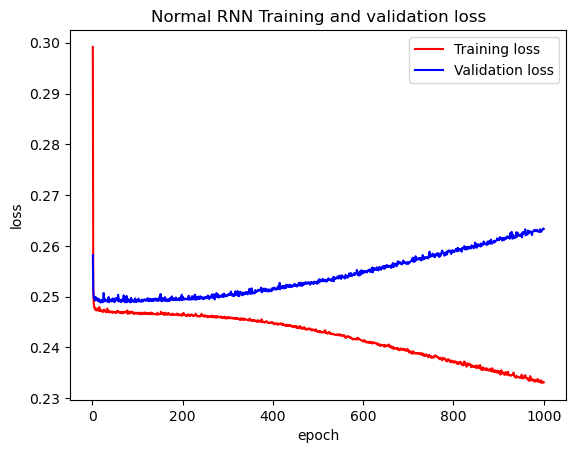

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Users\zihaow19\AppData\Local\Temp\ipykernel_17596\151401212.py:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 0s 1ms/step
(3706, 10, 2)


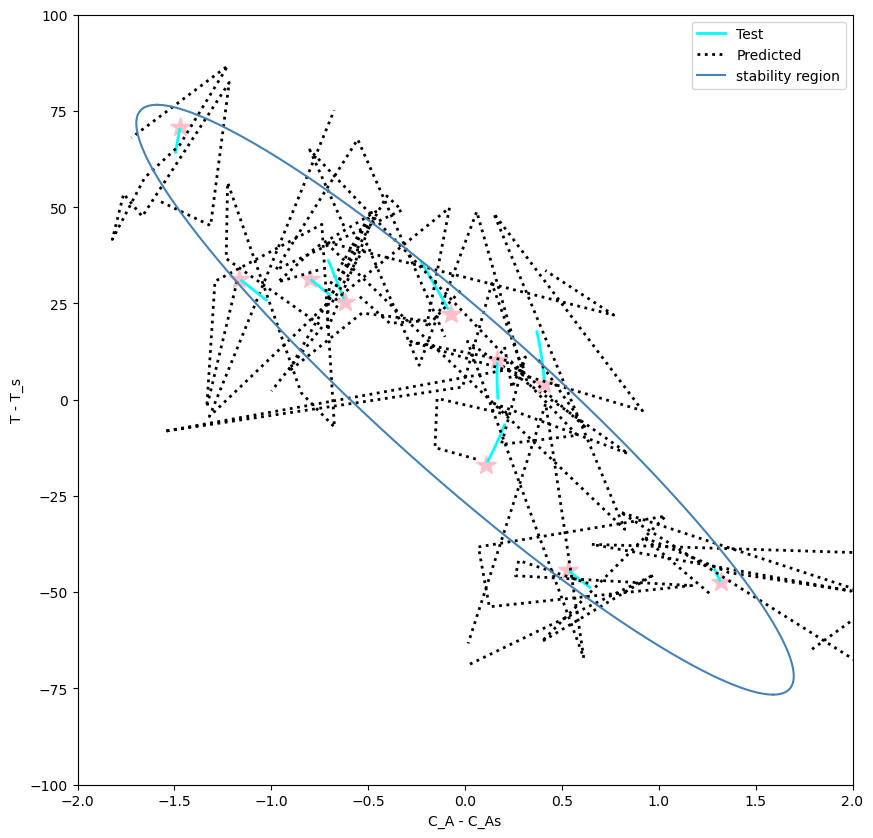

In [ ]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
# plt.savefig('iclrnn_noise_0.4.pdf')
plt.show()